#**Section 1 - Housing Prices**

Authors:
Yuval Ziv 207900283
  Tomer Tunitsky 316523935

# Part A - Packages and Data Loading


In [1]:
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import sklearn
import shap

from sklearn.decomposition import PCA
from scipy import stats
from sklearn import preprocessing

from numpy import interp

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
!pip install catboost
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet


In [2]:
test_set = pd.read_csv("/content/Housing_Prices_dataset_test.csv")
train_set = pd.read_csv("/content/Housing_Prices_dataset_train.csv")

#**Part B - Exploration**

> Add blockquote




In [3]:
test_set.shape

(292, 79)

In [4]:
train_set.shape

(1168, 80)

In [5]:
null_values = pd.DataFrame(train_set.isna().any()).rename(columns = {0:'isnull'})

In [6]:
null_values_stats = pd.DataFrame(train_set.isnull().sum()).sort_values(by = 0, ascending = False)
null_values_stats = null_values_stats.loc[null_values_stats[0] > 0]
null_values_stats

0
PoolQC        962
MiscFeature   957
Alley         957
Fence         786
MasVnrType    649
FireplaceQu   469
LotFrontage   205
GarageFinish  104
GarageQual     98
GarageCond     92
GarageType     80
BsmtCond       74
BsmtQual       67
BsmtExposure   67
GarageYrBlt    66
BsmtFinType1   56
BsmtFinType2   51
Electrical     44
MasVnrArea      6

In [7]:
test_set.head()

MSSubClass MSZoning  LotFrontage       LotArea Street Alley LotShape  \
0          45       RM    60.469229   1577.245118   Pave   NaN      Reg   
1          60       RL    87.906784   6556.416724   Pave   NaN      IR1   
2         190       RM    65.947889  12517.339617   Pave  Grvl      Reg   
3          20       RL          NaN   9781.945915   Pave  Pave      IR1   
4          20       RL   117.777562  16897.251035   Grvl   NaN      Reg   

  LandContour Utilities LotConfig  ... ScreenPorch   PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Corner  ...   45.252388   0.710029    NaN  GdPrv   
1         Lvl    AllPub    Corner  ...    0.928027  34.059836    NaN    NaN   
2         Lvl    AllPub    Inside  ...    0.000000   0.000000    NaN  GdPrv   
3         Lvl    NoSeWa    Inside  ...    7.477520  18.433285    NaN  MnPrv   
4         Lvl    AllPub    Corner  ...   45.509107   0.000000    NaN    NaN   

  MiscFeature     MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0        Othr    0.000000       7    2007        WD         Normal  
1        Gar2  290.309905      11    2006       CWD        Partial  
2        Othr   50.952430       6    2007        WD         Normal  
3        Shed  202.668981       5    2010        WD         Normal  
4         NaN  437.397137       7    2009        WD         Normal  

[5 rows x 79 columns]

In [8]:
train_set.head()
#we can see - train set has exactly one more feature than the test
#(the sale price, which is obviously supposed to be our prediction to the test set)

MSSubClass MSZoning  LotFrontage       LotArea Street Alley LotShape  \
0          60       RL   114.599056  12976.322829   Pave   NaN      Reg   
1          80       RL    66.959348  15594.194525   Pave   NaN      IR2   
2          20       RL          NaN  12391.795255   Pave   NaN      IR3   
3          50       RM    24.568303   1936.000000   Pave  Pave      Reg   
4          20       RL          NaN  25084.792141   Pave   NaN      IR3   

  LandContour Utilities LotConfig  ...   PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...   0.000000    NaN    NaN         NaN   
1         Bnk    AllPub    Inside  ...   0.000000    NaN    NaN         NaN   
2         Lvl    AllPub       FR3  ...   0.000000    NaN  MnPrv         NaN   
3         Lvl    AllPub    Inside  ...  34.640056    NaN  MnPrv         NaN   
4         Lvl    AllPub    Inside  ...   0.000000    NaN  GdPrv         NaN   

      MiscVal MoSold  YrSold  SaleType  SaleCondition      SalePrice  
0  296.249343      5    2008     ConLD         Normal  155664.570167  
1  254.008897      7    2008     ConLD         Normal  192977.232227  
2  188.143817      2    2010        WD         Normal  142885.167896  
3    0.000000     12    2007        WD         Normal   84625.216884  
4    0.000000      5    2010       COD        Abnorml  131905.509480  

[5 rows x 80 columns]

# Part B1 - General Stats

In [9]:
train_set.info()
train_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    963 non-null    float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   Alley          211 non-null    object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuil

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1168.000000   963.000000    1168.000000  1168.000000  1168.000000   
mean     62.577055    70.096183   10804.705781     6.087329     5.573630   
std      45.946609    27.670641    9332.370975     1.398093     1.119152   
min      20.000000     3.062877      30.644018     1.000000     1.000000   
25%      20.000000    53.523116    5918.750000     5.000000     5.000000   
50%      60.000000    69.171416    9641.304314     6.000000     5.000000   
75%      80.000000    84.832822   13652.260887     7.000000     6.000000   
max     190.000000   312.997838  167592.229562    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1168.000000   1168.000000  1162.000000  1168.000000  1168.000000  ...   
mean   1971.616372   1984.262104   127.481016   491.518248    75.056067  ...   
std      33.491293     23.294882   185.051860   469.624051   157.901653  ...   
min    1859.992440   1919.368439     0.000000     0.000000     0.000000  ...   
25%    1949.035586   1966.560725     0.000000   106.085804     0.000000  ...   
50%    1974.850829   1988.398016    61.139121   394.934987    16.684170  ...   
75%    1997.698636   2003.149146   174.233091   749.113521    81.053367  ...   
max    2046.355273   2037.311524  1733.701541  5695.300016  1470.025351  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1168.000000  1168.000000    1168.000000  1168.000000  1168.000000   
mean    107.474930    53.184235      33.603085     8.676948    25.502434   
std     123.680720    64.892561      61.875214    27.845960    57.068714   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     3.121553       0.000000     0.000000     0.000000   
50%      63.727854    32.381911       7.361691     0.246591     2.247700   
75%     178.363995    75.579627      33.507896    10.640647    22.678792   
max     890.949583   542.204592     527.329955   512.904641   427.803168   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1168.000000   1168.000000  1168.000000  1168.000000    1168.000000  
mean     11.801869    142.319057     6.361301  2007.803082  181982.786079  
std      46.459399    549.310486     2.701285     1.330130   89206.602744  
min       0.000000      0.000000     1.000000  2006.000000    3573.797098  
25%       0.000000      0.000000     5.000000  2007.000000  127019.572086  
50%       0.273856      0.000000     6.000000  2008.000000  166082.959443  
75%      14.832141    195.233326     8.000000  2009.000000  224867.542569  
max     750.180075  15331.124741    12.000000  2010.000000  756590.767461  

[8 rows x 37 columns]

In [10]:
NaNs = {}
for i in train_set.columns:
    NaNs[i]= train_set[i].isna().sum()
print (NaNs)

{'MSSubClass': 0, 'MSZoning': 0, 'LotFrontage': 205, 'LotArea': 0, 'Street': 0, 'Alley': 957, 'LotShape': 0, 'LandContour': 0, 'Utilities': 0, 'LotConfig': 0, 'LandSlope': 0, 'Neighborhood': 0, 'Condition1': 0, 'Condition2': 0, 'BldgType': 0, 'HouseStyle': 0, 'OverallQual': 0, 'OverallCond': 0, 'YearBuilt': 0, 'YearRemodAdd': 0, 'RoofStyle': 0, 'RoofMatl': 0, 'Exterior1st': 0, 'Exterior2nd': 0, 'MasVnrType': 649, 'MasVnrArea': 6, 'ExterQual': 0, 'ExterCond': 0, 'Foundation': 0, 'BsmtQual': 67, 'BsmtCond': 74, 'BsmtExposure': 67, 'BsmtFinType1': 56, 'BsmtFinSF1': 0, 'BsmtFinType2': 51, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0, 'TotalBsmtSF': 0, 'Heating': 0, 'HeatingQC': 0, 'CentralAir': 0, 'Electrical': 44, '1stFlrSF': 0, '2ndFlrSF': 0, 'LowQualFinSF': 0, 'GrLivArea': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0, 'FullBath': 0, 'HalfBath': 0, 'BedroomAbvGr': 0, 'KitchenAbvGr': 0, 'KitchenQual': 0, 'TotRmsAbvGrd': 0, 'Functional': 0, 'Fireplaces': 0, 'FireplaceQu': 469, 'GarageType': 80, 'GarageYrBlt

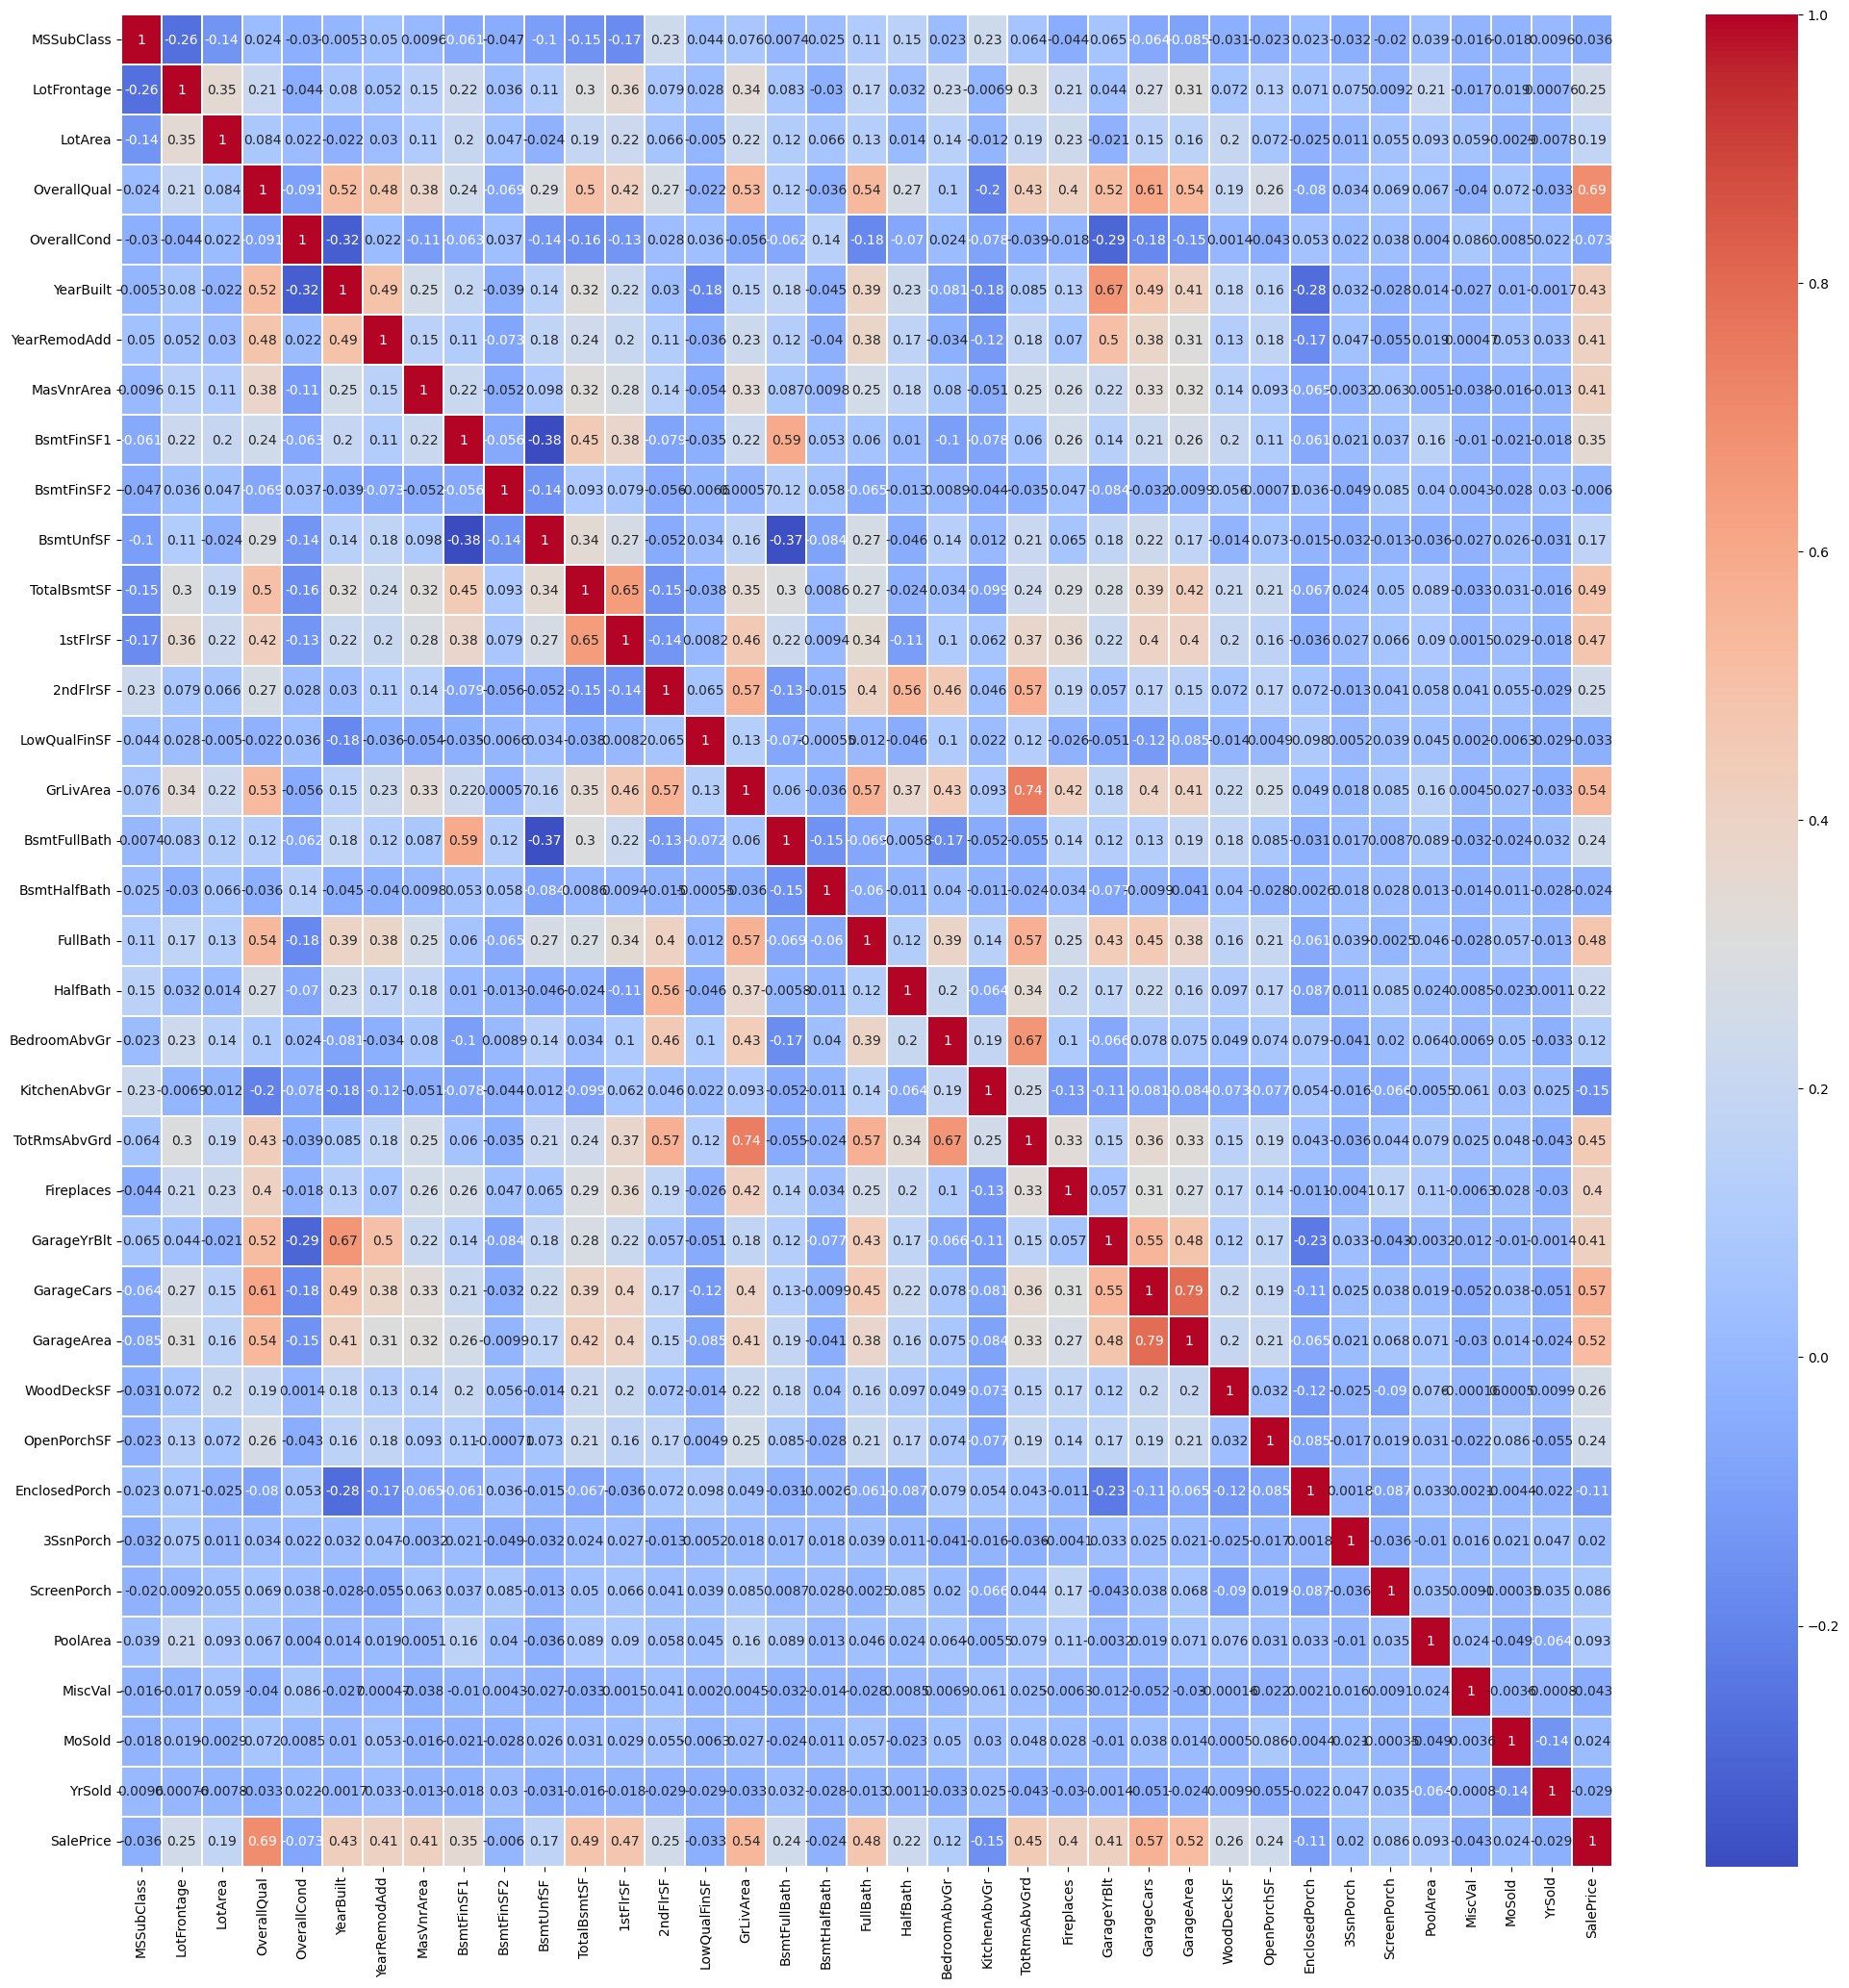

In [11]:
#Correlation Matrix for numeric values
#Removal will be at the end
plt.subplots(figsize=(25,25))
train_set_for_corr_matrix = train_set.loc[:, train_set.select_dtypes(include=[np.number]).columns]
sns.heatmap(train_set_for_corr_matrix.corr(),
           annot=True, linewidth='0.05', cmap="coolwarm")
plt.show()

train_set.head()

## Part B1 - Distributions primary exploration (numerical & categorical features)

Feature: MSSubClass

Info:
Number of nulls: 0
count    1168.000000
mean       62.577055
std        45.946609
min        20.000000
25%        20.000000
50%        60.000000
75%        80.000000
max       190.000000
Name: MSSubClass, dtype: float64


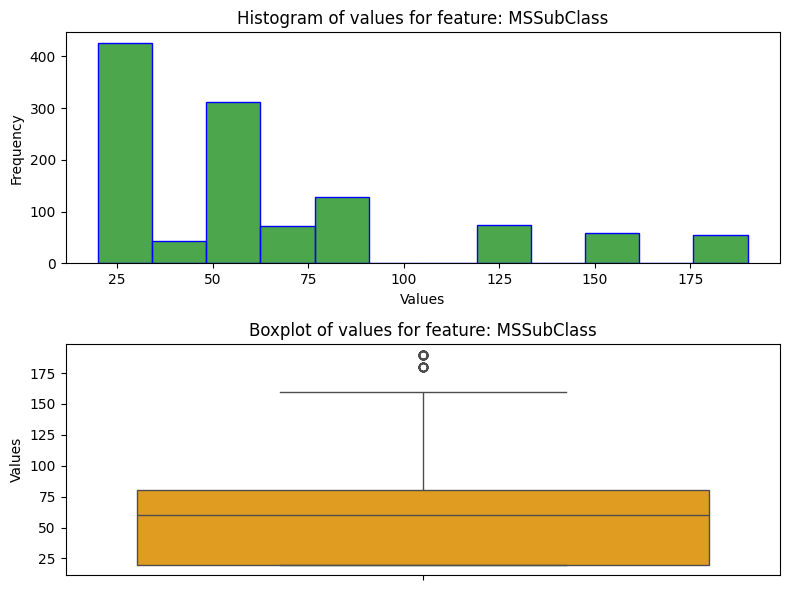



Feature: MSZoning

Info:
Number of nulls: 0
count     1168
unique       5
top         RL
freq       783
Name: MSZoning, dtype: object


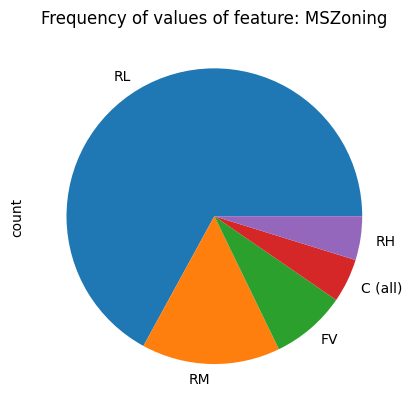



Feature: LotFrontage

Info:
Number of nulls: 205
count    963.000000
mean      70.096183
std       27.670641
min        3.062877
25%       53.523116
50%       69.171416
75%       84.832822
max      312.997838
Name: LotFrontage, dtype: float64


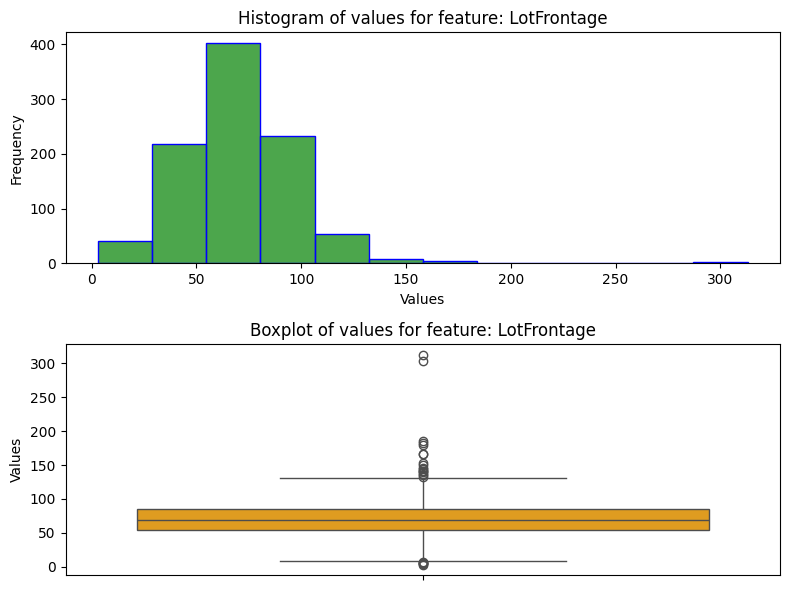



Feature: LotArea

Info:
Number of nulls: 0
count      1168.000000
mean      10804.705781
std        9332.370975
min          30.644018
25%        5918.750000
50%        9641.304314
75%       13652.260887
max      167592.229562
Name: LotArea, dtype: float64


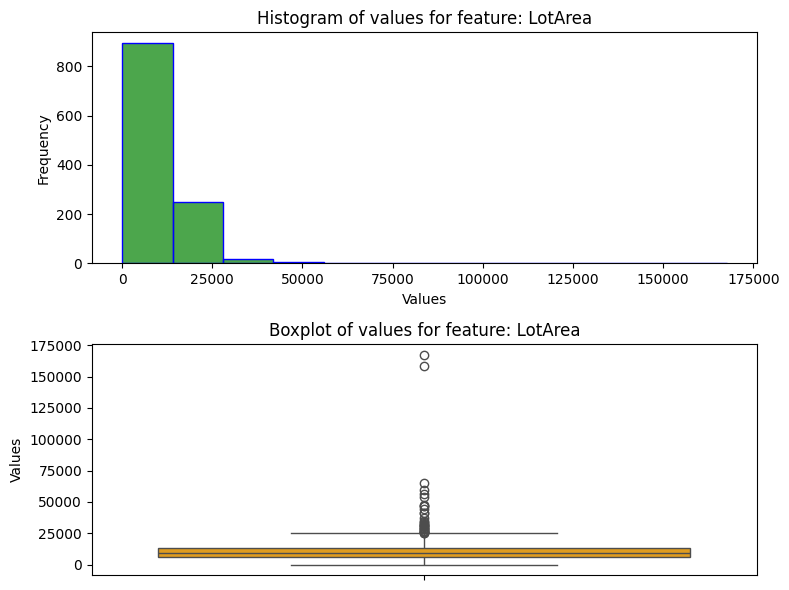



Feature: Street

Info:
Number of nulls: 0
count     1168
unique       2
top       Pave
freq      1051
Name: Street, dtype: object


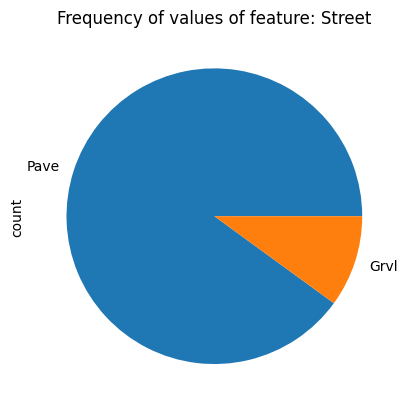



Feature: Alley

Info:
Number of nulls: 957
count      211
unique       2
top       Grvl
freq       110
Name: Alley, dtype: object


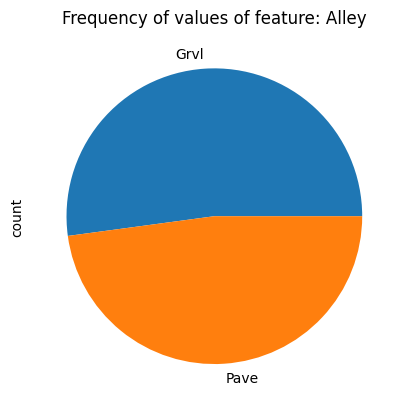



Feature: LotShape

Info:
Number of nulls: 0
count     1168
unique       4
top        Reg
freq       637
Name: LotShape, dtype: object


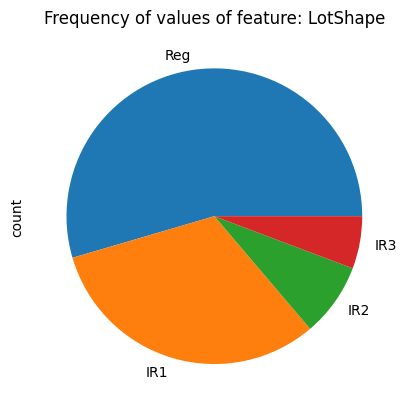



Feature: LandContour

Info:
Number of nulls: 0
count     1168
unique       4
top        Lvl
freq       903
Name: LandContour, dtype: object


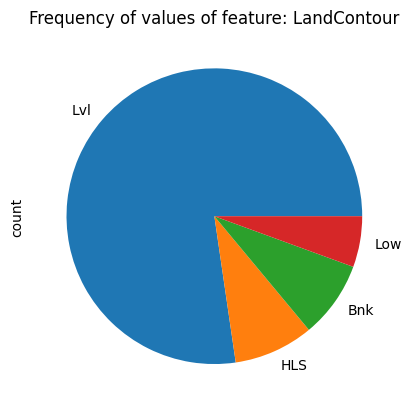



Feature: Utilities

Info:
Number of nulls: 0
count       1168
unique         2
top       AllPub
freq        1047
Name: Utilities, dtype: object


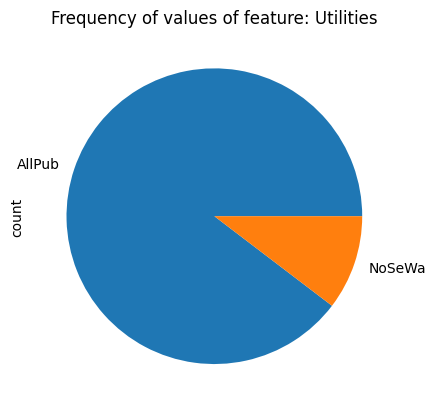



Feature: LotConfig

Info:
Number of nulls: 0
count       1168
unique         5
top       Inside
freq         719
Name: LotConfig, dtype: object


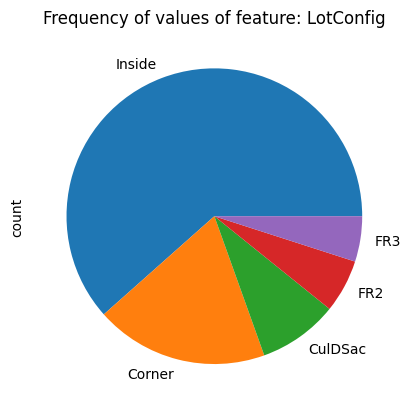



Feature: LandSlope

Info:
Number of nulls: 0
count     1168
unique       3
top        Gtl
freq       948
Name: LandSlope, dtype: object


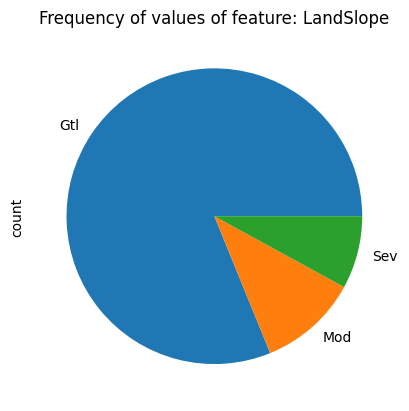



Feature: Neighborhood

Info:
Number of nulls: 0
count      1168
unique       25
top       NAmes
freq        145
Name: Neighborhood, dtype: object


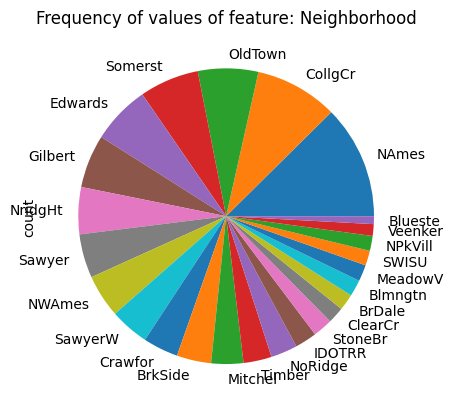



Feature: Condition1

Info:
Number of nulls: 0
count     1168
unique       9
top       Norm
freq       828
Name: Condition1, dtype: object


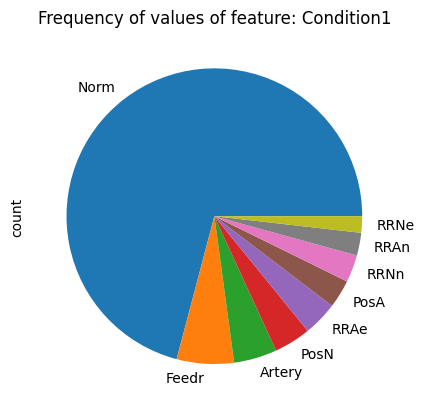



Feature: Condition2

Info:
Number of nulls: 0
count     1168
unique       8
top       Norm
freq       934
Name: Condition2, dtype: object


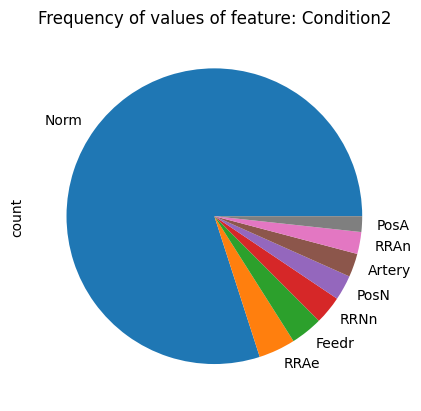



Feature: BldgType

Info:
Number of nulls: 0
count     1168
unique       5
top       1Fam
freq       808
Name: BldgType, dtype: object


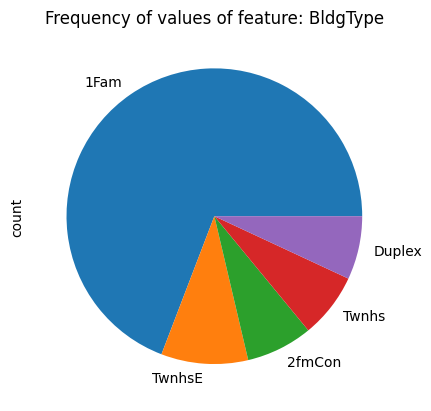



Feature: HouseStyle

Info:
Number of nulls: 0
count       1168
unique         8
top       1Story
freq         508
Name: HouseStyle, dtype: object


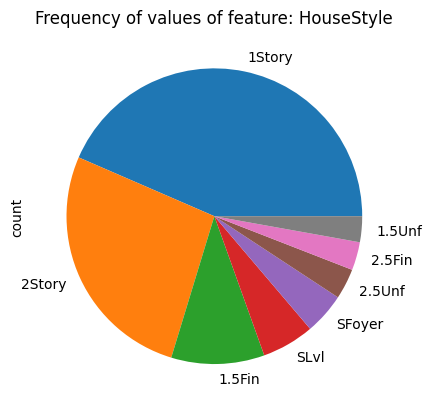



Feature: OverallQual

Info:
Number of nulls: 0
count    1168.000000
mean        6.087329
std         1.398093
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


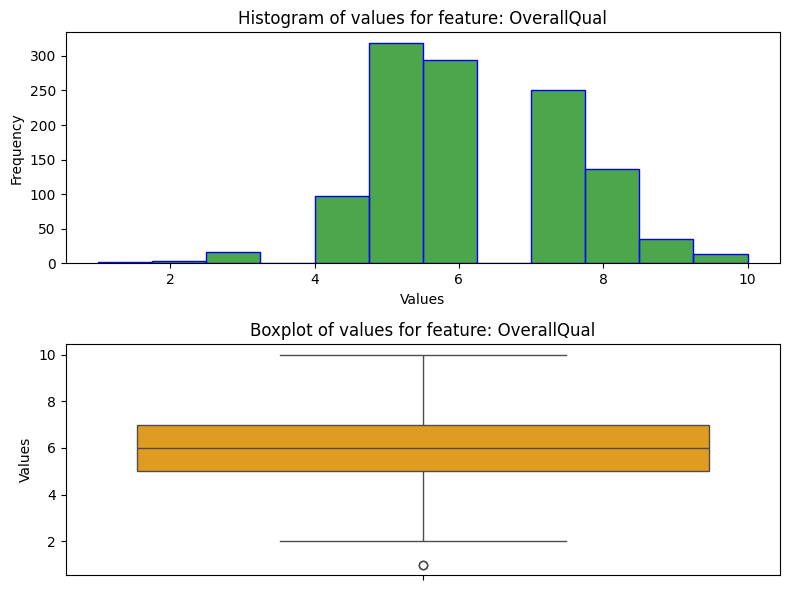



Feature: OverallCond

Info:
Number of nulls: 0
count    1168.000000
mean        5.573630
std         1.119152
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


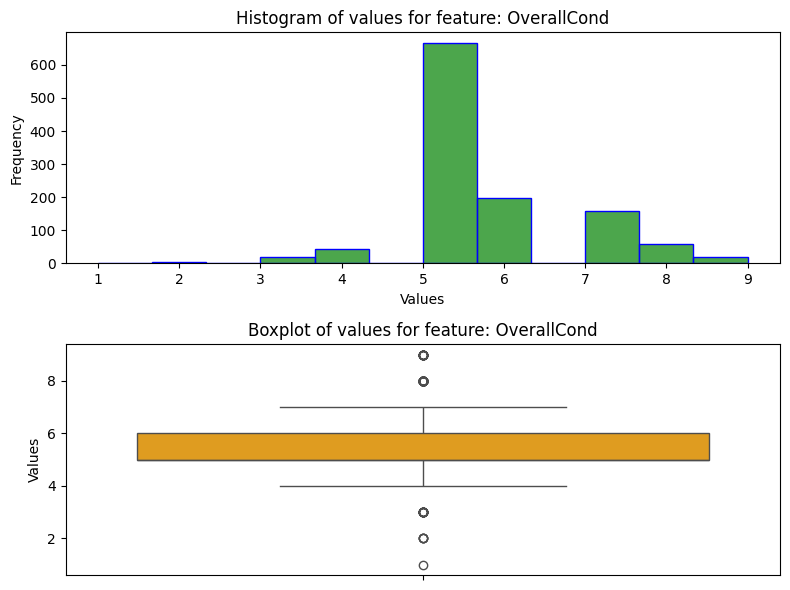



Feature: YearBuilt

Info:
Number of nulls: 0
count    1168.000000
mean     1971.616372
std        33.491293
min      1859.992440
25%      1949.035586
50%      1974.850829
75%      1997.698636
max      2046.355273
Name: YearBuilt, dtype: float64


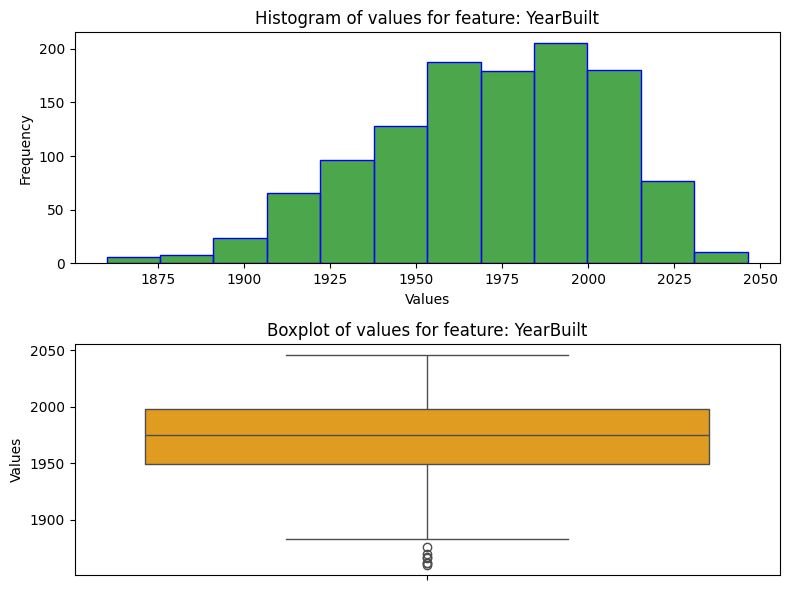



Feature: YearRemodAdd

Info:
Number of nulls: 0
count    1168.000000
mean     1984.262104
std        23.294882
min      1919.368439
25%      1966.560725
50%      1988.398016
75%      2003.149146
max      2037.311524
Name: YearRemodAdd, dtype: float64


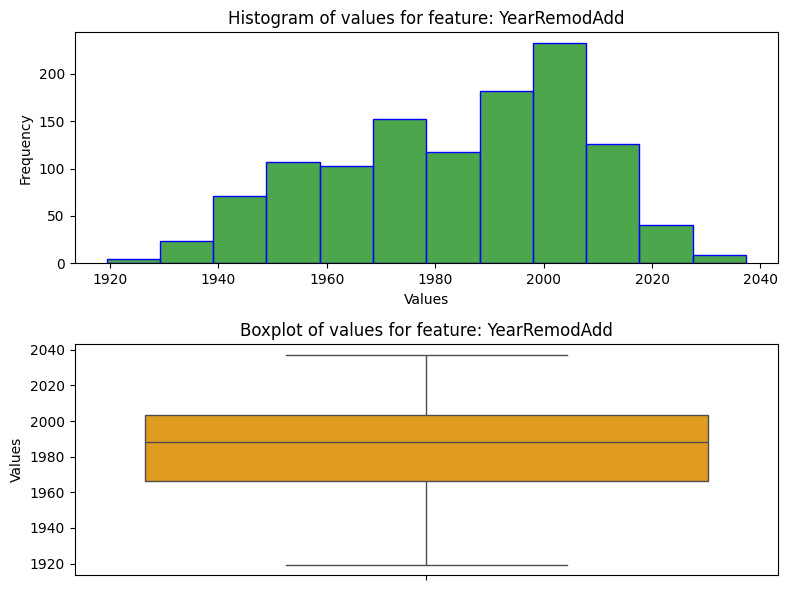



Feature: RoofStyle

Info:
Number of nulls: 0
count      1168
unique        6
top       Gable
freq        772
Name: RoofStyle, dtype: object


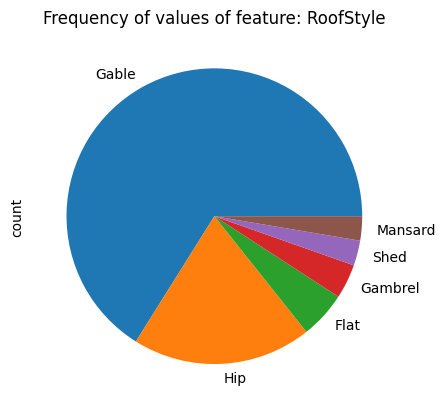



Feature: RoofMatl

Info:
Number of nulls: 0
count        1168
unique          8
top       CompShg
freq          950
Name: RoofMatl, dtype: object


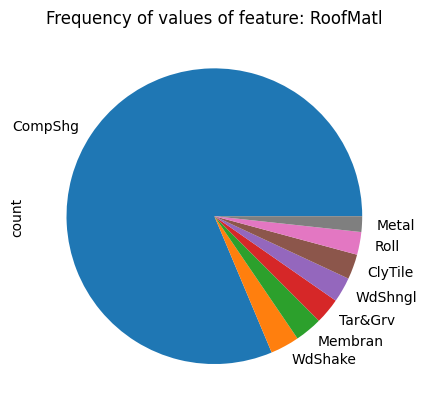



Feature: Exterior1st

Info:
Number of nulls: 0
count        1168
unique         15
top       VinylSd
freq          351
Name: Exterior1st, dtype: object


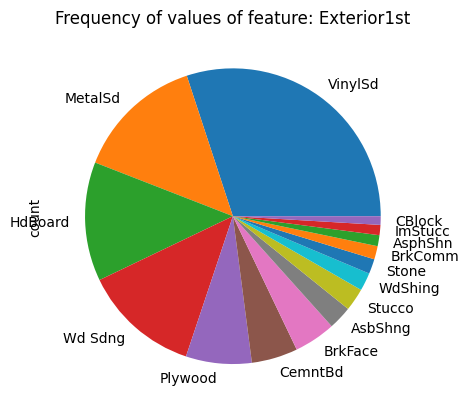



Feature: Exterior2nd

Info:
Number of nulls: 0
count        1168
unique         16
top       VinylSd
freq          340
Name: Exterior2nd, dtype: object


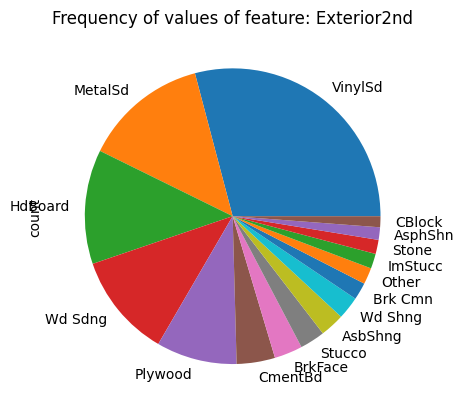



Feature: MasVnrType

Info:
Number of nulls: 649
count         519
unique          3
top       BrkFace
freq          342
Name: MasVnrType, dtype: object


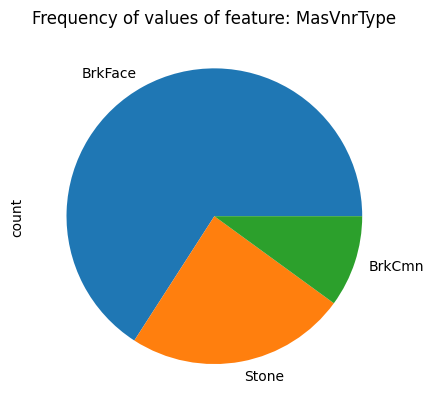



Feature: MasVnrArea

Info:
Number of nulls: 6
count    1162.000000
mean      127.481016
std       185.051860
min         0.000000
25%         0.000000
50%        61.139121
75%       174.233091
max      1733.701541
Name: MasVnrArea, dtype: float64


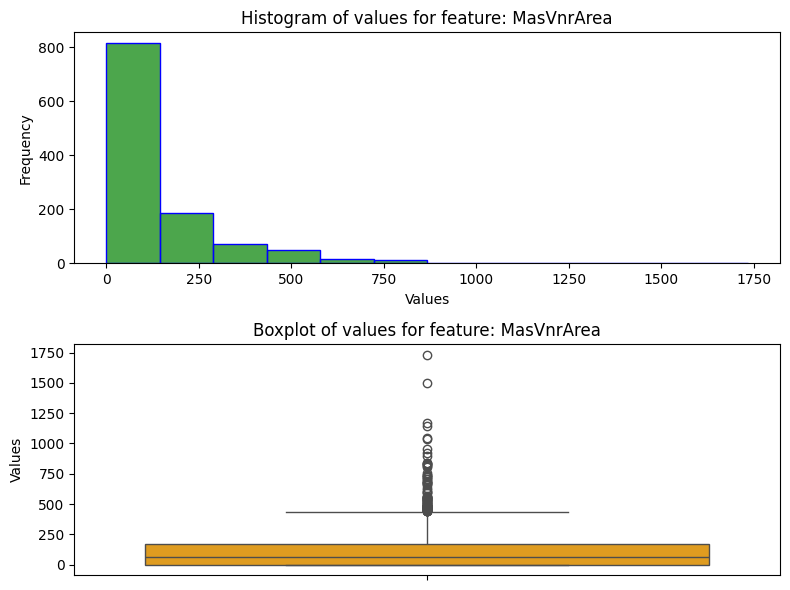



Feature: ExterQual

Info:
Number of nulls: 0
count     1168
unique       4
top         TA
freq       644
Name: ExterQual, dtype: object


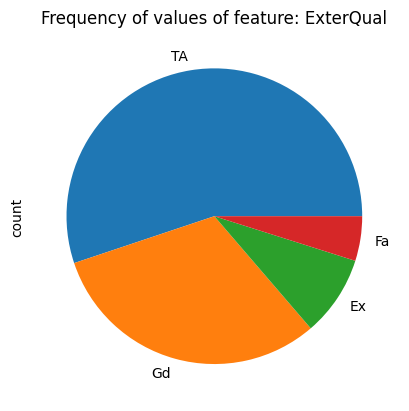



Feature: ExterCond

Info:
Number of nulls: 0
count     1168
unique       5
top         TA
freq       881
Name: ExterCond, dtype: object


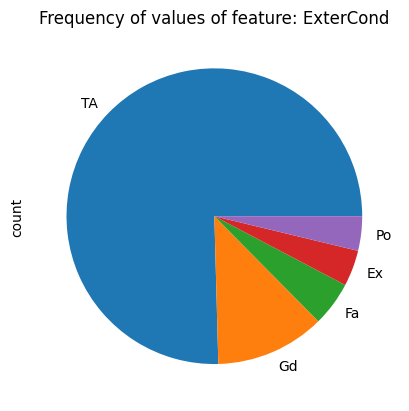



Feature: Foundation

Info:
Number of nulls: 0
count      1168
unique        6
top       PConc
freq        460
Name: Foundation, dtype: object


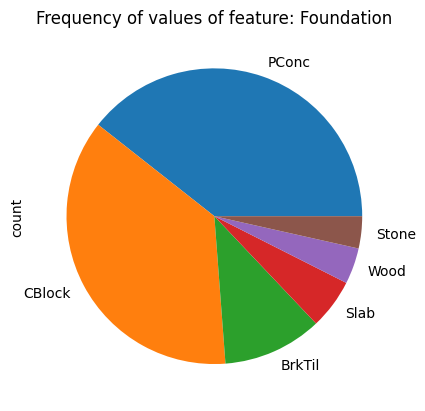



Feature: BsmtQual

Info:
Number of nulls: 67
count     1101
unique       4
top         TA
freq       463
Name: BsmtQual, dtype: object


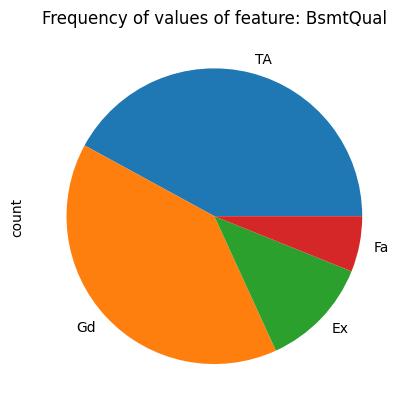



Feature: BsmtCond

Info:
Number of nulls: 74
count     1094
unique       4
top         TA
freq       881
Name: BsmtCond, dtype: object


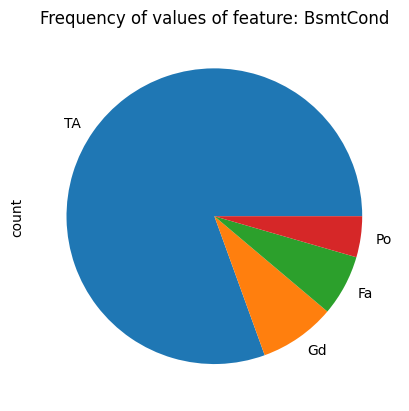



Feature: BsmtExposure

Info:
Number of nulls: 67
count     1101
unique       4
top         No
freq       647
Name: BsmtExposure, dtype: object


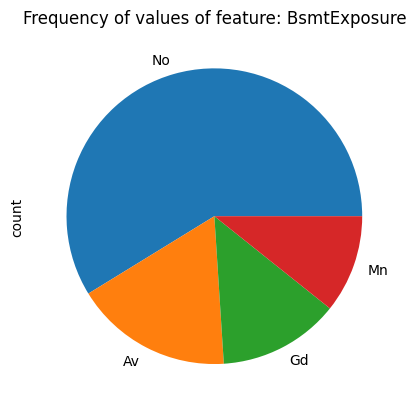



Feature: BsmtFinType1

Info:
Number of nulls: 56
count     1112
unique       6
top        GLQ
freq       302
Name: BsmtFinType1, dtype: object


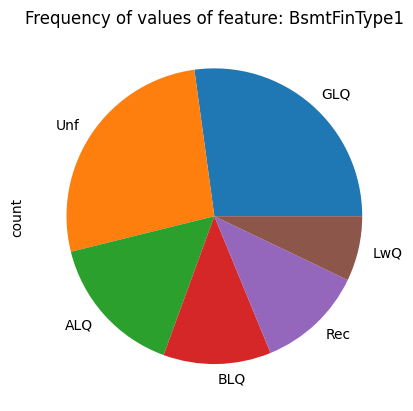



Feature: BsmtFinSF1

Info:
Number of nulls: 0
count    1168.000000
mean      491.518248
std       469.624051
min         0.000000
25%       106.085804
50%       394.934987
75%       749.113521
max      5695.300016
Name: BsmtFinSF1, dtype: float64


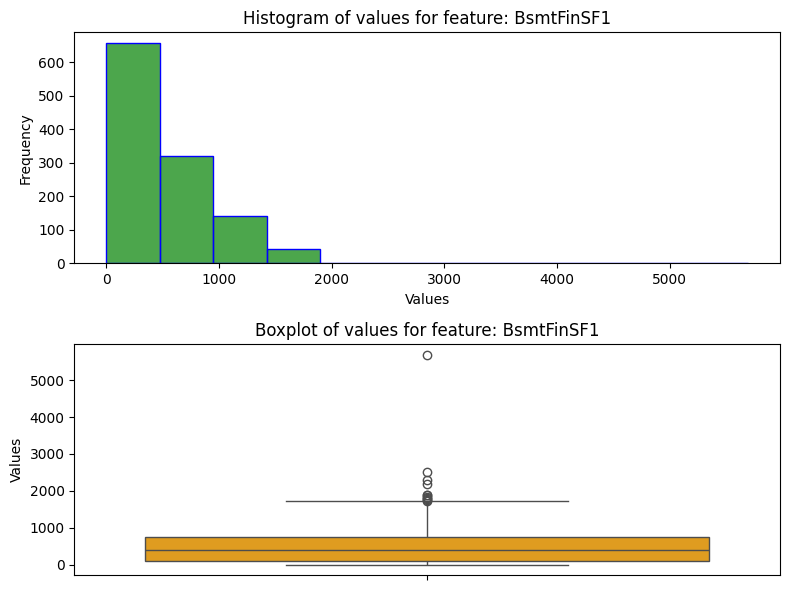



Feature: BsmtFinType2

Info:
Number of nulls: 51
count     1117
unique       6
top        Unf
freq       836
Name: BsmtFinType2, dtype: object


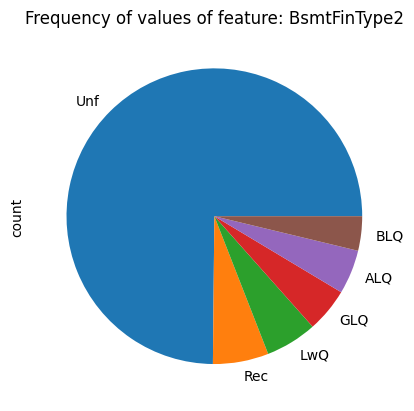



Feature: BsmtFinSF2

Info:
Number of nulls: 0
count    1168.000000
mean       75.056067
std       157.901653
min         0.000000
25%         0.000000
50%        16.684170
75%        81.053367
max      1470.025351
Name: BsmtFinSF2, dtype: float64


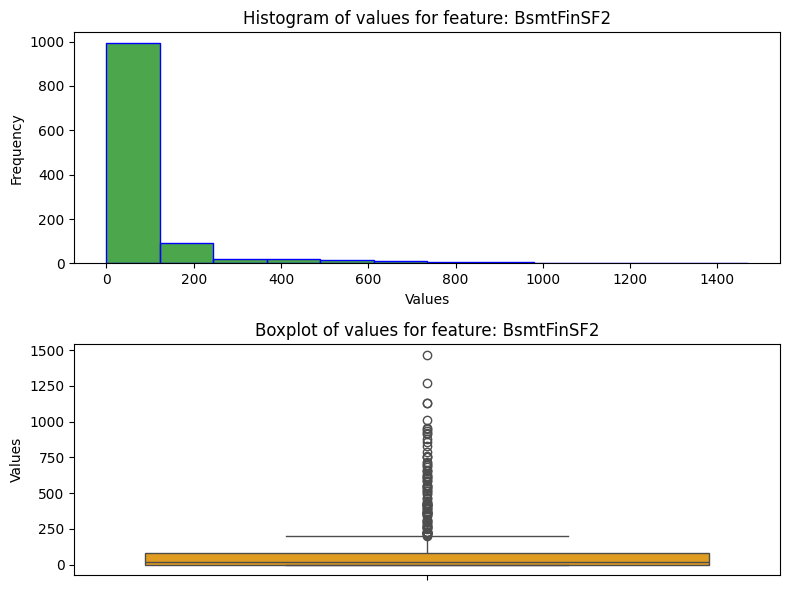



Feature: BsmtUnfSF

Info:
Number of nulls: 0
count    1168.000000
mean      593.875755
std       467.269470
min         0.000000
25%       238.966969
50%       495.526173
75%       836.426097
max      2378.284393
Name: BsmtUnfSF, dtype: float64


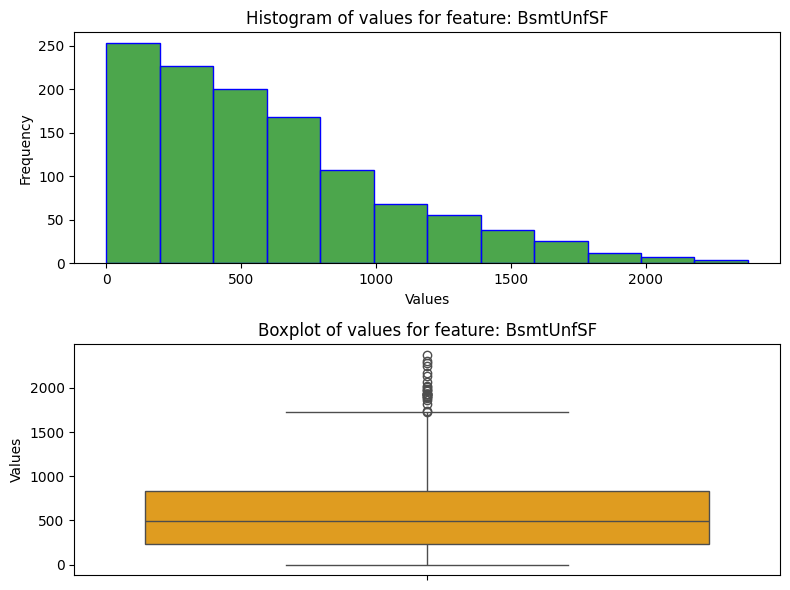



Feature: TotalBsmtSF

Info:
Number of nulls: 0
count    1168.000000
mean     1050.464176
std       488.252474
min         0.000000
25%       714.704001
50%      1022.342597
75%      1310.042754
max      6009.028978
Name: TotalBsmtSF, dtype: float64


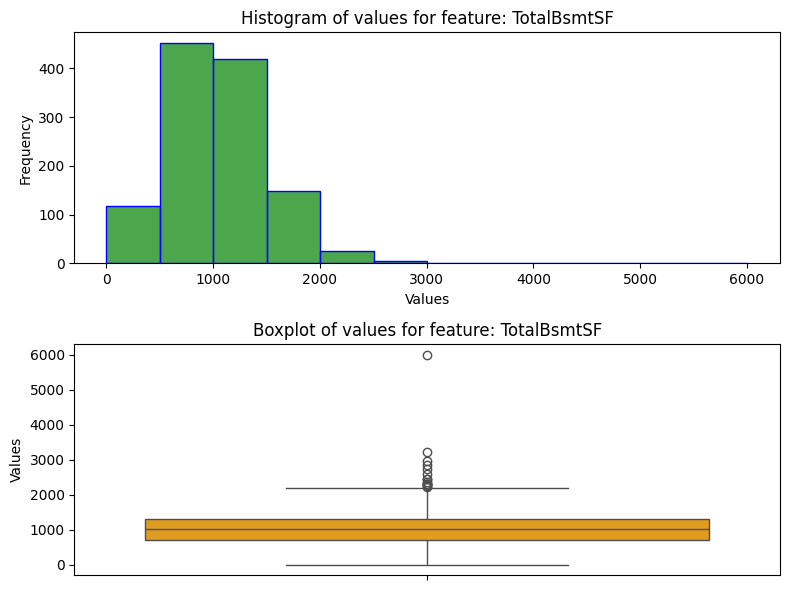



Feature: Heating

Info:
Number of nulls: 0
count     1168
unique       6
top       GasA
freq       931
Name: Heating, dtype: object


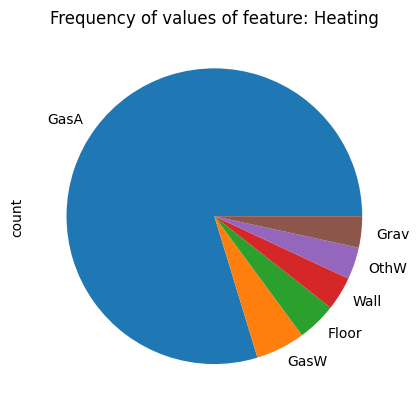



Feature: HeatingQC

Info:
Number of nulls: 0
count     1168
unique       5
top         Ex
freq       510
Name: HeatingQC, dtype: object


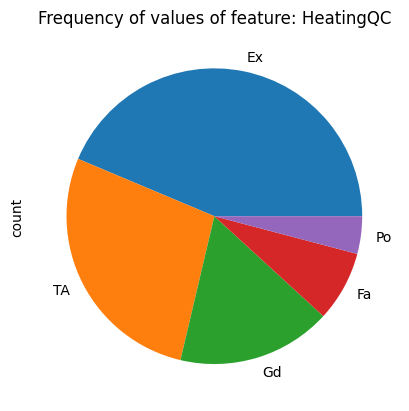



Feature: CentralAir

Info:
Number of nulls: 0
count     1168
unique       2
top          Y
freq      1001
Name: CentralAir, dtype: object


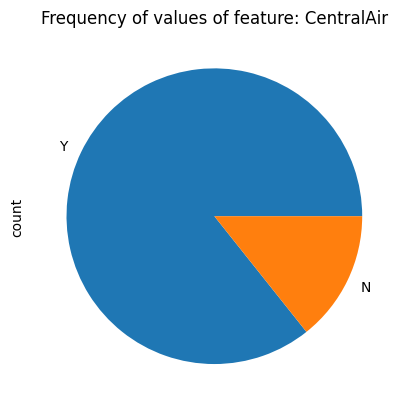



Feature: Electrical

Info:
Number of nulls: 44
count      1124
unique        5
top       SBrkr
freq        907
Name: Electrical, dtype: object


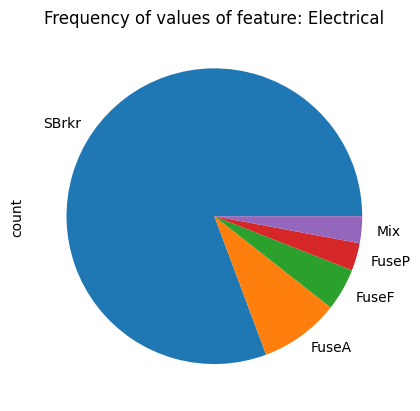



Feature: 1stFlrSF

Info:
Number of nulls: 0
count    1168.000000
mean     1163.476380
std       425.326863
min        98.493543
25%       861.106413
50%      1125.294188
75%      1405.563224
max      4375.508226
Name: 1stFlrSF, dtype: float64


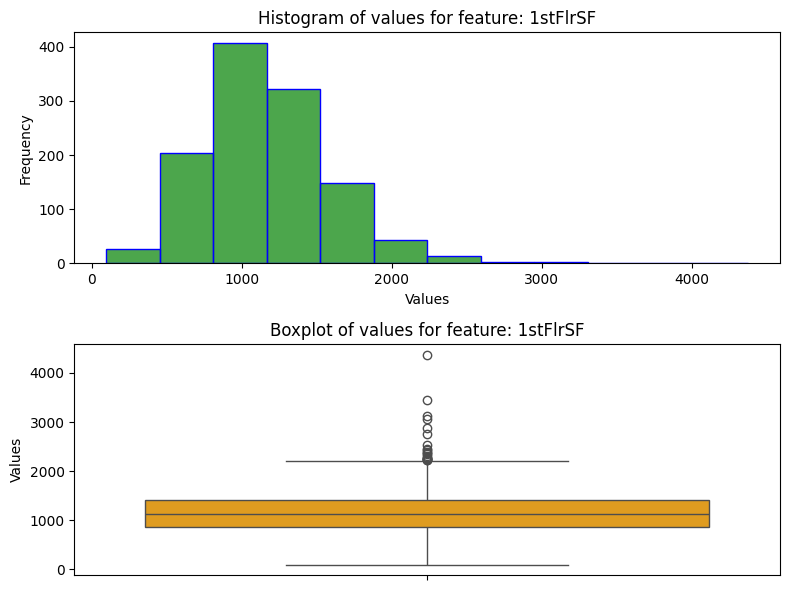



Feature: 2ndFlrSF

Info:
Number of nulls: 0
count    1168.000000
mean      403.183394
std       433.757901
min         0.000000
25%         0.000000
50%       237.583351
75%       711.796067
max      2304.730395
Name: 2ndFlrSF, dtype: float64


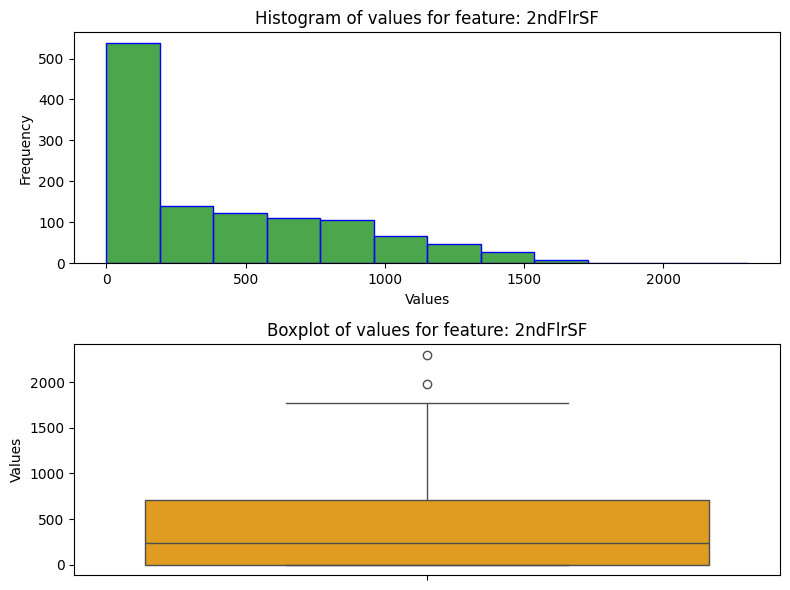



Feature: LowQualFinSF

Info:
Number of nulls: 0
count    1168.000000
mean       15.057430
std        49.056446
min         0.000000
25%         0.000000
50%         0.000000
75%        16.566085
max       553.082656
Name: LowQualFinSF, dtype: float64


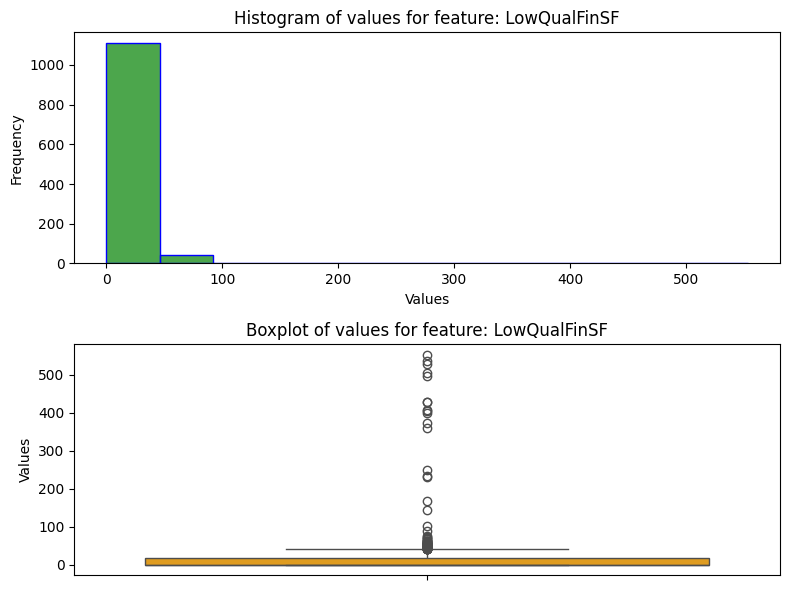



Feature: GrLivArea

Info:
Number of nulls: 0
count    1168.000000
mean     1527.265684
std       589.070397
min       207.127023
25%      1128.707694
50%      1475.017611
75%      1824.205202
max      5540.881154
Name: GrLivArea, dtype: float64


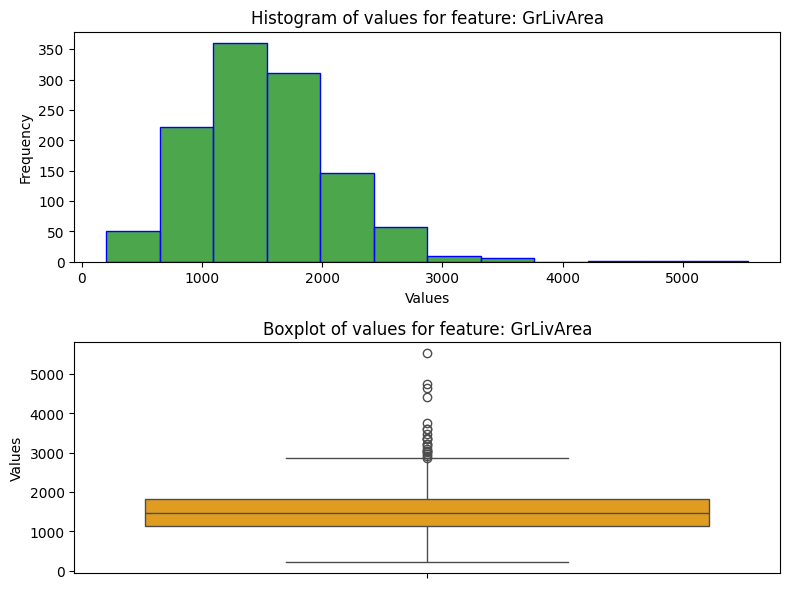



Feature: BsmtFullBath

Info:
Number of nulls: 0
count    1168.000000
mean        0.421233
std         0.520985
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64


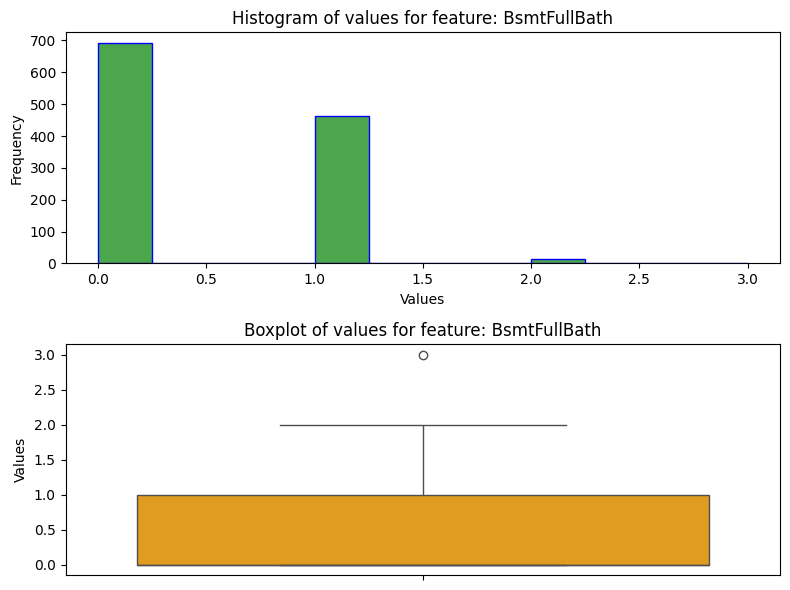



Feature: BsmtHalfBath

Info:
Number of nulls: 0
count    1168.000000
mean        0.062500
std         0.245678
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64


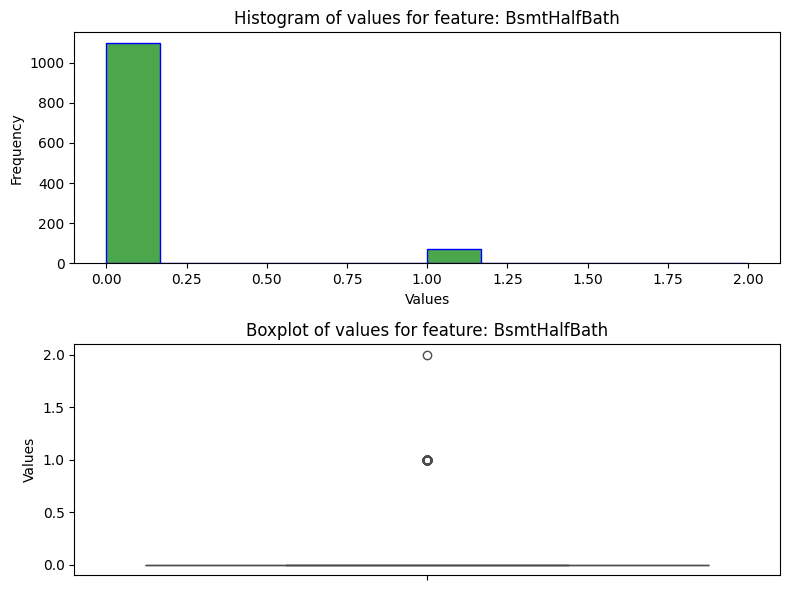



Feature: FullBath

Info:
Number of nulls: 0
count    1168.000000
mean        1.570205
std         0.557140
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64


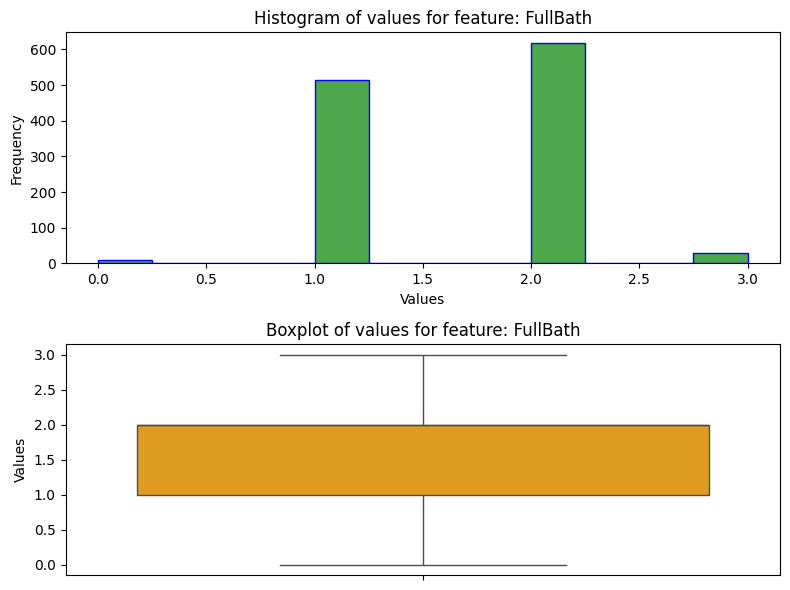



Feature: HalfBath

Info:
Number of nulls: 0
count    1168.000000
mean        0.377568
std         0.504047
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64


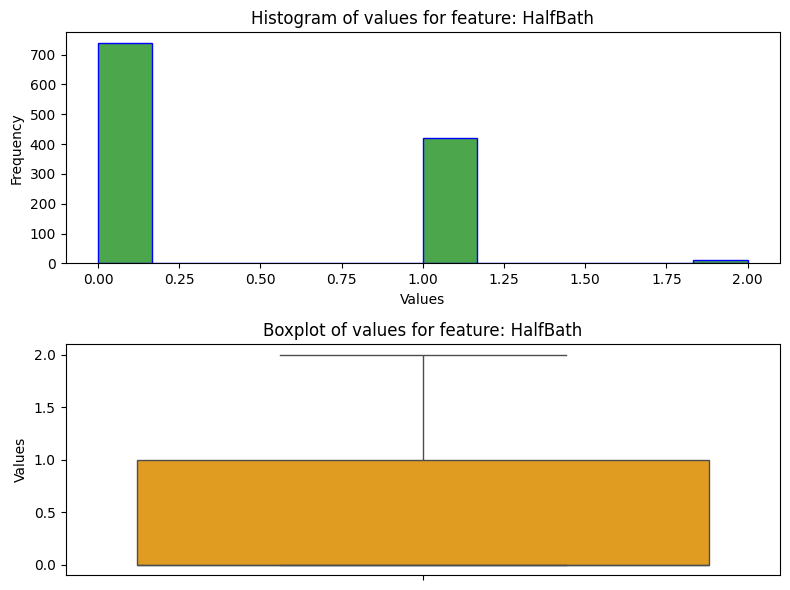



Feature: BedroomAbvGr

Info:
Number of nulls: 0
count    1168.000000
mean        2.855308
std         0.826172
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64


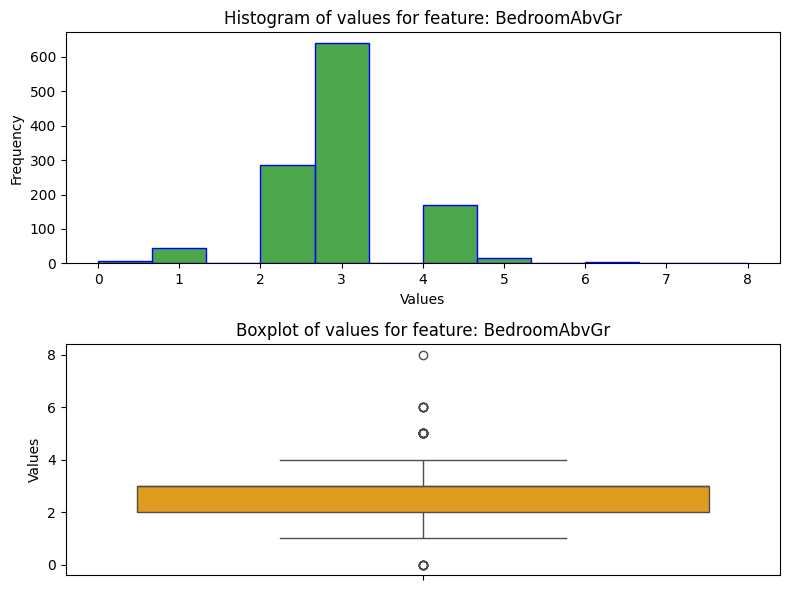



Feature: KitchenAbvGr

Info:
Number of nulls: 0
count    1168.000000
mean        1.051370
std         0.228474
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64


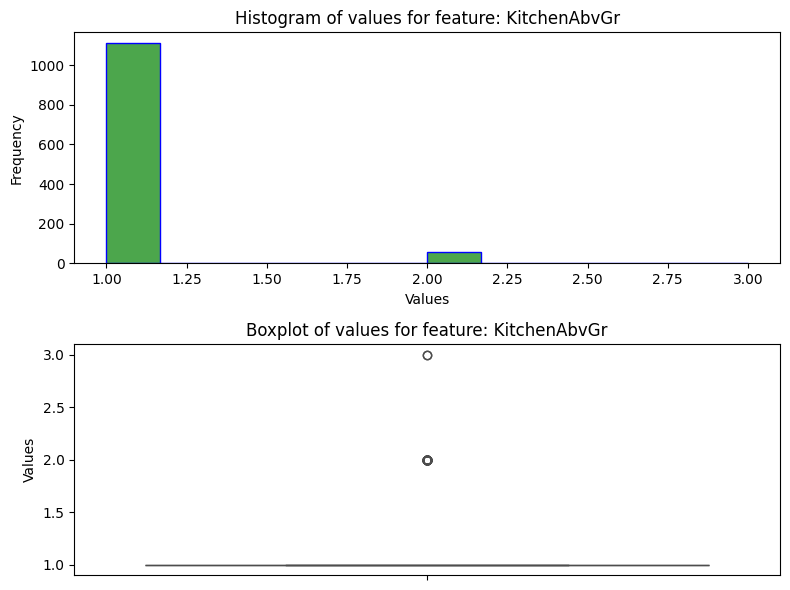



Feature: KitchenQual

Info:
Number of nulls: 0
count     1168
unique       4
top         TA
freq       529
Name: KitchenQual, dtype: object


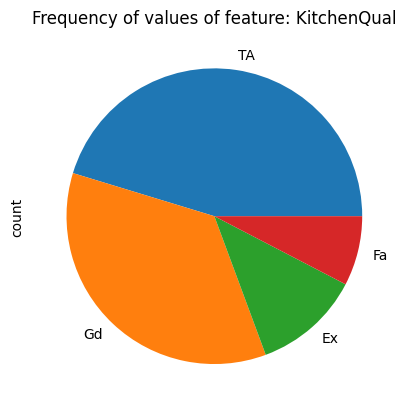



Feature: TotRmsAbvGrd

Info:
Number of nulls: 0
count    1168.000000
mean        6.506849
std         1.624034
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64


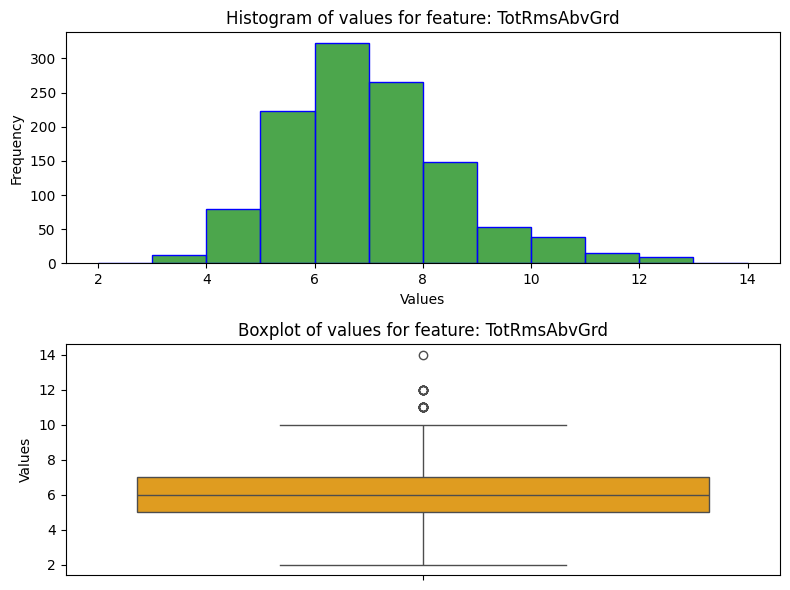



Feature: Functional

Info:
Number of nulls: 0
count     1168
unique       7
top        Typ
freq       922
Name: Functional, dtype: object


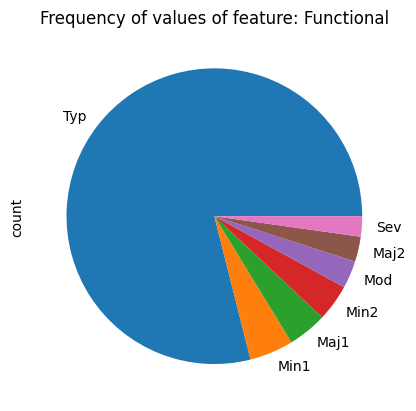



Feature: Fireplaces

Info:
Number of nulls: 0
count    1168.000000
mean        0.612158
std         0.644871
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64


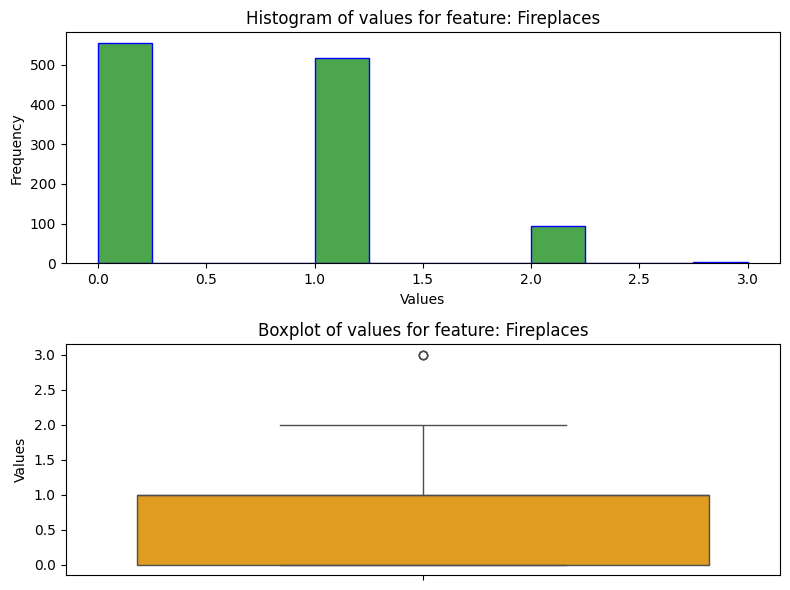



Feature: FireplaceQu

Info:
Number of nulls: 469
count     699
unique      5
top        Gd
freq      292
Name: FireplaceQu, dtype: object


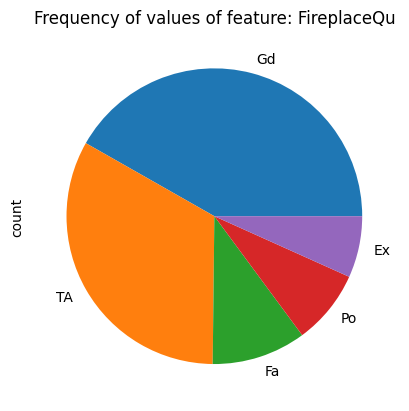



Feature: GarageType

Info:
Number of nulls: 80
count       1088
unique         6
top       Attchd
freq         581
Name: GarageType, dtype: object


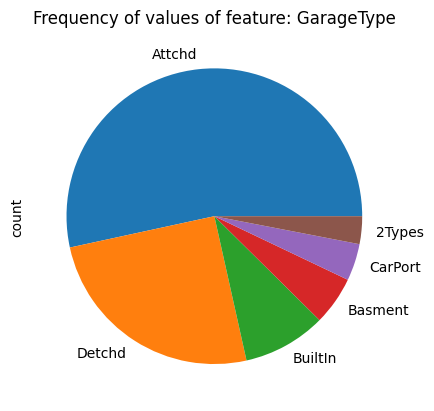



Feature: GarageYrBlt

Info:
Number of nulls: 66
count    1102.000000
mean     1978.306305
std        27.633002
min      1880.897104
25%      1959.770816
50%      1981.287879
75%      2000.252675
max      2035.839367
Name: GarageYrBlt, dtype: float64


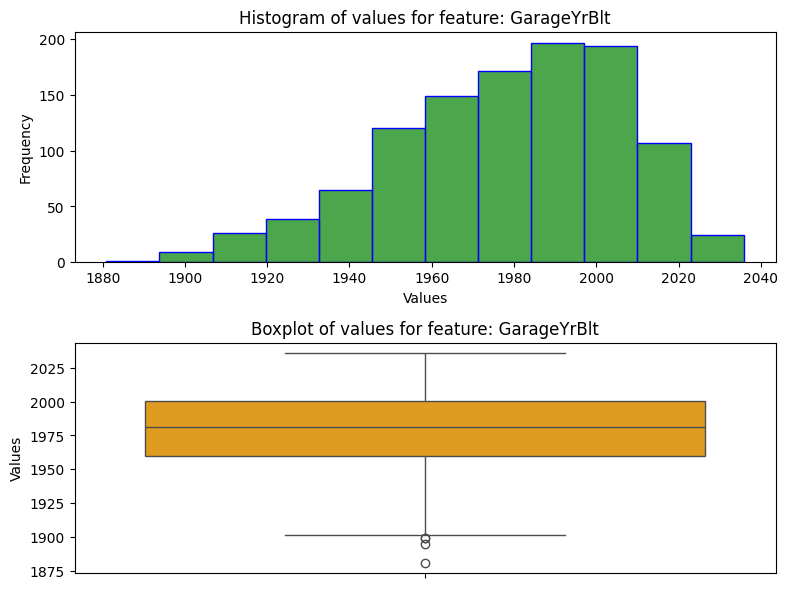



Feature: GarageFinish

Info:
Number of nulls: 104
count     1064
unique       3
top        Unf
freq       453
Name: GarageFinish, dtype: object


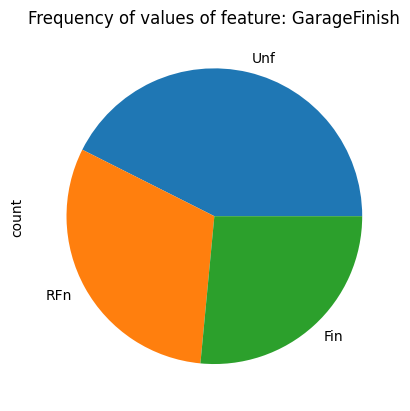



Feature: GarageCars

Info:
Number of nulls: 0
count    1168.000000
mean        1.768836
std         0.746075
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


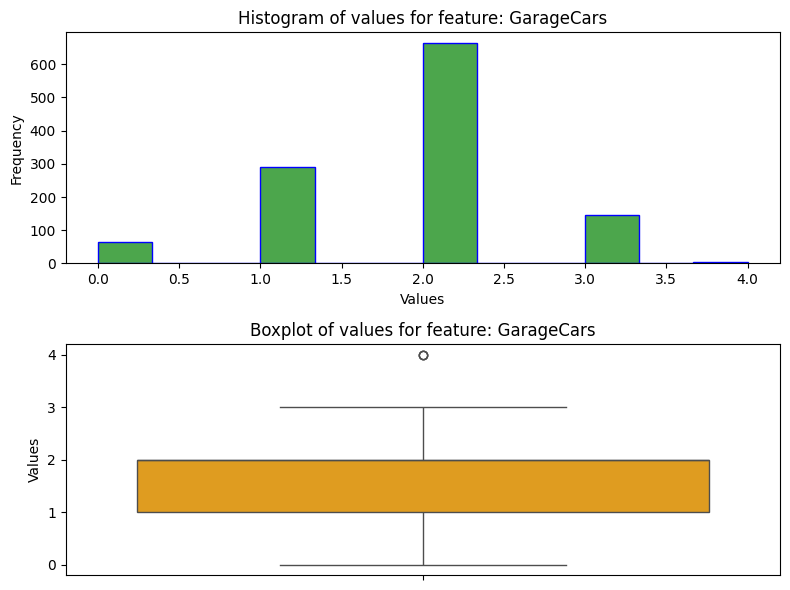



Feature: GarageArea

Info:
Number of nulls: 0
count    1168.000000
mean      471.508517
std       236.061477
min         0.000000
25%       323.425212
50%       465.758663
75%       609.471621
max      1416.445072
Name: GarageArea, dtype: float64


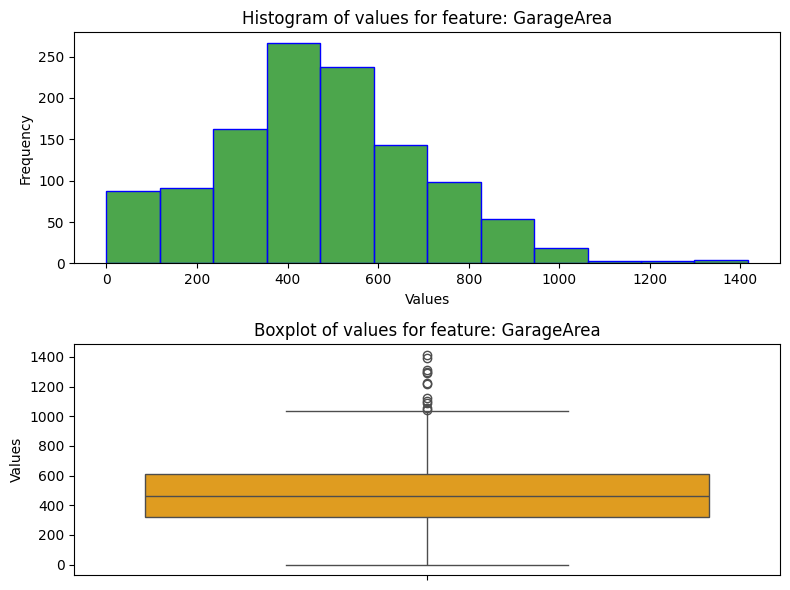



Feature: GarageQual

Info:
Number of nulls: 98
count     1070
unique       5
top         TA
freq       874
Name: GarageQual, dtype: object


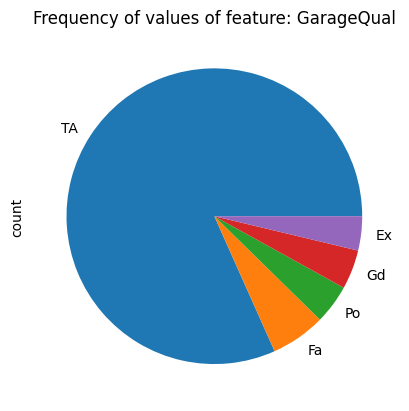



Feature: GarageCond

Info:
Number of nulls: 92
count     1076
unique       5
top         TA
freq       881
Name: GarageCond, dtype: object


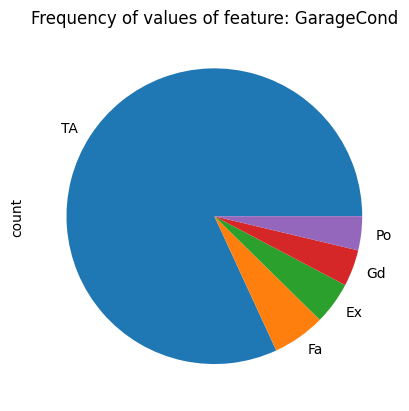



Feature: PavedDrive

Info:
Number of nulls: 0
count     1168
unique       3
top          Y
freq       950
Name: PavedDrive, dtype: object


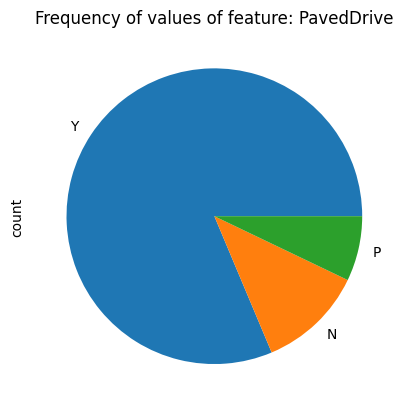



Feature: WoodDeckSF

Info:
Number of nulls: 0
count    1168.000000
mean      107.474930
std       123.680720
min         0.000000
25%         0.000000
50%        63.727854
75%       178.363995
max       890.949583
Name: WoodDeckSF, dtype: float64


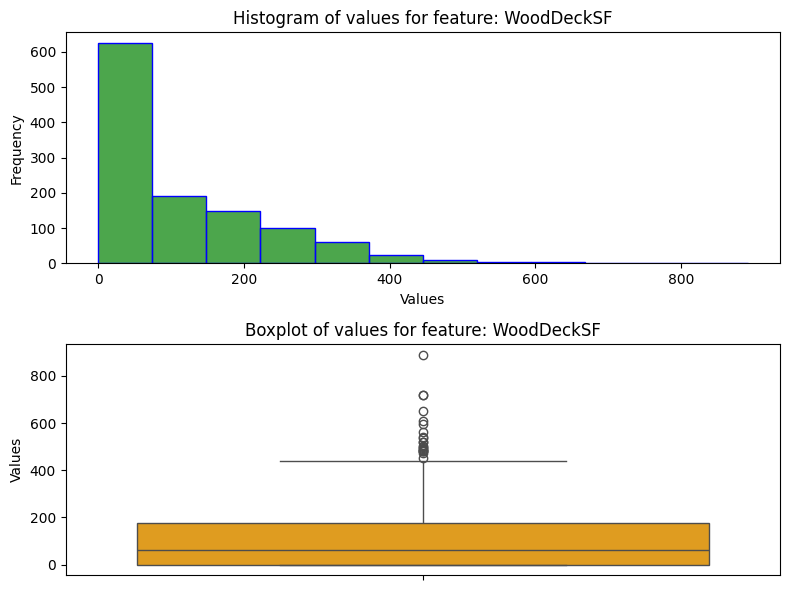



Feature: OpenPorchSF

Info:
Number of nulls: 0
count    1168.000000
mean       53.184235
std        64.892561
min         0.000000
25%         3.121553
50%        32.381911
75%        75.579627
max       542.204592
Name: OpenPorchSF, dtype: float64


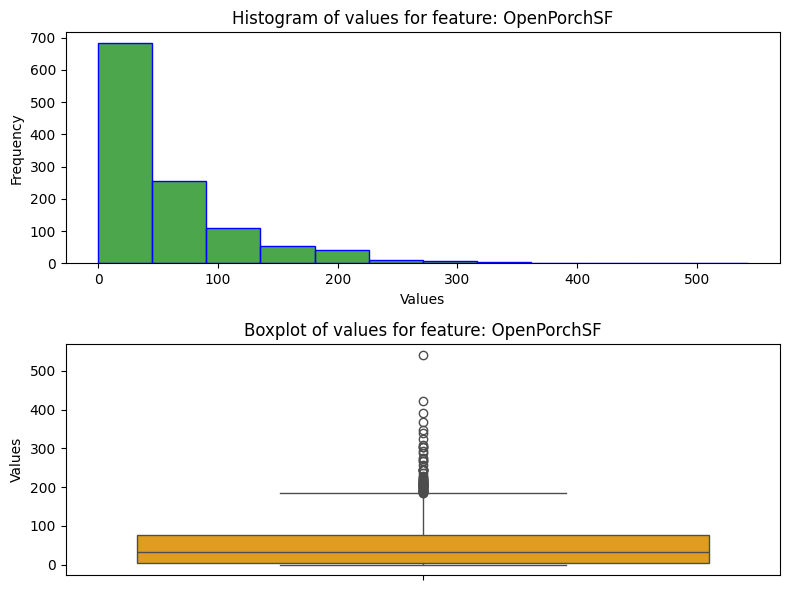



Feature: EnclosedPorch

Info:
Number of nulls: 0
count    1168.000000
mean       33.603085
std        61.875214
min         0.000000
25%         0.000000
50%         7.361691
75%        33.507896
max       527.329955
Name: EnclosedPorch, dtype: float64


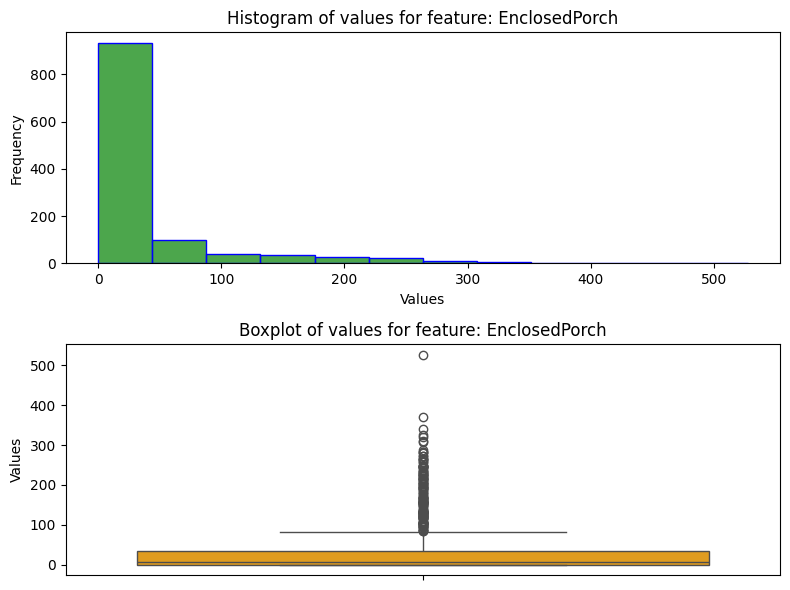



Feature: 3SsnPorch

Info:
Number of nulls: 0
count    1168.000000
mean        8.676948
std        27.845960
min         0.000000
25%         0.000000
50%         0.246591
75%        10.640647
max       512.904641
Name: 3SsnPorch, dtype: float64


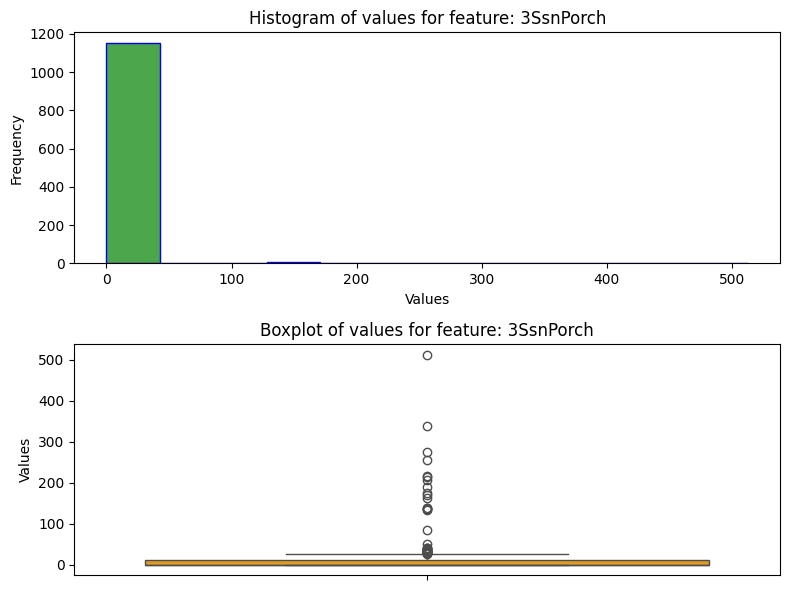



Feature: ScreenPorch

Info:
Number of nulls: 0
count    1168.000000
mean       25.502434
std        57.068714
min         0.000000
25%         0.000000
50%         2.247700
75%        22.678792
max       427.803168
Name: ScreenPorch, dtype: float64


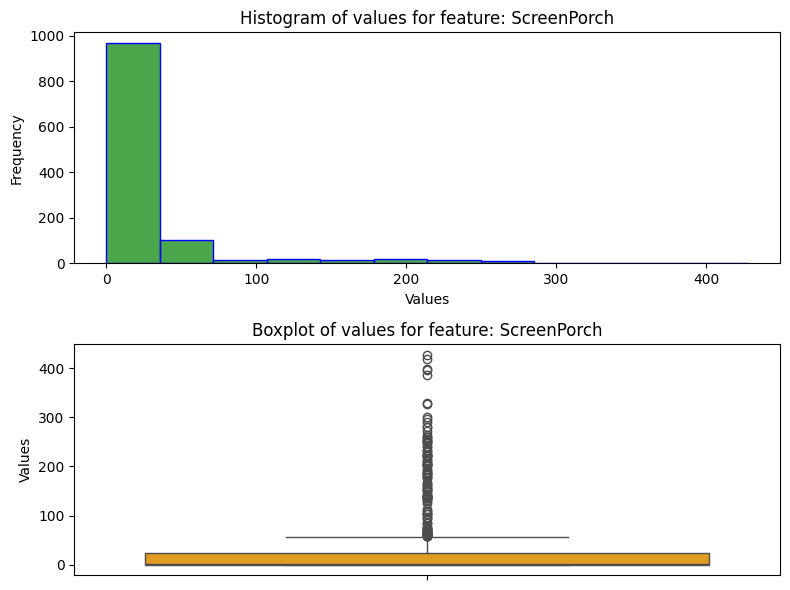



Feature: PoolArea

Info:
Number of nulls: 0
count    1168.000000
mean       11.801869
std        46.459399
min         0.000000
25%         0.000000
50%         0.273856
75%        14.832141
max       750.180075
Name: PoolArea, dtype: float64


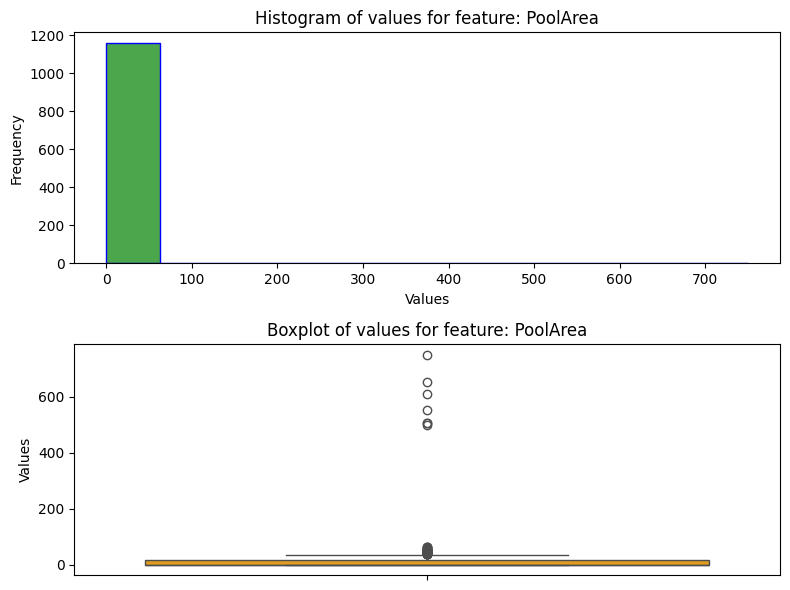



Feature: PoolQC

Info:
Number of nulls: 962
count     206
unique      3
top        Ex
freq       79
Name: PoolQC, dtype: object


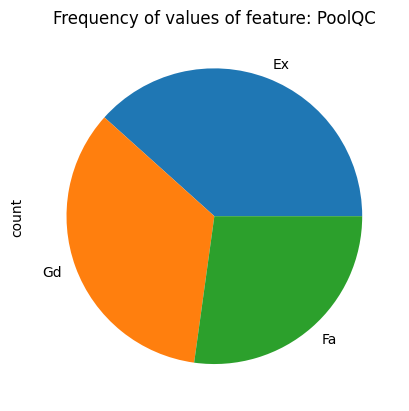



Feature: Fence

Info:
Number of nulls: 786
count       382
unique        4
top       MnPrv
freq        155
Name: Fence, dtype: object


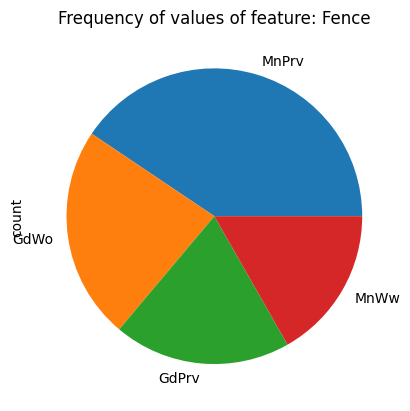



Feature: MiscFeature

Info:
Number of nulls: 957
count      211
unique       4
top       Shed
freq        75
Name: MiscFeature, dtype: object


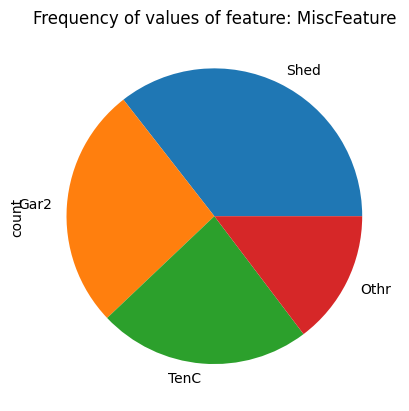



Feature: MiscVal

Info:
Number of nulls: 0
count     1168.000000
mean       142.319057
std        549.310486
min          0.000000
25%          0.000000
50%          0.000000
75%        195.233326
max      15331.124741
Name: MiscVal, dtype: float64


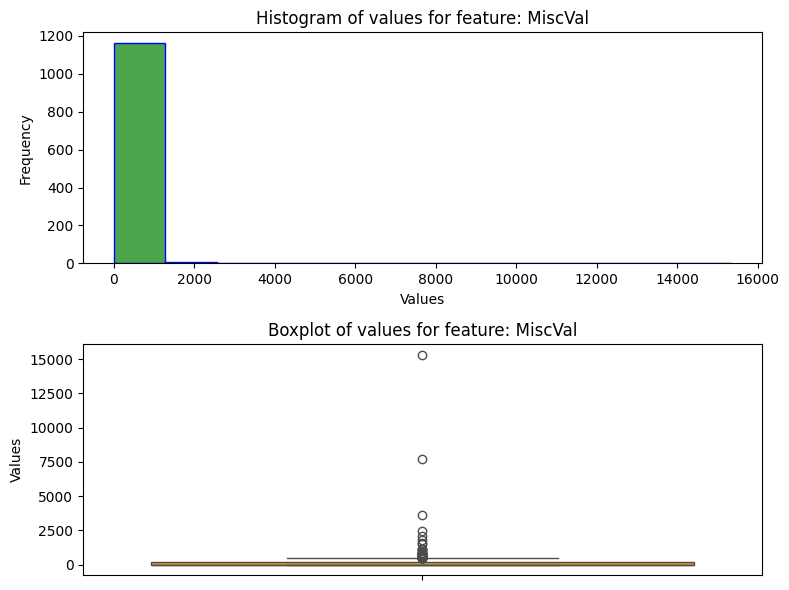



Feature: MoSold

Info:
Number of nulls: 0
count    1168.000000
mean        6.361301
std         2.701285
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64


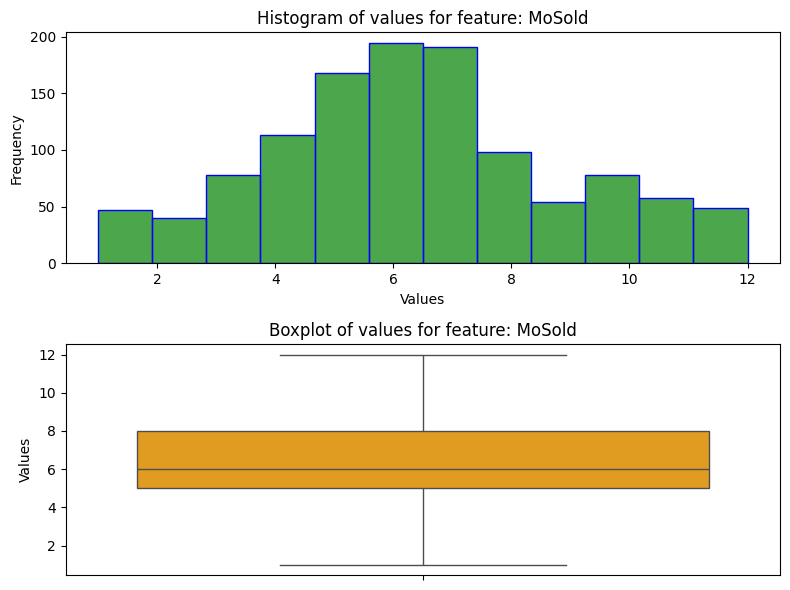



Feature: YrSold

Info:
Number of nulls: 0
count    1168.000000
mean     2007.803082
std         1.330130
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64


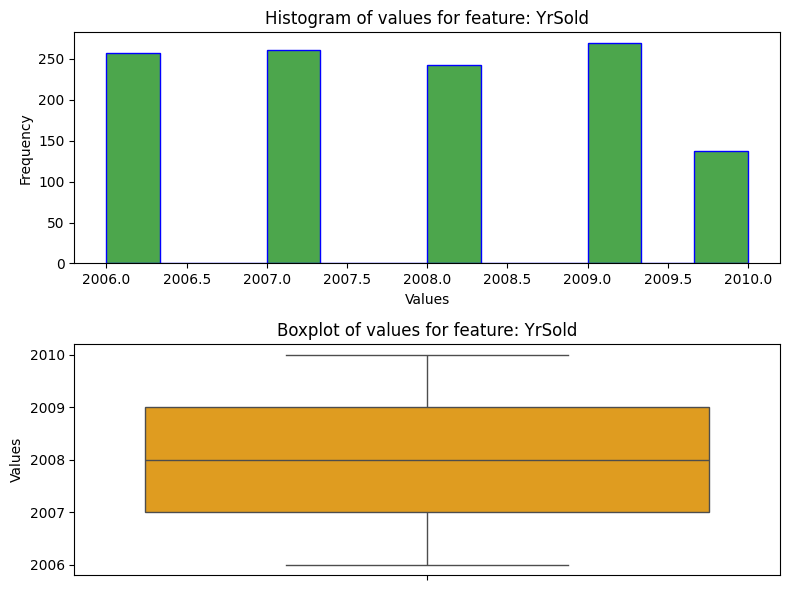



Feature: SaleType

Info:
Number of nulls: 0
count     1168
unique       9
top         WD
freq       828
Name: SaleType, dtype: object


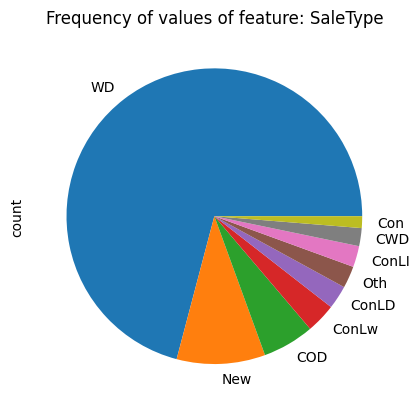



Feature: SaleCondition

Info:
Number of nulls: 0
count       1168
unique         6
top       Normal
freq         809
Name: SaleCondition, dtype: object


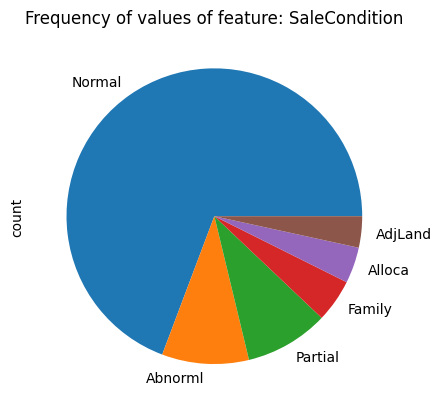



Feature: SalePrice

Info:
Number of nulls: 0
count      1168.000000
mean     181982.786079
std       89206.602744
min        3573.797098
25%      127019.572086
50%      166082.959443
75%      224867.542569
max      756590.767461
Name: SalePrice, dtype: float64


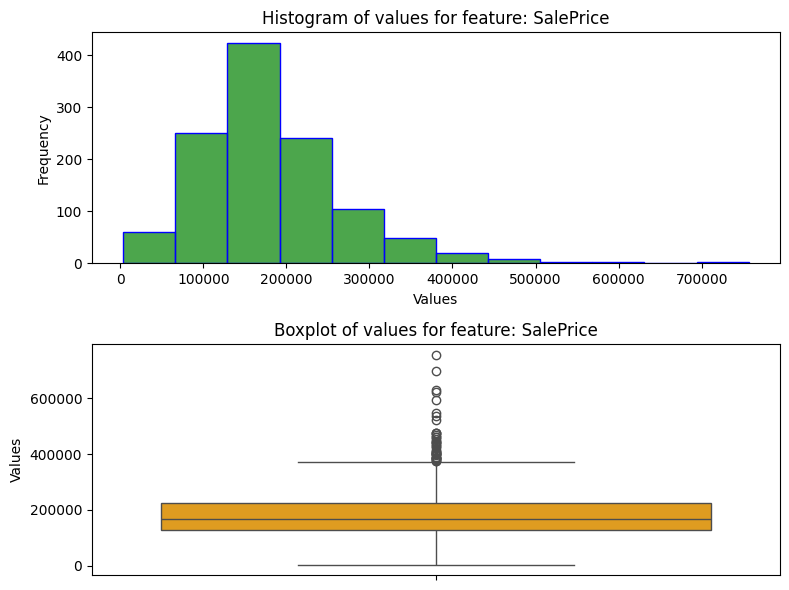

In [12]:
def explore_features(data):
    cols = data.columns.tolist()
    for col in cols:
        print('Feature: %s' % (col))
        print('\nInfo:')
        print('Number of nulls: %s' % (data[col].isna().sum()))
        print(data[col].describe())

        if data[col].dtype == 'object':
            # Filter out certain values if necessary for object types
            filtered_feature = data[(data[col] != "unknown") & (data[col] != "?") & (data[col] != "NaN")]
            plt.title("Frequency of values of feature: %s" % col)
            filtered_feature[col].value_counts().plot(kind='pie')
            plt.show()

        else:
            # For numeric (non-object) features, plot a histogram and boxplot
            feature = data[col].dropna()

            plt.figure(figsize=(8, 6))

            # Plot histogram
            plt.subplot(2, 1, 1)
            sns.histplot(feature, bins=12, color='green', alpha=0.7, edgecolor='blue')
            plt.title("Histogram of values for feature: %s" % col)
            plt.xlabel('Values')
            plt.ylabel('Frequency')

            # Plot boxplot
            plt.subplot(2, 1, 2)
            sns.boxplot(y=feature, color='orange')
            plt.title("Boxplot of values for feature: %s" % col)
            plt.ylabel('Values')

            plt.tight_layout()
            plt.show()

        print('\n')

explore_features(train_set)

#Part B2 - Features Removal

## Alley

### We decided to remove this feature since most of the properties don't have it (957 out of 1168 have 'null' value), and we believe it doesn't have added value compared to the feature 'Street'.

In [13]:
train_set.drop(['Alley'],axis=1,inplace = True)
test_set.drop(['Alley'],axis=1,inplace = True)

## ExterQual

### It seems this feature doesn't provide too much informative variance, since all the values are between 'fair' to 'excellent' (it was maybe possible to learn something if we had samples with the grade of 'poor').

In [14]:
train_set.drop(['ExterQual'],axis=1,inplace = True)
test_set.drop(['ExterQual'],axis=1,inplace = True)

## BsmtQual

### Similarly to 'exterior quality', there is nothing to learn from this feature. All the values are between 'fair' to 'excellent', the variance isn't sufficient.

In [15]:
train_set.drop(['BsmtQual'],axis=1,inplace = True)
test_set.drop(['BsmtQual'],axis=1,inplace = True)

## BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF

### The aggregation of the square-feet area of BsmtFinSF1,BsmtFinSF2,BsmtUnfSF is already considered in another feature we have - TotalBsmtSF. From the correlation matrix it seems there is low correlation between the 3 'partial' feature to the price, while the aggregated feature (TotalBsmtSF) has almost 50% correlation to the price. In order to simplify the model, we decided to drop these, with their subjective categorical features.

In [16]:
train_set.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'],axis=1,inplace = True)
test_set.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'],axis=1,inplace = True)

In [17]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    963 non-null    float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   LotShape       1168 non-null   object 
 6   LandContour    1168 non-null   object 
 7   Utilities      1168 non-null   object 
 8   LotConfig      1168 non-null   object 
 9   LandSlope      1168 non-null   object 
 10  Neighborhood   1168 non-null   object 
 11  Condition1     1168 non-null   object 
 12  Condition2     1168 non-null   object 
 13  BldgType       1168 non-null   object 
 14  HouseStyle     1168 non-null   object 
 15  OverallQual    1168 non-null   int64  
 16  OverallCond    1168 non-null   int64  
 17  YearBuilt      1168 non-null   float64
 18  YearRemo

## KitchenQual

### No varianve - All the rankings are between 'fair' and 'excellent'

In [18]:
train_set.drop(['KitchenQual'],axis=1,inplace = True)
test_set.drop(['KitchenQual'],axis=1,inplace = True)

## FireplaceQu

### In this case there is some relevant information ('poor'), but there are too many missing values - around 50% of the data is missing. It's hard to conclude something with this amount of missing samples.

In [19]:
train_set.drop(['FireplaceQu'],axis=1,inplace = True)
test_set.drop(['FireplaceQu'],axis=1,inplace = True)

## PoolQC

### No variance - All the rankings are between 'fair' and 'excellent' (and there are a lot of nulls also for houses that do have a pool)

In [20]:
train_set.drop(['PoolQC'],axis=1,inplace = True)
test_set.drop(['PoolQC'],axis=1,inplace = True)

## Fence

### 786 nulls, it's hard to conclude something with this amount of missing values

In [21]:
train_set.drop(['Fence'],axis=1,inplace = True)
test_set.drop(['Fence'],axis=1,inplace = True)

In [22]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    963 non-null    float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   LotShape       1168 non-null   object 
 6   LandContour    1168 non-null   object 
 7   Utilities      1168 non-null   object 
 8   LotConfig      1168 non-null   object 
 9   LandSlope      1168 non-null   object 
 10  Neighborhood   1168 non-null   object 
 11  Condition1     1168 non-null   object 
 12  Condition2     1168 non-null   object 
 13  BldgType       1168 non-null   object 
 14  HouseStyle     1168 non-null   object 
 15  OverallQual    1168 non-null   int64  
 16  OverallCond    1168 non-null   int64  
 17  YearBuilt      1168 non-null   float64
 18  YearRemo

## GarageQual / GarageCond

### We checked if there is a large matching between this feature and GarageCond. The script below shows there is no large correlation in the extreme categories, so we leave them for now until we convert these features to numeric and explore the correlations.

In [23]:
# Count rows where both GarageQual and GarageCond are 'Poor'
count_poor_poor = ((train_set['GarageQual'] == 'Po') & (train_set['GarageCond'] == 'Po')).sum()

# Count rows where both GarageQual and GarageCond are 'TA'
count_excellent_excellent = ((train_set['GarageQual'] == 'Ex') & (train_set['GarageCond'] == 'Ex')).sum()

print("Number of rows with 'Poor' for both GarageQual and GarageCond:", count_poor_poor)
print("Number of rows with 'Excellent' for both GarageQual and GarageCond:", count_excellent_excellent)

Number of rows with 'Poor' for both GarageQual and GarageCond: 1
Number of rows with 'Excellent' for both GarageQual and GarageCond: 3


## TotRmsAbvGrd

### This feature is highly correlative with the feature GrLivArea (0.74 - we set our threshold at ~0.75). We chose to drop it and not GrLivArea because GrLivArea is more correlative with the price (0.52 in comparison with 0.45), and because TotRmsAbvGrd has relatively high correlation (around 0.6-0.65) with other features as well, so it seems like the more redundant feature.

In [24]:
train_set.drop(['TotRmsAbvGrd'],axis=1,inplace = True)
test_set.drop(['TotRmsAbvGrd'],axis=1,inplace = True)

## GarageArea

### This feature is highly correlative with the feature GarageCars (0.79 - we set our threshold at ~0.75). We chose to drop it and not GarageCars because GarageCars is more correlative with the price (0.57 in comparison with 0.52).

In [25]:
train_set.drop(['GarageArea'],axis=1,inplace = True)
test_set.drop(['GarageArea'],axis=1,inplace = True)

In [26]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    963 non-null    float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   LotShape       1168 non-null   object 
 6   LandContour    1168 non-null   object 
 7   Utilities      1168 non-null   object 
 8   LotConfig      1168 non-null   object 
 9   LandSlope      1168 non-null   object 
 10  Neighborhood   1168 non-null   object 
 11  Condition1     1168 non-null   object 
 12  Condition2     1168 non-null   object 
 13  BldgType       1168 non-null   object 
 14  HouseStyle     1168 non-null   object 
 15  OverallQual    1168 non-null   int64  
 16  OverallCond    1168 non-null   int64  
 17  YearBuilt      1168 non-null   float64
 18  YearRemo

#**Part C - Filling Missing Values**



### All in all, we have remaining features with missing values. We'll see how we handled them.

## LotFrontage

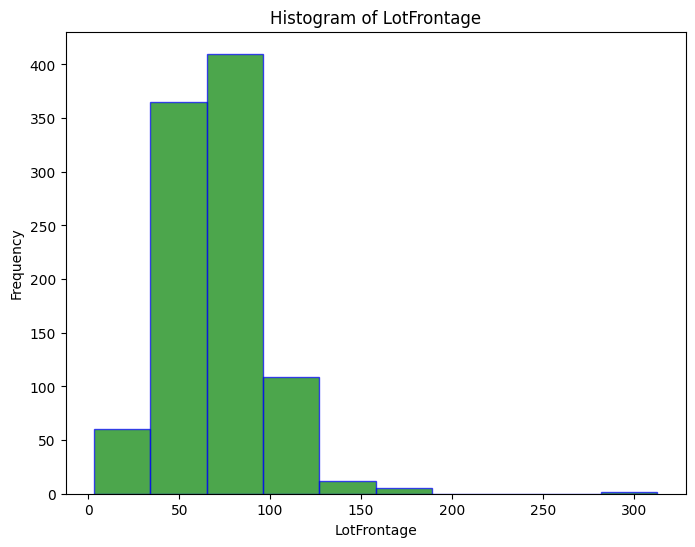

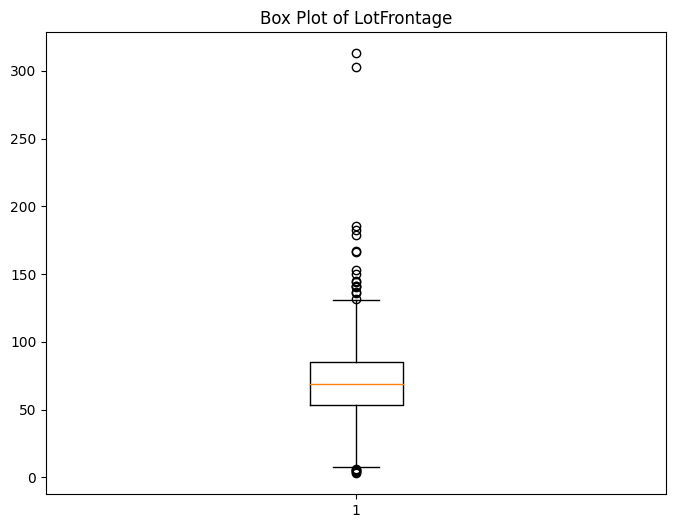

Descriptive Statistics for LotFrontage:
count    963.000000
mean      70.096183
std       27.670641
min        3.062877
25%       53.523116
50%       69.171416
75%       84.832822
max      312.997838
Name: LotFrontage, dtype: float64
Number of NaN values in LotFrontage: 205


In [27]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['LotFrontage'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of LotFrontage')
plt.xlabel('LotFrontage')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['LotFrontage'].dropna())
plt.title('Box Plot of LotFrontage')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for LotFrontage:")
print(train_set['LotFrontage'].describe())

# Count NaN values
nan_count = train_set['LotFrontage'].isna().sum()
print(f"Number of NaN values in LotFrontage: {nan_count}")

### It appears that this feature distributes almost perfectly normal (mean and median are very close). Then, we can fill the missing values with the median.

In [28]:
train_set['LotFrontage'].fillna(train_set['LotFrontage'].mean(), inplace=True)
test_set['LotFrontage'].fillna(test_set['LotFrontage'].mean(), inplace=True)

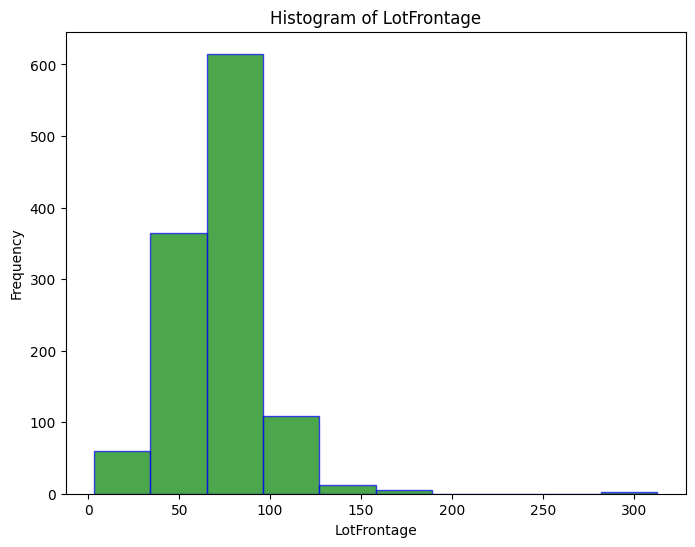

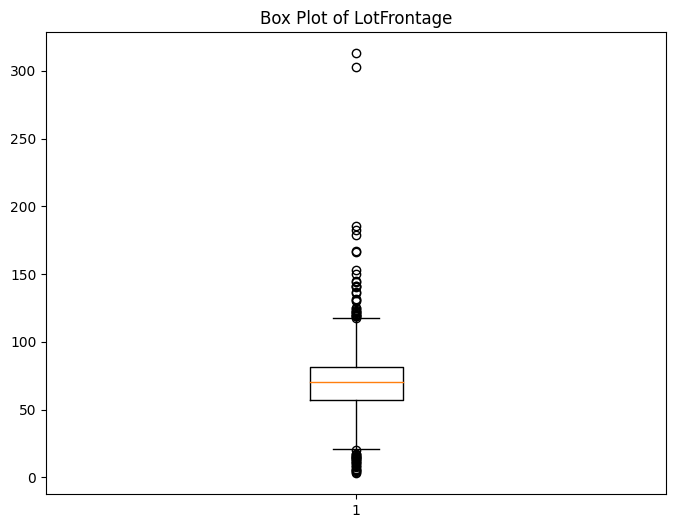

Descriptive Statistics for LotFrontage:
count    1168.000000
mean       70.096183
std        25.122990
min         3.062877
25%        56.802437
50%        70.096183
75%        81.184836
max       312.997838
Name: LotFrontage, dtype: float64
Number of NaN values in LotFrontage: 0


In [29]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['LotFrontage'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of LotFrontage')
plt.xlabel('LotFrontage')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['LotFrontage'].dropna())
plt.title('Box Plot of LotFrontage')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for LotFrontage:")
print(train_set['LotFrontage'].describe())

# Count NaN values
nan_count = train_set['LotFrontage'].isna().sum()
print(f"Number of NaN values in LotFrontage: {nan_count}")

## MasVnrType

In [30]:
train_set['MasVnrType'].value_counts(dropna=False)

MasVnrType
NaN        649
BrkFace    342
Stone      125
BrkCmn      52
Name: count, dtype: int64

### Notice that the next feature, MasVnrArea, has only 6 missing values and is strongly connected to MasVnrType. So I implemented Conditional Imputation - if the area is 0 and the value is NaN, we'll replace it in 'None'. If the area is larger than 0 - we'll replace it with 'BrkFace' (the most common material with the non 'None' in the list.

In [31]:
# Identify rows with missing 'MasVnrType' and non-zero 'MasVnrArea'
mask_missing_type = train_set['MasVnrType'].isna()
mask_nonzero_area = train_set['MasVnrArea'] > 0

# Update 'MasVnrType' based on conditions
train_set.loc[mask_missing_type & (train_set['MasVnrArea'] == 0), 'MasVnrType'] = 'None'
train_set.loc[mask_missing_type & mask_nonzero_area, 'MasVnrType'] = 'BrkFace'


mask_missing_type = test_set['MasVnrType'].isna()
mask_nonzero_area = test_set['MasVnrArea'] > 0
test_set.loc[mask_missing_type & (test_set['MasVnrArea'] == 0), 'MasVnrType'] = 'None'
test_set.loc[mask_missing_type & mask_nonzero_area, 'MasVnrType'] = 'BrkFace'

In [32]:
train_set['MasVnrType'].value_counts(dropna=False)

MasVnrType
BrkFace    683
None       303
Stone      125
BrkCmn      52
NaN          5
Name: count, dtype: int64

## MasVnrArea

### First - we have only 6 missing values in this feature, so we want to take a closer look on the rows that are missing this values (it seems that they are missing also the MasVnrType).

In [33]:
# Filter rows where 'MasVnrArea' is NaN
missing_area_rows = train_set[train_set['MasVnrArea'].isna()]

# Now 'missing_area_rows' contains all rows where 'MasVnrArea' is missing (NaN)
print(missing_area_rows)

     MSSubClass MSZoning  LotFrontage       LotArea Street LotShape  \
356          85       RH    71.666565   5400.131858   Pave      Reg   
437          20       RL    70.096183  30615.719198   Pave      IR1   
504          60       RL    70.096183  10867.361200   Pave      Reg   
612         120       FV    23.346906   9830.999482   Pave      IR1   
695          20       FV    63.336866  20146.175871   Pave      Reg   
771         120       RL    94.250761   6408.019818   Pave      Reg   

    LandContour Utilities LotConfig LandSlope  ...  3SsnPorch ScreenPorch  \
356         Lvl    AllPub    Inside       Gtl  ...   0.000000    2.302990   
437         Low    AllPub   CulDSac       Gtl  ...   0.000000    0.000000   
504         Lvl    AllPub    Inside       Gtl  ...  13.390695    0.000000   
612         Lvl    AllPub    Inside       Mod  ...   0.000000    1.762384   
695         Lvl    AllPub       FR3       Sev  ...  21.209346   74.972229   
771         Lvl    AllPub    Inside     

### These samples look valid, it just that in 5 out of 6 there are Nans both in MasVnrArea and MasVnrType. Let's see how MasVnrArea distributes.

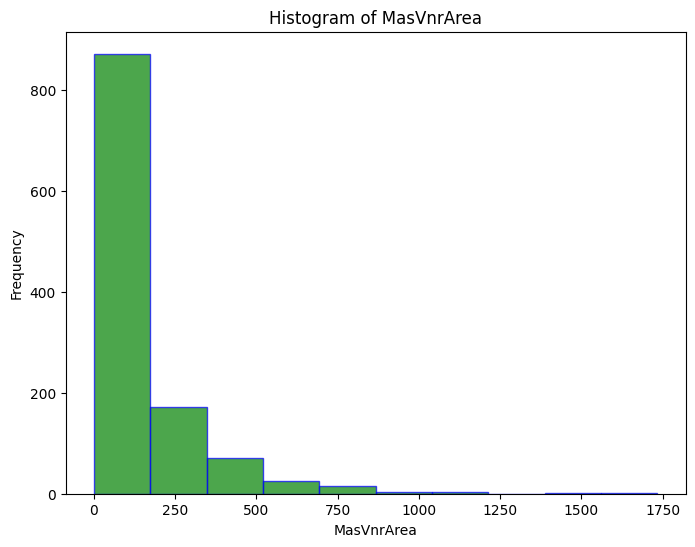

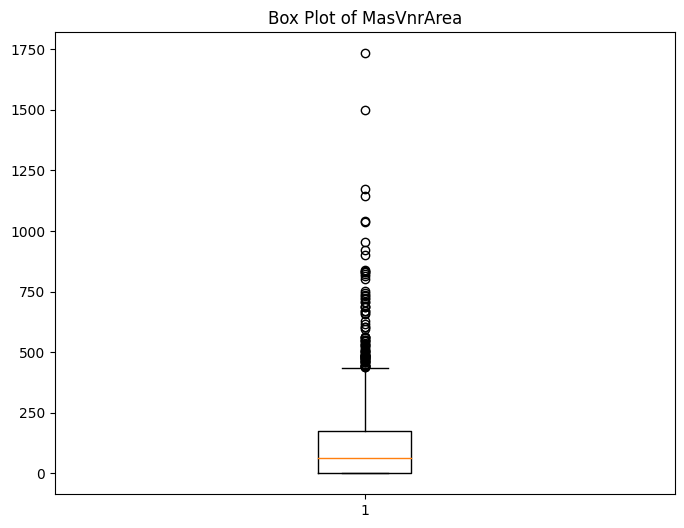

Descriptive Statistics for MasVnrArea:
count    1162.000000
mean      127.481016
std       185.051860
min         0.000000
25%         0.000000
50%        61.139121
75%       174.233091
max      1733.701541
Name: MasVnrArea, dtype: float64
Number of NaN values in MasVnrArea: 6


In [34]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['MasVnrArea'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of MasVnrArea')
plt.xlabel('MasVnrArea')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['MasVnrArea'].dropna())
plt.title('Box Plot of MasVnrArea')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for MasVnrArea:")
print(train_set['MasVnrArea'].describe())

# Count NaN values
nan_count = train_set['MasVnrArea'].isna().sum()
print(f"Number of NaN values in MasVnrArea: {nan_count}")

### It seems reasonable to assume that the missing values in 5 out of the 6 indicate that there is no Masonry veneer at all. So we'll fill the values in 0 for MasVnrArea and 'None' for MasVnrType.

In [35]:
# Filter rows where both 'MasVnrArea' and 'MasVnrType' are NaN
mask = train_set['MasVnrArea'].isna() & train_set['MasVnrType'].isna()

# Fill NaN values with 0 for 'MasVnrArea' and 'None' for 'MasVnrType'
train_set.loc[mask, 'MasVnrArea'] = 0
train_set.loc[mask, 'MasVnrType'] = 'None'

# Filter rows where both 'MasVnrArea' and 'MasVnrType' are NaN
mask = test_set['MasVnrArea'].isna() & test_set['MasVnrType'].isna()

# Fill NaN values with 0 for 'MasVnrArea' and 'None' for 'MasVnrType'
test_set.loc[mask, 'MasVnrArea'] = 0
test_set.loc[mask, 'MasVnrType'] = 'None'

In [36]:
train_set['MasVnrType'].value_counts(dropna=False)

MasVnrType
BrkFace    683
None       308
Stone      125
BrkCmn      52
Name: count, dtype: int64

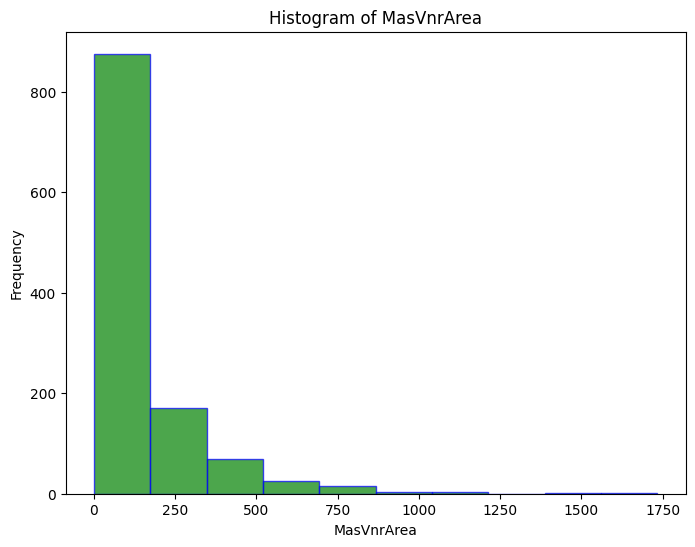

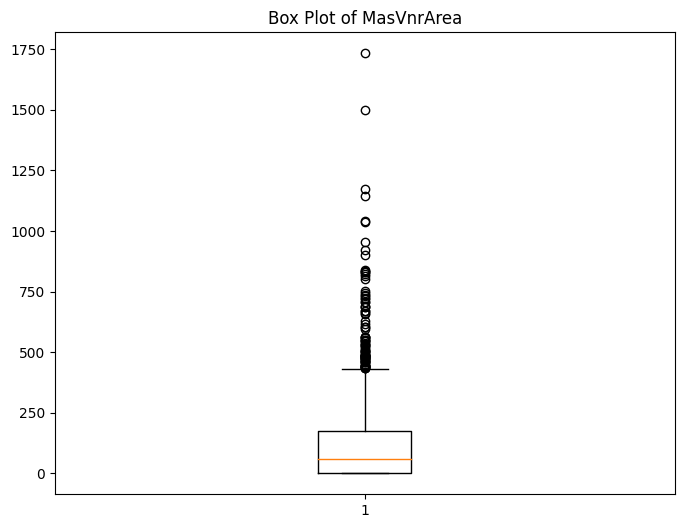

Descriptive Statistics for MasVnrArea:
count    1167.000000
mean      126.934824
std       184.842464
min         0.000000
25%         0.000000
50%        60.630699
75%       172.922912
max      1733.701541
Name: MasVnrArea, dtype: float64
Number of NaN values in MasVnrArea: 1


In [37]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['MasVnrArea'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of MasVnrArea')
plt.xlabel('MasVnrArea')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['MasVnrArea'].dropna())
plt.title('Box Plot of MasVnrArea')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for MasVnrArea:")
print(train_set['MasVnrArea'].describe())

# Count NaN values
nan_count = train_set['MasVnrArea'].isna().sum()
print(f"Number of NaN values in MasVnrArea: {nan_count}")

### We'll fill the missing value of MasVnrArea with the median (it's only one value, probably it won't make a big difference eventhough this feature doesn't distributes normally).

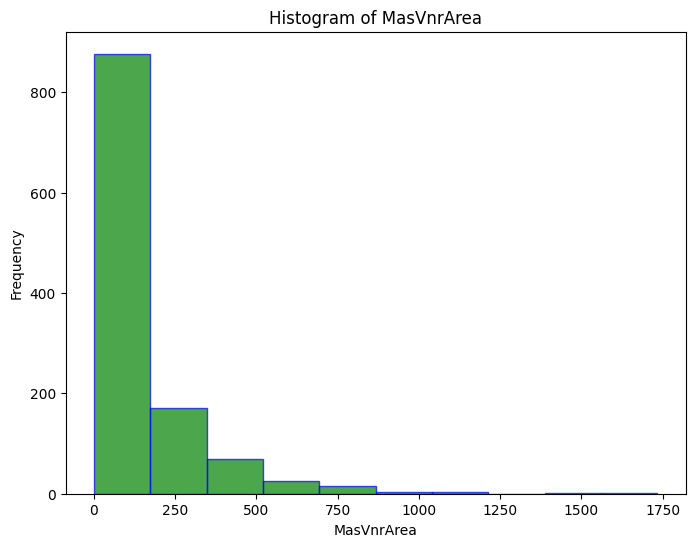

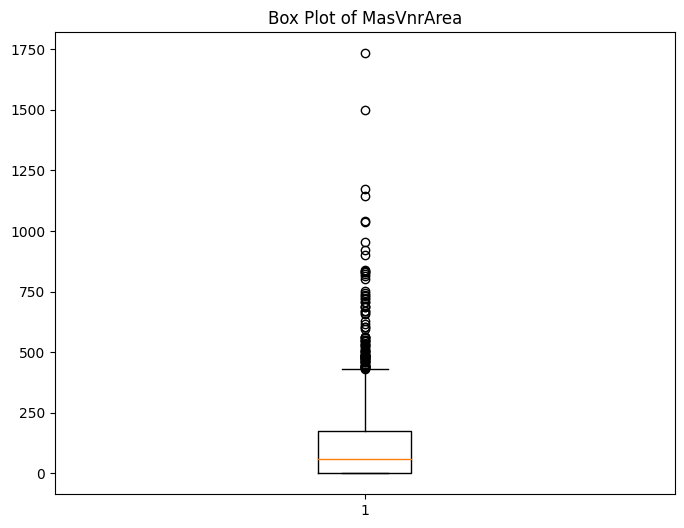

Descriptive Statistics for MasVnrArea:
count    1168.000000
mean      126.934824
std       184.763251
min         0.000000
25%         0.000000
50%        60.745559
75%       172.829563
max      1733.701541
Name: MasVnrArea, dtype: float64
Number of NaN values in MasVnrArea: 0


In [38]:
train_set['MasVnrArea'].fillna(train_set['MasVnrArea'].mean(), inplace=True)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['MasVnrArea'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of MasVnrArea')
plt.xlabel('MasVnrArea')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['MasVnrArea'].dropna())
plt.title('Box Plot of MasVnrArea')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for MasVnrArea:")
print(train_set['MasVnrArea'].describe())

# Count NaN values
nan_count = train_set['MasVnrArea'].isna().sum()
print(f"Number of NaN values in MasVnrArea: {nan_count}")

## BsmtExposure

In [39]:
train_set['BsmtExposure'].value_counts(dropna=False)

BsmtExposure
No     647
Av     190
Gd     146
Mn     118
NaN     67
Name: count, dtype: int64

### It seems that the exposure level is partially related to the total Square feet of basements - basements with SF of 0 obviously can't have any exposure. We'll replace the missing BsmtExposure with the TotalBsmtSF of 0 with 'No', and the rest with the mode value of the existing 'BsmtExposure' categories (which is also 'No'...)

In [40]:
# Find rows where 'BsmtExposure' is NaN and 'TotalBsmtSF' is zero
missing_exposure = train_set[(train_set['BsmtExposure'].isna()) & (train_set['TotalBsmtSF'] == 0)]

# Fill 'BsmtExposure' with 'No' for these rows
train_set.loc[missing_exposure.index, 'BsmtExposure'] = 'No'

# Find rows where 'BsmtExposure' is still NaN
remaining_missing = train_set[train_set['BsmtExposure'].isna()]

# Fill remaining missing 'BsmtExposure' with the mode value
mode_value = train_set['BsmtExposure'].mode()[0]
train_set['BsmtExposure'].fillna(mode_value, inplace=True)
test_set['BsmtExposure'].fillna(mode_value, inplace=True)

# Print updated value counts to verify
print(train_set['BsmtExposure'].value_counts())

BsmtExposure
No    714
Av    190
Gd    146
Mn    118
Name: count, dtype: int64


## BsmtCond

In [41]:
train_set['BsmtCond'].value_counts(dropna=False)

BsmtCond
TA     881
Gd      91
NaN     74
Fa      73
Po      49
Name: count, dtype: int64

### Clearly a large majority of the values is 'TA', so we'll replace the missing values with the mode.

In [42]:
# Find rows where 'BsmtCond' is NaN
missing = train_set[train_set['BsmtCond'].isna()]

# Fill missing 'BsmtCond' with the mode value
mode_value = train_set['BsmtCond'].mode()[0]
train_set['BsmtCond'].fillna(mode_value, inplace=True)
test_set['BsmtCond'].fillna(mode_value, inplace=True)

# Print updated value counts to verify
print(train_set['BsmtCond'].value_counts())

BsmtCond
TA    955
Gd     91
Fa     73
Po     49
Name: count, dtype: int64


## Electrical

In [43]:
train_set['Electrical'].value_counts(dropna=False)

Electrical
SBrkr    907
FuseA     98
FuseF     52
NaN       44
FuseP     34
Mix       33
Name: count, dtype: int64

### Clearly a large majority of the values is 'SBrkr', so we'll replace the missing values with the mode.

In [44]:
# Find rows where 'Electrical' is NaN
missing = train_set[train_set['Electrical'].isna()]

# Fill missing 'Electrical' with the mode value
mode_value = train_set['Electrical'].mode()[0]
train_set['Electrical'].fillna(mode_value, inplace=True)
test_set['Electrical'].fillna(mode_value, inplace=True)

# Print updated value counts to verify
print(train_set['Electrical'].value_counts())

Electrical
SBrkr    951
FuseA     98
FuseF     52
FuseP     34
Mix       33
Name: count, dtype: int64


## GarageType

In [45]:
train_set['GarageType'].value_counts(dropna=False)

GarageType
Attchd     581
Detchd     273
BuiltIn     99
NaN         80
Basment     58
CarPort     44
2Types      33
Name: count, dtype: int64

### We can compare this feature with the GarageCars feature. If GarageCars values is 0, it makes sense to replace the missing values with 'NA' (no garage).

In [46]:
# Filter rows with NaN GarageType and 0 GarageCars
filtered_rows = train_set[(train_set['GarageType'].isna()) & (train_set['GarageCars'] == 0)]

# Replace NaN GarageType with 'NA' for the filtered rows
train_set.loc[filtered_rows.index, 'GarageType'] = 'NA'

# Display updated value counts of GarageType to verify the replacement
print("\nUpdated GarageType Value Counts:")
print(train_set['GarageType'].value_counts())


Updated GarageType Value Counts:
GarageType
Attchd     581
Detchd     273
BuiltIn     99
Basment     58
NA          55
CarPort     44
2Types      33
Name: count, dtype: int64


In [47]:
# Select rows where 'GarageType' is still NaN
remaining_nan_rows = train_set[train_set['GarageType'].isna()]
print("Rows with NaN GarageType:")
print(remaining_nan_rows)

Rows with NaN GarageType:
      MSSubClass MSZoning  LotFrontage       LotArea Street LotShape  \
114           60       RL    89.434185   7869.264147   Pave      IR1   
126           20       FV    76.513485  14032.003246   Pave      Reg   
152           20       RL    67.111710  21090.913894   Pave      Reg   
170           60       FV    87.820843   9574.839283   Pave      IR1   
188          160       RL    90.843444  11112.686435   Pave      IR1   
507           75       RL    70.096183  28705.138112   Pave      IR2   
582           60       RL    73.859434   9430.000000   Pave      Reg   
605           20       RL    72.360493  13003.450318   Pave      Reg   
624           30       RM    41.756500    821.241887   Pave      IR3   
629           20       RL    83.740581  11756.827414   Pave      Reg   
706           20       RL    83.601153   6933.489009   Pave      Reg   
719           80  C (all)    70.096183  25530.728648   Pave      IR1   
727          160       RL    98.195537

### We can use 'GarageFinish' values in order to conclude what the value is supposed to be. We assumed that if the 'GarageFinish' value is not 'Fin', than it is probably detached (the most common value that is external to the house - we assume that nobody would leave with unfinished garage attached for his house for years). Otherwise, we'll say it's attached to keep the proportion.

In [48]:
# Create a mask for rows where 'GarageType' is missing
missing_garage_type_mask = train_set['GarageType'].isna()

# Replace missing 'GarageType' based on 'GarageFinish' values
train_set.loc[missing_garage_type_mask & (train_set['GarageFinish'] != 'Fin'), 'GarageType'] = 'Detchd'
train_set.loc[missing_garage_type_mask & (train_set['GarageFinish'] == 'Fin'), 'GarageType'] = 'Attchd'

# Check how many missing values were filled with 'Detchd' and 'Attchd'
filled_with_detchd = (train_set['GarageType'] == 'Detchd').sum()
filled_with_attchd = (train_set['GarageType'] == 'Attchd').sum()

print("Number of missing values filled with 'Detchd':", filled_with_detchd)
print("Number of missing values filled with 'Attchd':", filled_with_attchd)

Number of missing values filled with 'Detchd': 291
Number of missing values filled with 'Attchd': 588


## GarageYrBlt

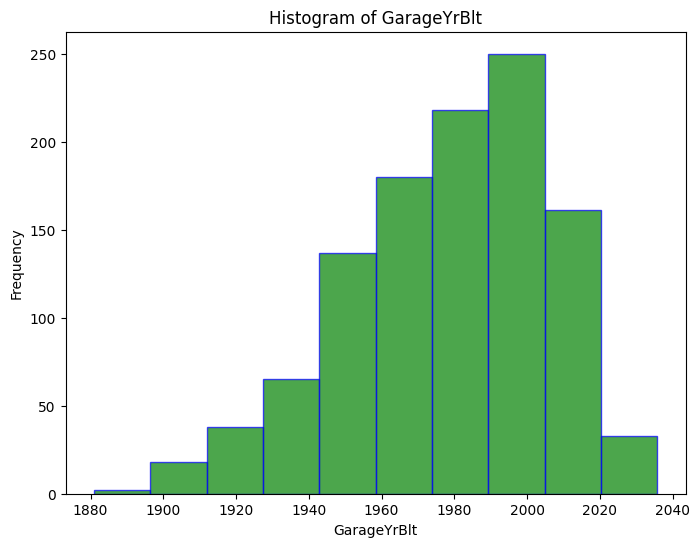

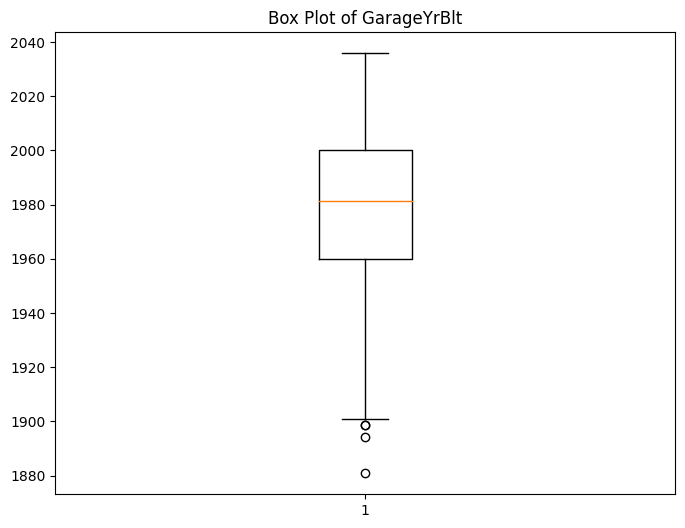

Descriptive Statistics for GarageYrBlt:
count    1102.000000
mean     1978.306305
std        27.633002
min      1880.897104
25%      1959.770816
50%      1981.287879
75%      2000.252675
max      2035.839367
Name: GarageYrBlt, dtype: float64
Number of NaN values in GarageYrBlt: 66


In [49]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(train_set['GarageYrBlt'].dropna(), bins=10, alpha=0.7, color='green', edgecolor='blue')
plt.title('Histogram of GarageYrBlt')
plt.xlabel('GarageYrBlt')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(train_set['GarageYrBlt'].dropna())
plt.title('Box Plot of GarageYrBlt')
plt.show()

# Descriptive statistics
print("Descriptive Statistics for GarageYrBlt:")
print(train_set['GarageYrBlt'].describe())

# Count NaN values
nan_count = train_set['GarageYrBlt'].isna().sum()
print(f"Number of NaN values in GarageYrBlt: {nan_count}")

### The feature GarageYrBlt has 0.67 correlation with the feature YearBuilt (we didn't remove one of them yet because this correlation was below our threshold, but it is still significant). So, it would be reasonable to assume that the garage year built will be the same as the house.

In [50]:
# Create a mask for rows where 'GarageYrBlt' is missing
missing_garage_year_mask = train_set['GarageYrBlt'].isna()

# Fill missing 'GarageYrBlt' values with 'YearBuilt'
train_set.loc[missing_garage_year_mask, 'GarageYrBlt'] = train_set.loc[missing_garage_year_mask, 'YearBuilt']

# Verify the changes
print("Number of missing values filled in 'GarageYrBlt':", train_set['GarageYrBlt'].isna().sum())

Number of missing values filled in 'GarageYrBlt': 0


## GarageFinish

In [51]:
train_set['GarageFinish'].value_counts(dropna=False)

GarageFinish
Unf    453
RFn    329
Fin    282
NaN    104
Name: count, dtype: int64

### We assume that if the value of GarageCars is 0, than the value of GarageFinish should be 'Unf'. Otherwise - we'll set it to 'RFn' (it doesn't really matter to distinguish between 'RFn' and 'Fin', because we plan to binarize this feature when we get to the feature engineering part.

In [52]:
# Create a mask for rows where 'GarageCars' is 0
zero_cars_mask = (train_set['GarageCars'] == 0)

# Fill missing 'GarageFinish' values based on 'GarageCars' values
train_set.loc[zero_cars_mask & train_set['GarageFinish'].isna(), 'GarageFinish'] = 'Unf'
train_set.loc[~zero_cars_mask & train_set['GarageFinish'].isna(), 'GarageFinish'] = 'RFn'

zero_cars_mask = (test_set['GarageCars'] == 0)
test_set.loc[zero_cars_mask & test_set['GarageFinish'].isna(), 'GarageFinish'] = 'Unf'
test_set.loc[~zero_cars_mask & test_set['GarageFinish'].isna(), 'GarageFinish'] = 'RFn'

# Verify the changes
print("Number of missing values filled in 'GarageFinish':", train_set['GarageFinish'].isna().sum())

Number of missing values filled in 'GarageFinish': 0


In [53]:
print("Number of missing values filled in 'GarageFinish':", test_set['GarageFinish'].isna().sum())

Number of missing values filled in 'GarageFinish': 0


In [54]:
train_set['GarageFinish'].value_counts(dropna=False)

GarageFinish
Unf    509
RFn    377
Fin    282
Name: count, dtype: int64

## GarageQual

In [55]:
train_set['GarageQual'].value_counts(dropna=False)

GarageQual
TA     874
NaN     98
Fa      64
Po      46
Gd      46
Ex      40
Name: count, dtype: int64

### The majority of the values is 'TA', and we plan to binarize this feature in the feature engineering part (basically we think that only 'Po' quality can change the price dramatically), so we'll just replace the missing part with the mode.

In [56]:
# Find rows where 'GarageQual' is NaN
missing = train_set[train_set['GarageQual'].isna()]

# Fill missing 'GarageQual' with the mode value
mode_value = train_set['GarageQual'].mode()[0]
train_set['GarageQual'].fillna(mode_value, inplace=True)
test_set['GarageQual'].fillna(mode_value, inplace=True)

# Print updated value counts to verify
print(train_set['GarageQual'].value_counts())

GarageQual
TA    972
Fa     64
Po     46
Gd     46
Ex     40
Name: count, dtype: int64


## GarageCond

In [57]:
train_set['GarageCond'].value_counts(dropna=False)

GarageCond
TA     881
NaN     92
Fa      62
Ex      50
Gd      43
Po      40
Name: count, dtype: int64

### The majority of the values is 'TA', and we plan to binarize this feature in the feature engineering part (basically we think that only 'Po' quality can change the price dramatically), so we'll just replace the missing part with the mode.

In [58]:
# Find rows where 'GarageCond' is NaN
missing = train_set[train_set['GarageCond'].isna()]

# Fill missing 'GarageCond' with the mode value
mode_value = train_set['GarageCond'].mode()[0]
train_set['GarageCond'].fillna(mode_value, inplace=True)

# Print updated value counts to verify
print(train_set['GarageCond'].value_counts())

GarageCond
TA    973
Fa     62
Ex     50
Gd     43
Po     40
Name: count, dtype: int64


## MiscFeature

In [59]:
train_set['MiscFeature'].value_counts(dropna=False)

MiscFeature
NaN     957
Shed     75
Gar2     56
TenC     49
Othr     31
Name: count, dtype: int64

### We need to distinguish between 2 states:
### 1. The value is NaN because of lack of usage in the category 'NA' that was created exactly to indicate if we don't have any misc feature.
### 2. The value is NaN because of a mistake.
### To know on which state we are, we can use the feature MiscVal. If the value is 0, we'll fill the missing values with 'NA'. Otherwise, we'll fill them with the value 'Othr' (doesn't really matter because we would binarize it if we indeed use it after the feature engineering).

In [60]:
# Create a mask for rows where 'MiscVal' is 0
zero_miscval_mask = (train_set['MiscVal'] == 0)

# Fill missing 'MiscFeature' values based on 'MiscVal' values
train_set.loc[zero_miscval_mask & train_set['MiscFeature'].isna(), 'MiscFeature'] = 'NA'
train_set.loc[~zero_miscval_mask & train_set['MiscFeature'].isna(), 'MiscFeature'] = 'Othr'

# Verify the changes
print("Number of missing values filled in 'MiscFeature':", train_set['MiscFeature'].isna().sum())

Number of missing values filled in 'MiscFeature': 0


In [61]:
train_set['MiscFeature'].value_counts(dropna=False)

MiscFeature
NA      501
Othr    487
Shed     75
Gar2     56
TenC     49
Name: count, dtype: int64

In [62]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    1168 non-null   float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   LotShape       1168 non-null   object 
 6   LandContour    1168 non-null   object 
 7   Utilities      1168 non-null   object 
 8   LotConfig      1168 non-null   object 
 9   LandSlope      1168 non-null   object 
 10  Neighborhood   1168 non-null   object 
 11  Condition1     1168 non-null   object 
 12  Condition2     1168 non-null   object 
 13  BldgType       1168 non-null   object 
 14  HouseStyle     1168 non-null   object 
 15  OverallQual    1168 non-null   int64  
 16  OverallCond    1168 non-null   int64  
 17  YearBuilt      1168 non-null   float64
 18  YearRemo


#**Part D - Feature Engineering**

#Part D1 - New Features

##First Feature

<Axes: xlabel='Neighborhood', ylabel='LotArea'>

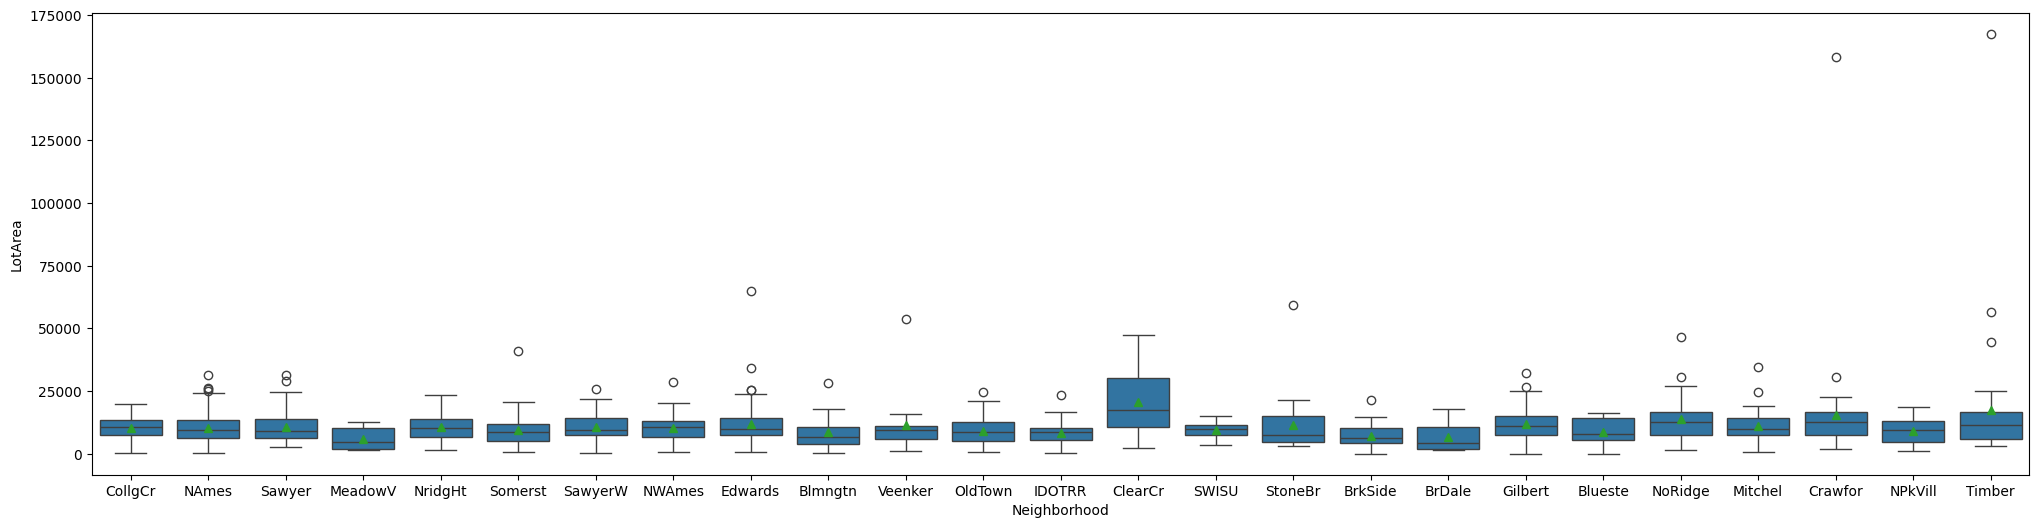

In [63]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Neighborhood",
    y = "LotArea",
    showmeans=True,
    data=train_set,
    width=0.8,

)

In [64]:
#creating a dataframe with stats about each neighborhood
neighborhood_quantile = pd.DataFrame(train_set.groupby('Neighborhood')['LotArea'].quantile(0.9)).reset_index().rename(columns = {'LotArea':'90_quantile'})
neighborhood_aggregation = pd.DataFrame(train_set.groupby(by = 'Neighborhood')['LotArea'].agg(['std', 'mean', 'size'])).reset_index()
neighborhood_aggregation = neighborhood_aggregation.merge(neighborhood_quantile, on = 'Neighborhood', how = 'inner')
neighborhood_aggregation

Neighborhood           std          mean  size   90_quantile
0       Blmngtn   6490.435433   8569.150912    21  15400.717516
1       Blueste   5667.870403   8704.903735    10  15130.768723
2        BrDale   5452.816050   6731.652753    21  14499.182816
3       BrkSide   4631.142057   7255.981153    44  13832.506920
4       ClearCr  13928.117547  20663.264771    21  41433.867867
5       CollgCr   4386.251047  10341.536186   106  15817.998109
6       Crawfor  22501.328854  15405.897741    45  19353.341906
7       Edwards   8646.874880  11914.704292    75  19441.167947
8       Gilbert   6697.042239  12026.205521    68  20279.838458
9        IDOTRR   4904.376321   8249.422342    28  11992.676013
10      MeadowV   4113.699346   5921.443458    21  11055.505361
11      Mitchel   6312.207339  10980.609747    41  18369.630788
12        NAmes   5673.494545  10180.060679   145  16752.678053
13      NPkVill   5522.323089   9133.030990    19  16613.184036
14       NWAmes   5433.701766  10383.245181    55  16590.821202
15      NoRidge   8892.954571  13775.544582    34  22804.366714
16      NridgHt   5385.139396  10594.700957    60  18724.549990
17      OldTown   5232.444679   9091.305707    77  15714.520545
18        SWISU   3166.555637   9534.059080    19  12421.397647
19       Sawyer   6257.198052  10741.488984    56  19020.520849
20      SawyerW   5604.965188  10887.142108    50  18470.563891
21      Somerst   5957.133151   9447.950436    76  15770.208478
22      StoneBr  11497.180505  11321.330939    25  19351.123636
23       Timber  27939.563923  17377.933940    36  23419.647170
24      Veenker  12381.898640  11562.654242    15  15501.862433

In [65]:
#Creating an indicator feature which indicates if an asset is luxury or not based on its Lot Area. If the asset has area that higher than 3 standard deviations (when the neighborhood has more than 30 rows),
#or if the asset has area that is higher than the 90th quantile (in a case that the neighborhood doesn't have 30 rows), then mark it as luxury.
def is_luxury(row):
  if neighborhood_aggregation.loc[neighborhood_aggregation['Neighborhood'] == row['Neighborhood']]['size'].values[0] >= 30:
    if row['LotArea'] > neighborhood_aggregation.loc[neighborhood_aggregation['Neighborhood'] == row['Neighborhood']]['mean'].values[0] + 3 *  neighborhood_aggregation.loc[neighborhood_aggregation['Neighborhood'] == row['Neighborhood']]['std'].values[0]:
      return 1
    elif row['MiscFeature'] == 'TenC' or row['MiscFeature'] == 'Elev':
      return 1
    else:
      return 0
  elif neighborhood_aggregation.loc[neighborhood_aggregation['Neighborhood'] == row['Neighborhood']]['size'].values[0] < 30:
    if row['LotArea'] > neighborhood_aggregation.loc[neighborhood_aggregation['Neighborhood'] == row['Neighborhood']]['90_quantile'].values[0]:
      return 1
    elif row['MiscFeature'] == 'TenC' or row['MiscFeature'] == 'Elev':
      return 1
    else:
      return 0
train_set['is_luxury'] = train_set.apply(lambda x: is_luxury(x), axis = 1)
test_set['is_luxury'] = test_set.apply(lambda x: is_luxury(x), axis = 1)

### All in all, we used a combination of neighborhood stats, lot area and the presence of values in MiscFeature to creat an indicator feature named 'is_luxury', to determine if we have a luxury home or not.

##Second Feature

In [66]:
###We created a new column that takes into consideration the quantile of the LotArea of each asset per neighborhood per luxury / non luxury apartments
# (using the previous feature that we created), because the area of the apartment should have impact on the sale price with common sense
new_train = pd.DataFrame()
for neighborhood in neighborhood_aggregation['Neighborhood'].values.tolist():
  non_luxury = train_set.loc[(train_set['is_luxury'] == 0) & (train_set['Neighborhood'] == neighborhood)]
  luxury = train_set.loc[(train_set['is_luxury'] == 1) & (train_set['Neighborhood'] == neighborhood)]
  for assets_df in [luxury, non_luxury]:
    assets_df['Rank'] = assets_df.groupby('Neighborhood')['LotArea'].rank()
    assets_df['AreaQuantile'] = assets_df['Rank'] / (assets_df.groupby('Neighborhood')['Rank'].transform('size') + 1)
    new_train = pd.concat([new_train, assets_df], axis = 0)

#test
new_test = pd.DataFrame()
for neighborhood in neighborhood_aggregation['Neighborhood'].values.tolist():
  non_luxury = test_set.loc[(test_set['is_luxury'] == 0) & (test_set['Neighborhood'] == neighborhood)]
  luxury = test_set.loc[(test_set['is_luxury'] == 1) & (test_set['Neighborhood'] == neighborhood)]
  for assets_df in [luxury, non_luxury]:
    assets_df['Rank'] = assets_df.groupby('Neighborhood')['LotArea'].rank()
    assets_df['AreaQuantile'] = assets_df['Rank'] / (assets_df.groupby('Neighborhood')['Rank'].transform('size') + 1)
    new_test = pd.concat([new_test, assets_df], axis = 0)

<ipython-input-66-5c2944fd4ea4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assets_df['Rank'] = assets_df.groupby('Neighborhood')['LotArea'].rank()
<ipython-input-66-5c2944fd4ea4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assets_df['AreaQuantile'] = assets_df['Rank'] / (assets_df.groupby('Neighborhood')['Rank'].transform('size') + 1)
<ipython-input-66-5c2944fd4ea4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

##Third Feature

In [67]:
#The third feature is the living room ratio out of the lot area
#We assume that large living room indicates that the apartment is more desireable
train_set['LivingRoomRatio'] = train_set['GrLivArea'] / train_set['LotArea']
test_set['LivingRoomRatio'] = test_set['GrLivArea'] / test_set['LotArea']

##Fourth Feature

In [68]:
#The fourth feature is the basement ratio out of the lot area
#assuming that larger basement might increase the price (it's an option for investors to rent the basement)
train_set['BasementRatio'] = (train_set['TotalBsmtSF']) / train_set['LotArea']
test_set['BasementRatio'] = (test_set['TotalBsmtSF'])/ test_set['LotArea']

#Part D2 - Transforming Categorical Features To Numerical

## MSZoning

In [69]:
train_set['MSZoning'].value_counts(dropna=False)

MSZoning
RL         783
RM         177
FV          96
C (all)     56
RH          56
Name: count, dtype: int64

### We think it's better to divide this classes to 3 categories: RL (aggregates the categories A, RL), RH (which will aggregate the current RM, RH, C (all) values and I), and FV (sounds like a special category).

In [70]:
# Define mapping for new categories
mapping = {
    'RL': 'RL',
    'A': 'RL',
    'RH': 'RH',
    'RM': 'RH',
    'C (all)': 'RH',
    'I': 'RH',
    'FV': 'FV'
}

# Replace 'MSZoning' values with new categories
train_set['MSZoning'] = train_set['MSZoning'].replace(mapping)
test_set['MSZoning'] = test_set['MSZoning'].replace(mapping)

# Convert categorical values to numerical values
train_set['MSZoning'] = train_set['MSZoning'].map({'RL': 0, 'RH': 1, 'FV': 2})
test_set['MSZoning'] = test_set['MSZoning'].map({'RL': 0, 'RH': 1, 'FV': 2})


# Count the occurrences of each category in the 'MSZoning' column
value_counts = train_set['MSZoning'].value_counts()

# Display the value counts
print(value_counts)

MSZoning
0    783
1    289
2     96
Name: count, dtype: int64


## Street

In [71]:
train_set['Street'].value_counts(dropna=False)

Street
Pave    1051
Grvl     117
Name: count, dtype: int64

### This feature obviously needs simple binarization

In [72]:
# Define mapping for binarization
mapping = {
    'Pave': 1,
    'Grvl': 0
}

# Binarize the 'street' column using the mapping
train_set['Street'] = train_set['Street'].map(mapping)
test_set['Street'] = test_set['Street'].map(mapping)

train_set['Street'].value_counts(dropna=False)

Street
1    1051
0     117
Name: count, dtype: int64

## LotShape

In [73]:
train_set['LotShape'].value_counts(dropna=False)

LotShape
Reg    637
IR1    370
IR2     94
IR3     67
Name: count, dtype: int64

### We think it's better to binarize this feature to 2 categories - 'generally regular' (contains 'Reg' and 'IR1'), while the moderate + irregularities will be in 2nd category.

In [74]:
# Define mapping for binarization
mapping = {
    'Reg': 1,  # Represents 'Reg' and 'IR1' as one category
    'IR1': 1,
    'IR2': 0,  # Represents 'IR2' and 'IR3' as another category
    'IR3': 0
}

# Binarize the 'LotShape' column using the mapping
train_set['LotShape'] = train_set['LotShape'].replace(mapping)
test_set['LotShape'] = test_set['LotShape'].replace(mapping)

# Display the binarized 'LotShape' column
train_set['LotShape'].value_counts(dropna=False)

LotShape
1    1007
0     161
Name: count, dtype: int64

## LandContour

In [75]:
train_set['LandContour'].value_counts(dropna=False)

LandContour
Lvl    903
HLS    102
Bnk     98
Low     65
Name: count, dtype: int64

### We think that we can group the values into binary segmentation - whether the property is Lvl or not.

In [76]:
# Define mapping for binarization
mapping = {
    'Lvl': 1,  # Represents 'Lvl' as one category
    'HLS': 0,  # Represents all other values as another category
    'Bnk': 0,
    'Low': 0
}

# Binarize the 'LandContour' column using the mapping
train_set['LandContour'] = train_set['LandContour'].replace(mapping)
test_set['LandContour'] = test_set['LandContour'].replace(mapping)

# Display the binarized 'LandContour' column
print(train_set['LandContour'])
train_set['LandContour'].value_counts(dropna=False)

0       1
1       0
2       1
3       1
4       1
       ..
1163    1
1164    0
1165    0
1166    1
1167    1
Name: LandContour, Length: 1168, dtype: int64


LandContour
1    903
0    265
Name: count, dtype: int64

## Utilities

In [77]:
train_set['Utilities'].value_counts(dropna=False)

Utilities
AllPub    1047
NoSeWa     121
Name: count, dtype: int64

### We can binarize it to all public services or missing services (most of the properties have all the services).

In [78]:
train_set['Utilities'] = train_set['Utilities'].apply(lambda x: 1 if x == 'AllPub' else 0)
test_set['Utilities'] = test_set['Utilities'].apply(lambda x: 1 if x == 'AllPub' else 0)

## Neighborhood

<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

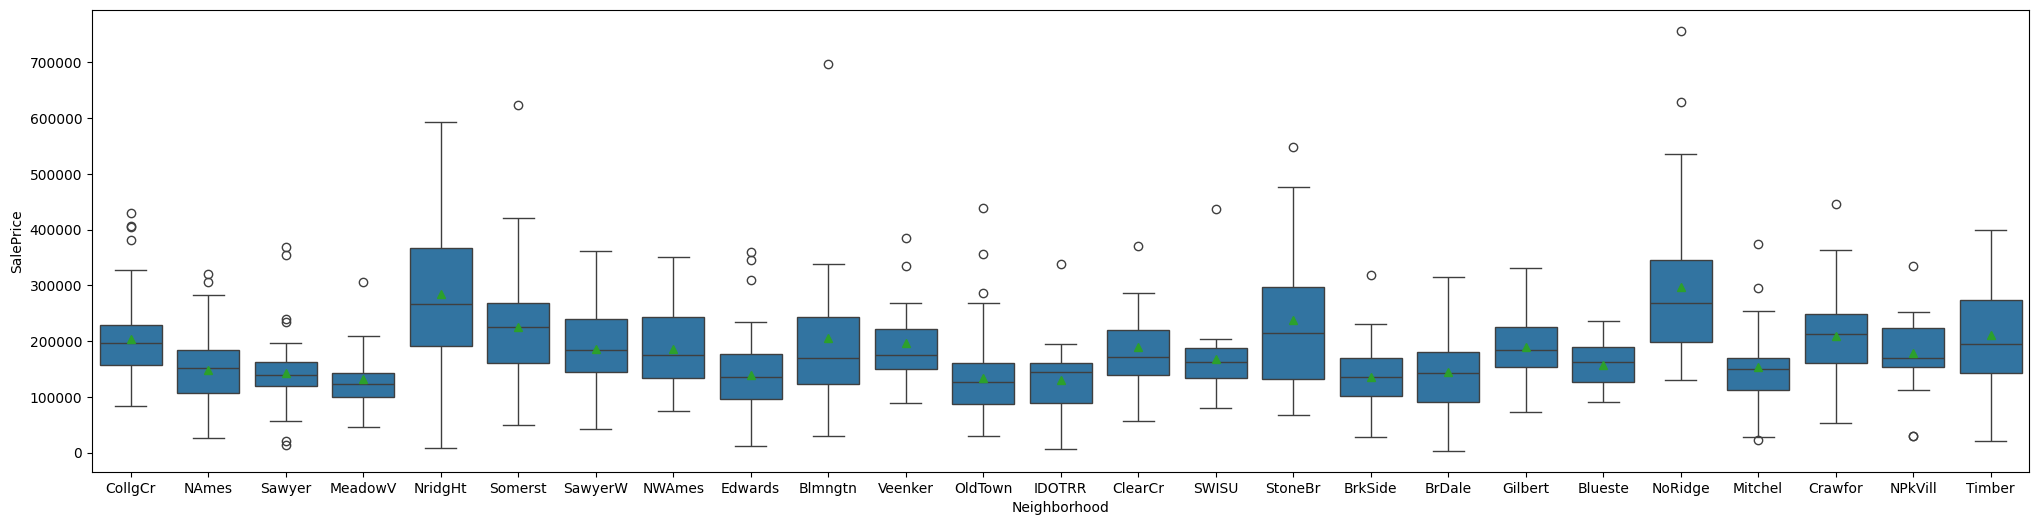

In [79]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Neighborhood",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

In [80]:
train_set['Neighborhood'].value_counts(dropna=False)

Neighborhood
NAmes      145
CollgCr    106
OldTown     77
Somerst     76
Edwards     75
Gilbert     68
NridgHt     60
Sawyer      56
NWAmes      55
SawyerW     50
Crawfor     45
BrkSide     44
Mitchel     41
Timber      36
NoRidge     34
IDOTRR      28
StoneBr     25
ClearCr     21
BrDale      21
Blmngtn     21
MeadowV     21
SWISU       19
NPkVill     19
Veenker     15
Blueste     10
Name: count, dtype: int64

### Since the neighborhood is an important feature, we will do one-hot encoding (later)

## Condition1 + Condition2

In [81]:
train_set['Condition1'].value_counts(dropna=False)

Condition1
Norm      828
Feedr      73
Artery     55
PosN       47
RRAe       44
PosA       36
RRNn       35
RRAn       29
RRNe       21
Name: count, dtype: int64

In [82]:
train_set['Condition2'].value_counts(dropna=False)

Condition2
Norm      934
RRAe       47
Feedr      41
RRNn       36
PosN       32
Artery     30
RRAn       28
PosA       20
Name: count, dtype: int64

<Axes: xlabel='Condition1', ylabel='SalePrice'>

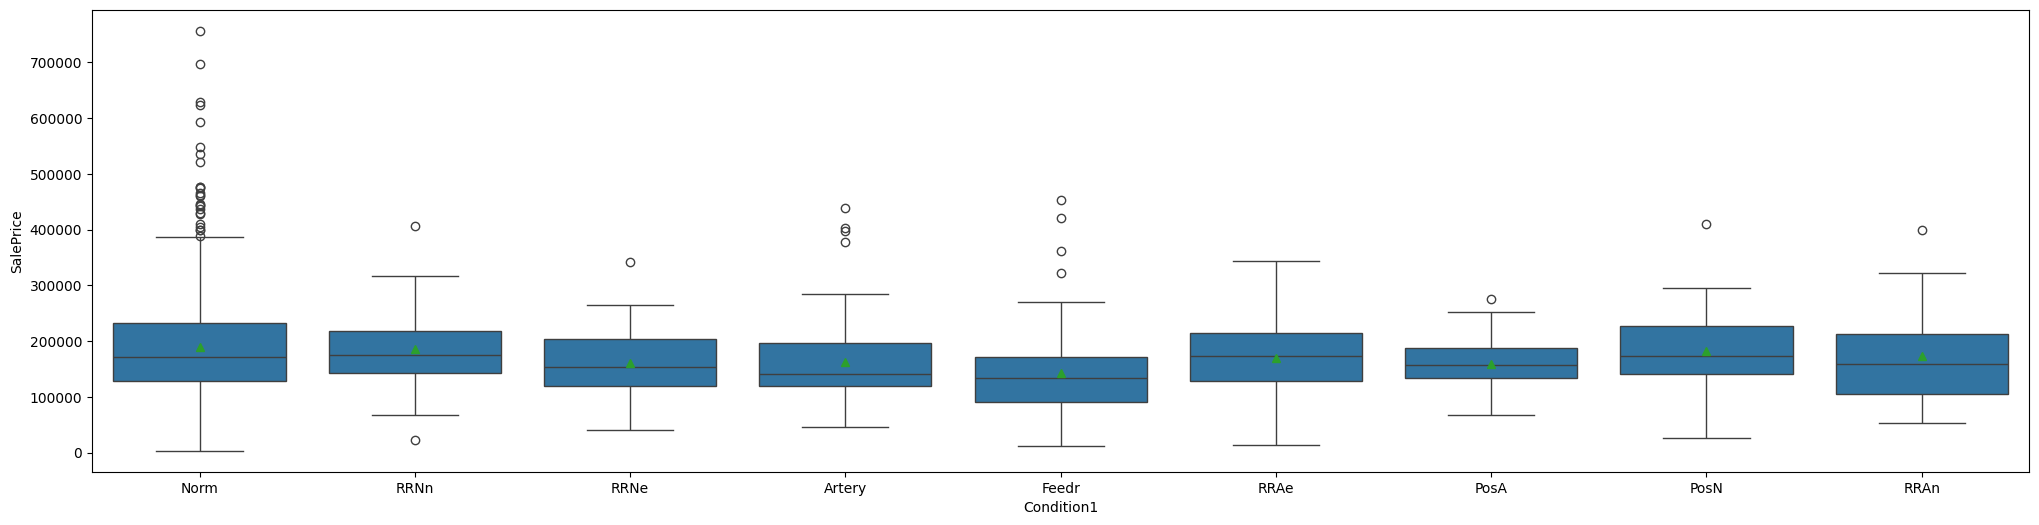

In [83]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Condition1",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

<Axes: xlabel='Condition2', ylabel='SalePrice'>

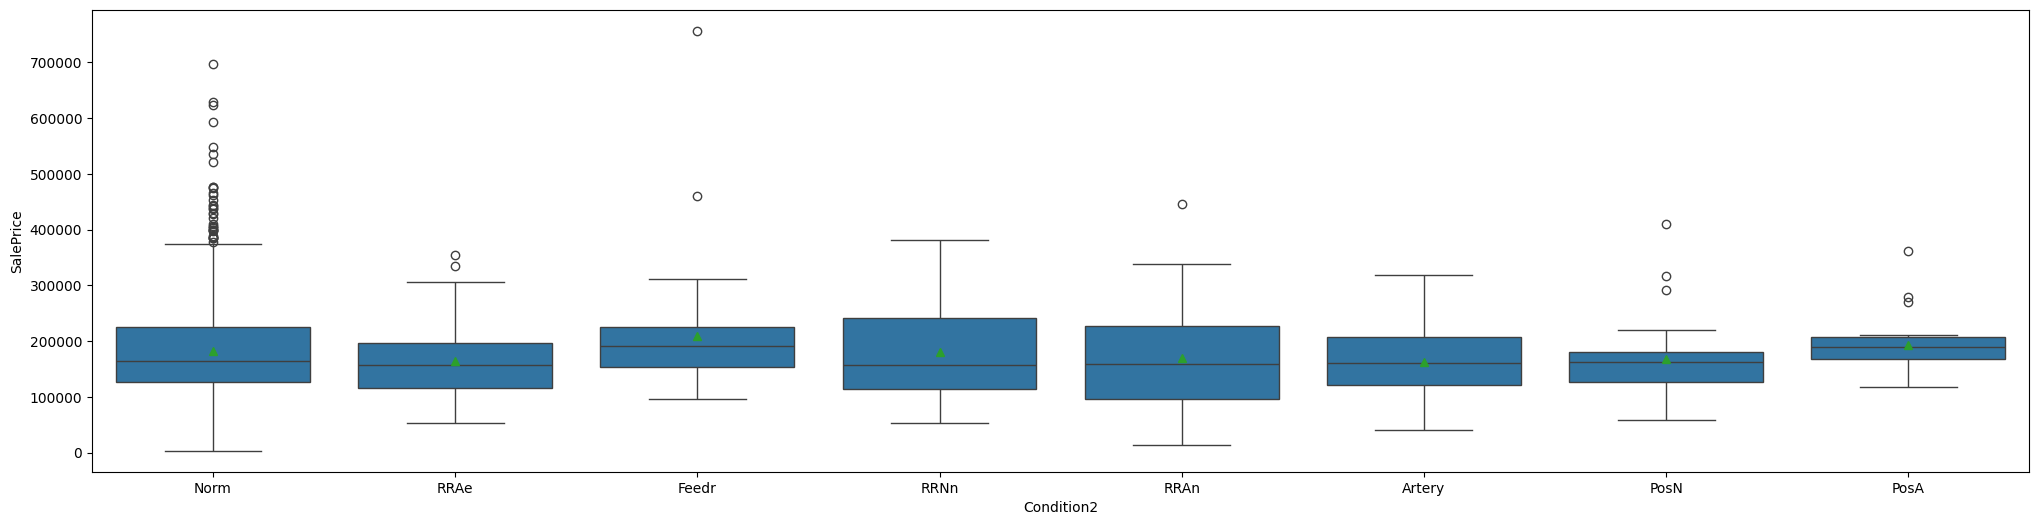

In [84]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Condition2",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

<Axes: xlabel='Condition1', ylabel='SalePrice'>

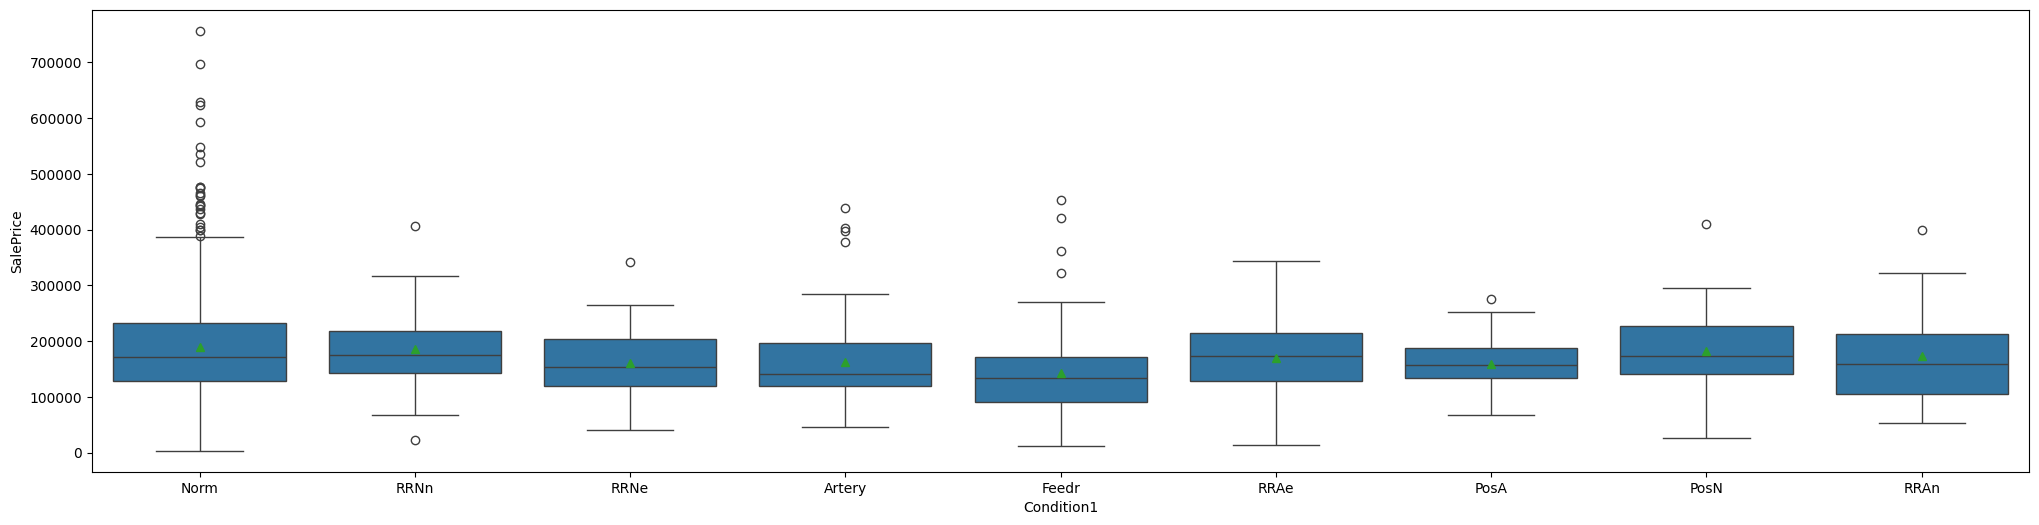

In [85]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Condition1",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We think we can reduce these features to one (named 'Condition') - that has the value 0 if Condition1 is 'Norm', the value 1 if Condition1 is not 'Norm' but Condition2 is 'Norm', and the value 2 if both Condition1 and Condition2 are not 'Norm'.

In [86]:
# Create a new 'Condition' column based on conditions
train_set['Condition'] = 0
test_set['Condition'] = 0  # Initialize 'Condition' with value 0

# Set 'Condition' to 1 if 'Condition1' is not 'Norm' but 'Condition2' is 'Norm'
train_set.loc[(train_set['Condition1'] != 'Norm') & (train_set['Condition2'] == 'Norm'), 'Condition'] = 0
test_set.loc[(test_set['Condition1'] != 'Norm') & (test_set['Condition2'] == 'Norm'), 'Condition'] = 0

# Set 'Condition' to 2 if both 'Condition1' and 'Condition2' are not 'Norm'
train_set.loc[(train_set['Condition1'] != 'Norm') & (train_set['Condition2'] != 'Norm'), 'Condition'] = 1
test_set.loc[(test_set['Condition1'] != 'Norm') & (test_set['Condition2'] != 'Norm'), 'Condition'] = 1

# Drop the original 'Condition1' and 'Condition2' columns
train_set.drop(['Condition1', 'Condition2'], axis=1, inplace=True)
test_set.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Insert the 'Condition' column at the 11th position
train_set.insert(loc=10, column='Condition', value=train_set.pop('Condition'))
test_set.insert(loc=10, column='Condition', value=test_set.pop('Condition'))

# Display the transformed DataFrame
print(train_set['Condition'])
train_set['Condition'].value_counts(dropna=False)

0       0
1       0
2       0
3       0
4       0
       ..
1163    0
1164    0
1165    0
1166    0
1167    0
Name: Condition, Length: 1168, dtype: int64


Condition
0    1102
1      66
Name: count, dtype: int64

## BldgType

In [87]:
train_set['BldgType'].value_counts(dropna=False)

BldgType
1Fam      808
TwnhsE    111
2fmCon     85
Twnhs      83
Duplex     81
Name: count, dtype: int64

<Axes: xlabel='BldgType', ylabel='SalePrice'>

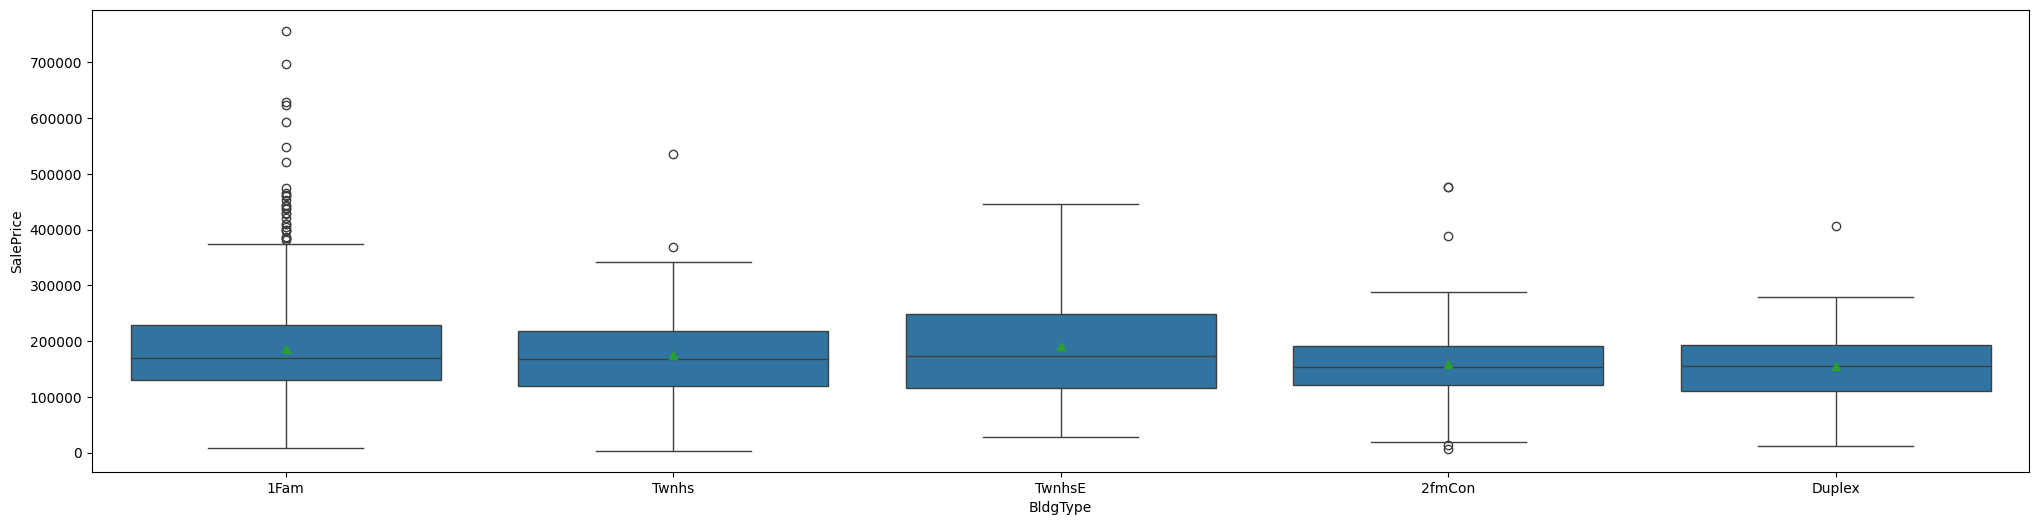

In [88]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "BldgType",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding (later)

## HouseStyle

In [89]:
train_set['HouseStyle'].value_counts(dropna=False)

HouseStyle
1Story    508
2Story    313
1.5Fin    119
SLvl       67
SFoyer     53
2.5Unf     39
2.5Fin     36
1.5Unf     33
Name: count, dtype: int64

<Axes: xlabel='HouseStyle', ylabel='SalePrice'>

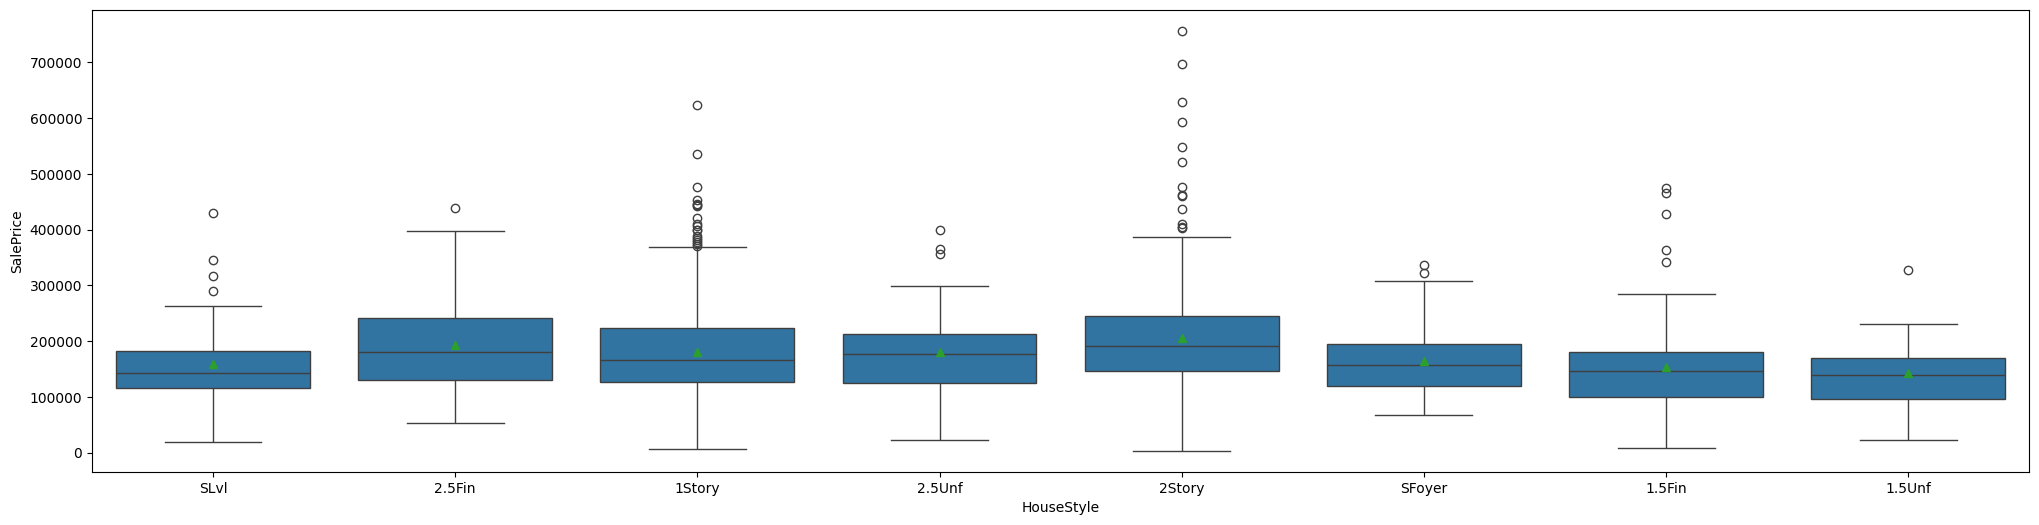

In [90]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "HouseStyle",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding (later)

## RoofStyle

In [91]:
train_set['RoofStyle'].value_counts(dropna=False)

RoofStyle
Gable      772
Hip        229
Flat        60
Gambrel     44
Shed        32
Mansard     31
Name: count, dtype: int64

<Axes: xlabel='RoofStyle', ylabel='SalePrice'>

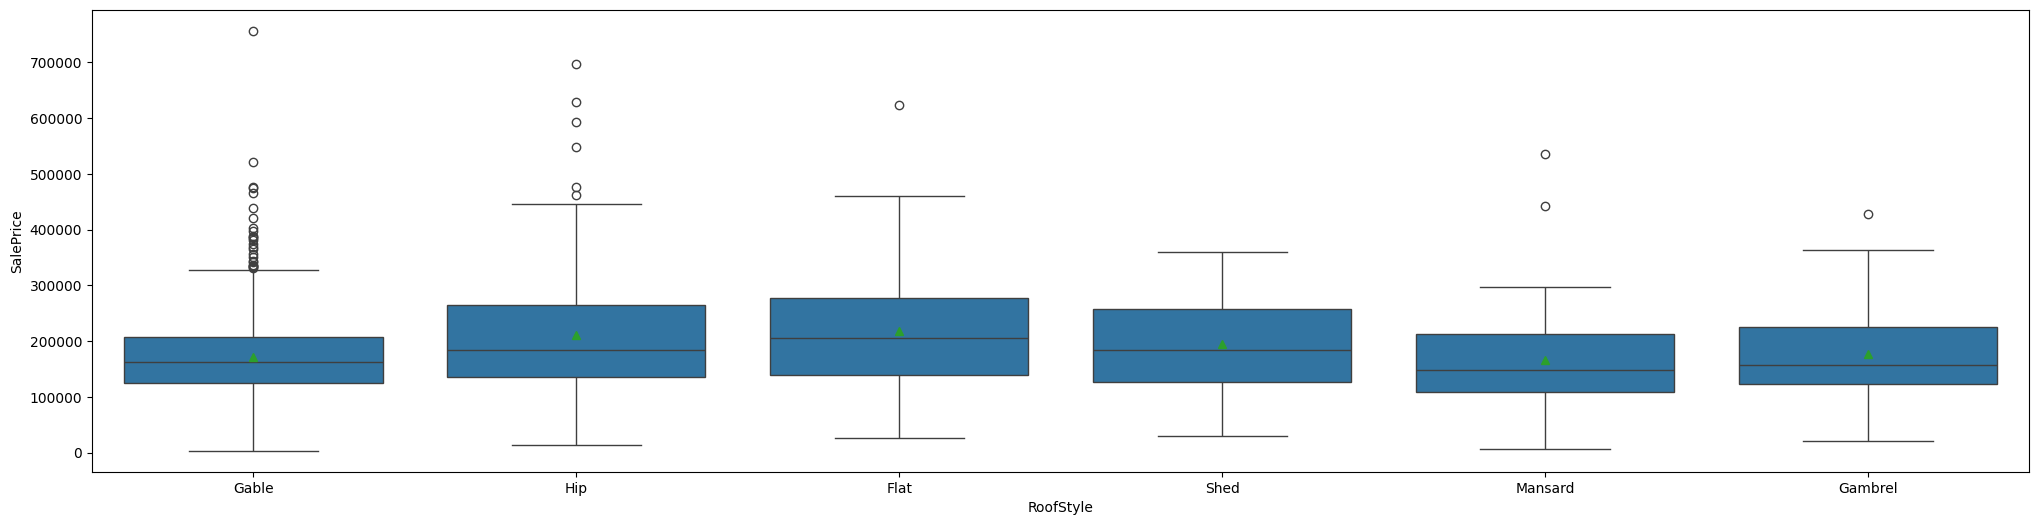

In [92]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "RoofStyle",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding, since this category has different values without any importance or hierarchy between them

## RoofMatl

In [93]:
train_set['RoofMatl'].value_counts(dropna=False)

RoofMatl
CompShg    950
WdShake     37
Membran     35
Tar&Grv     33
WdShngl     32
ClyTile     32
Roll        29
Metal       20
Name: count, dtype: int64

<Axes: xlabel='RoofMatl', ylabel='SalePrice'>

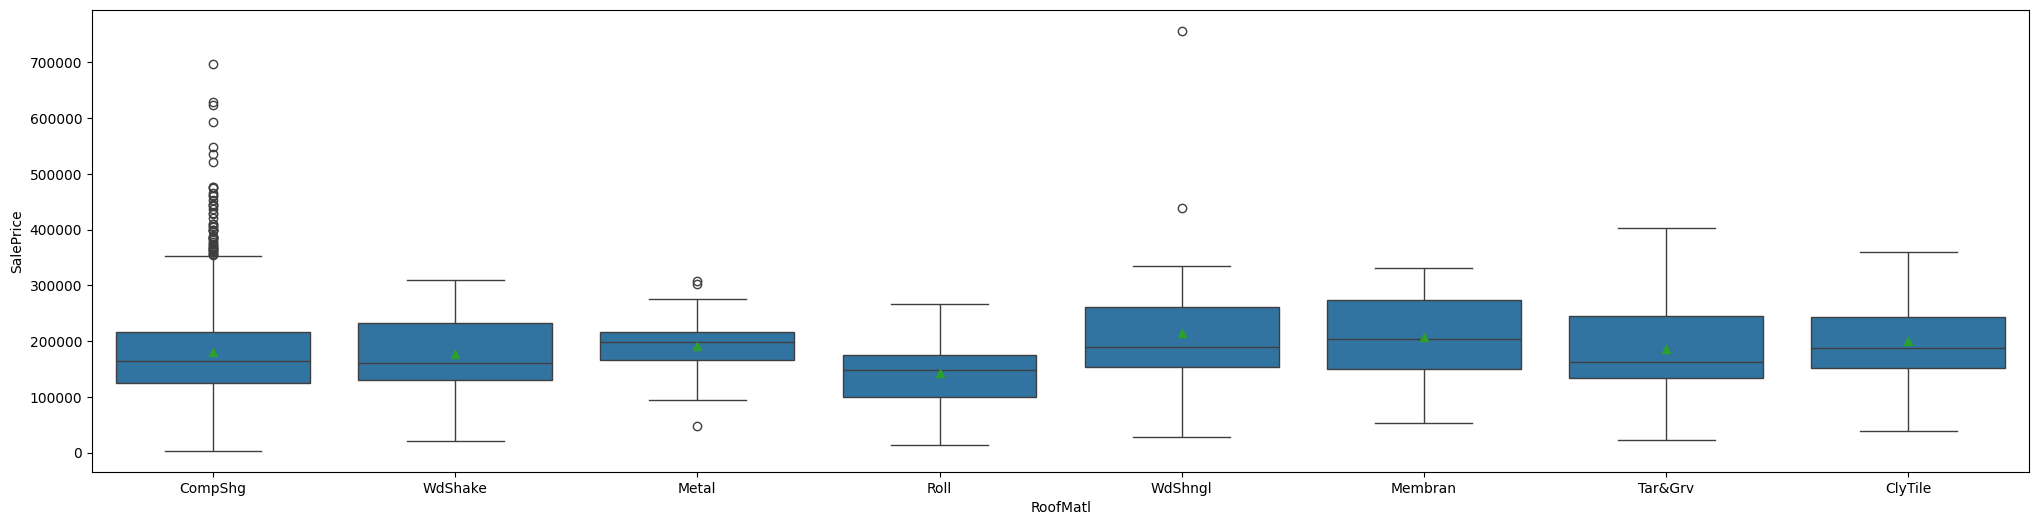

In [94]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "RoofMatl",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### It seems the relevant categorization here is to see if the material is standard or not.

In [95]:
# Binarize the 'RoofMatl' column
train_set['RoofMatl'] = (train_set['RoofMatl'] == 'CompShg').astype(int)
test_set['RoofMatl'] = (test_set['RoofMatl'] == 'CompShg').astype(int)

# Display the transformed DataFrame
train_set['RoofMatl'].value_counts(dropna=False)

RoofMatl
1    950
0    218
Name: count, dtype: int64

## Exterior1st + Exterior2nd

In [96]:
train_set['Exterior1st'].value_counts(dropna=False)

Exterior1st
VinylSd    351
MetalSd    164
HdBoard    152
Wd Sdng    149
Plywood     84
CemntBd     59
BrkFace     53
AsbShng     30
Stucco      29
WdShing     23
Stone       19
BrkComm     17
AsphShn     14
ImStucc     13
CBlock      11
Name: count, dtype: int64

In [97]:
train_set['Exterior2nd'].value_counts(dropna=False)

Exterior2nd
VinylSd    340
MetalSd    159
HdBoard    146
Wd Sdng    133
Plywood    103
CmentBd     49
BrkFace     36
Stucco      32
AsbShng     31
Wd Shng     29
Brk Cmn     22
Other       21
ImStucc     19
Stone       18
AsphShn     16
CBlock      14
Name: count, dtype: int64

<Axes: xlabel='Exterior1st', ylabel='SalePrice'>

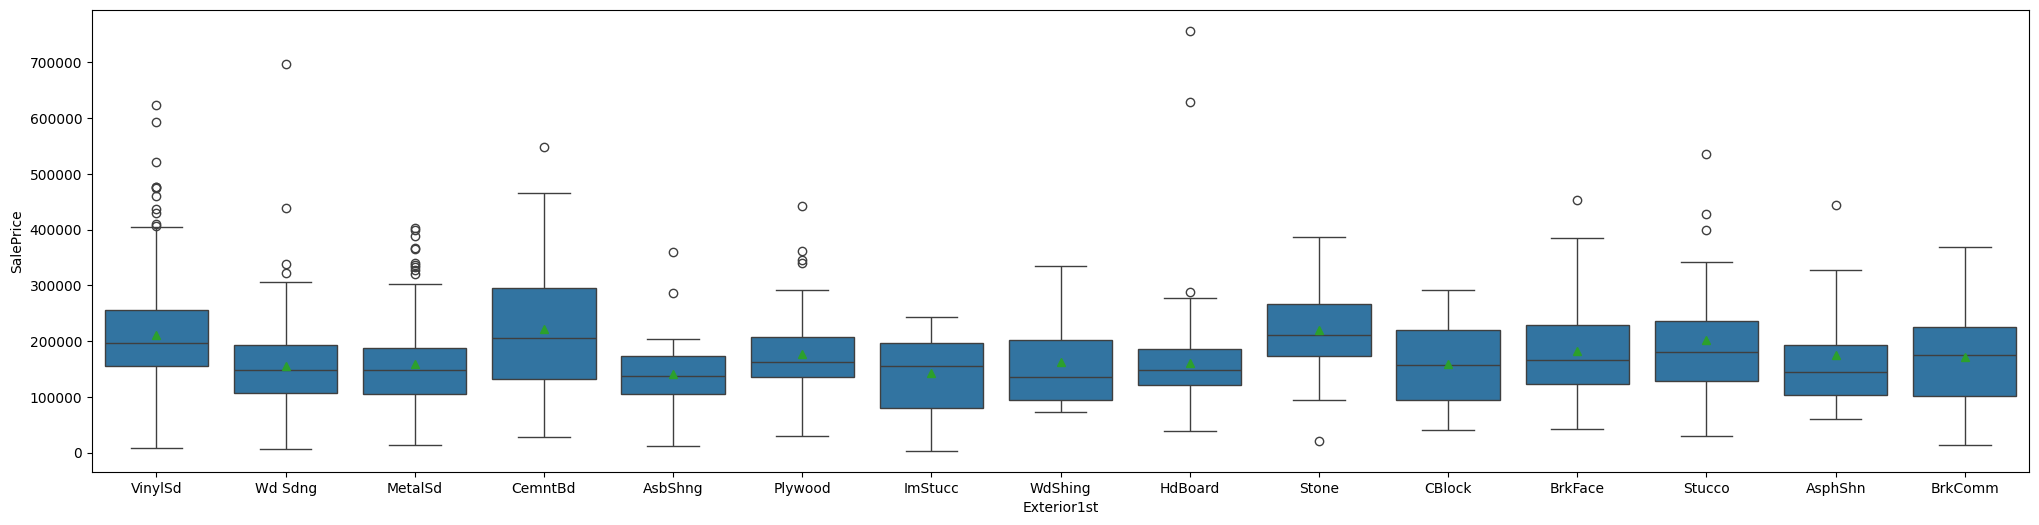

In [98]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Exterior1st",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

<Axes: xlabel='Exterior2nd', ylabel='SalePrice'>

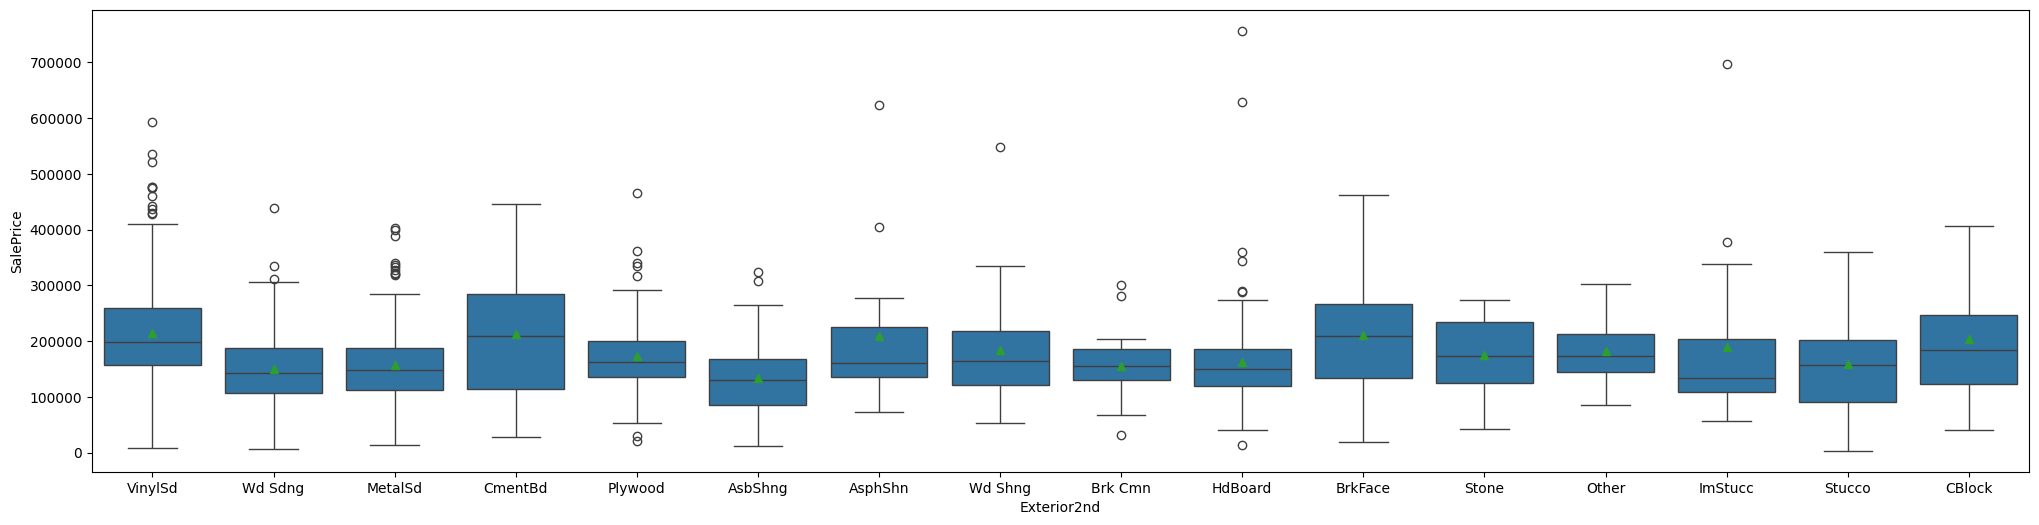

In [99]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Exterior2nd",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### From a research we made, it seems that Asbestos Shingles and Asphalt Shingles are concidered to be problematic - they might cause severe health issues. Because of that, we decided to drop these 2 columns and replace them with the column Exterior_Danger, which will indicate 1 if the exterior 1/2 contain AsbShng or AsphShn, and 0 otherwise.

In [100]:
# Check if 'AsbShng' or 'AsphShn' is present in either 'Exterior1st' or 'Exterior2nd'
dangerous_exterior = (
    (train_set['Exterior1st'].isin(['AsbShng', 'AsphShn'])) |
    (train_set['Exterior2nd'].isin(['AsbShng', 'AsphShn']))
)

# Create new column 'Exterior_Danger' based on the condition
train_set['Exterior_Danger'] = dangerous_exterior.astype(int)

dangerous_exterior = (
    (test_set['Exterior1st'].isin(['AsbShng', 'AsphShn'])) |
    (test_set['Exterior2nd'].isin(['AsbShng', 'AsphShn']))
)
# Create new column 'Exterior_Danger' based on the condition
test_set['Exterior_Danger'] = dangerous_exterior.astype(int)

# Get column names and find the index of 'Exterior2nd'
columns = list(train_set.columns)
ext2_index = columns.index('Exterior2nd')

# Get column names and find the index of 'Exterior2nd'
columns = list(test_set.columns)
ext2_index = columns.index('Exterior2nd')

# Insert 'Exterior_Danger' column after 'Exterior2nd'
train_set.insert(ext2_index + 1, 'Exterior_Danger', train_set.pop('Exterior_Danger'))
# Insert 'Exterior_Danger' column after 'Exterior2nd'
test_set.insert(ext2_index + 1, 'Exterior_Danger', test_set.pop('Exterior_Danger'))

# Drop 'Exterior1st' and 'Exterior2nd' columns
test_set.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)


# Drop 'Exterior1st' and 'Exterior2nd' columns
train_set.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

# Check the value counts of 'Exterior_Danger' column
train_set['Exterior_Danger'].value_counts(dropna=False)

Exterior_Danger
0    1092
1      76
Name: count, dtype: int64

## MasVnrType

In [101]:
train_set['MasVnrType'].value_counts(dropna=False)

MasVnrType
BrkFace    683
None       308
Stone      125
BrkCmn      52
Name: count, dtype: int64

<Axes: xlabel='MasVnrType', ylabel='SalePrice'>

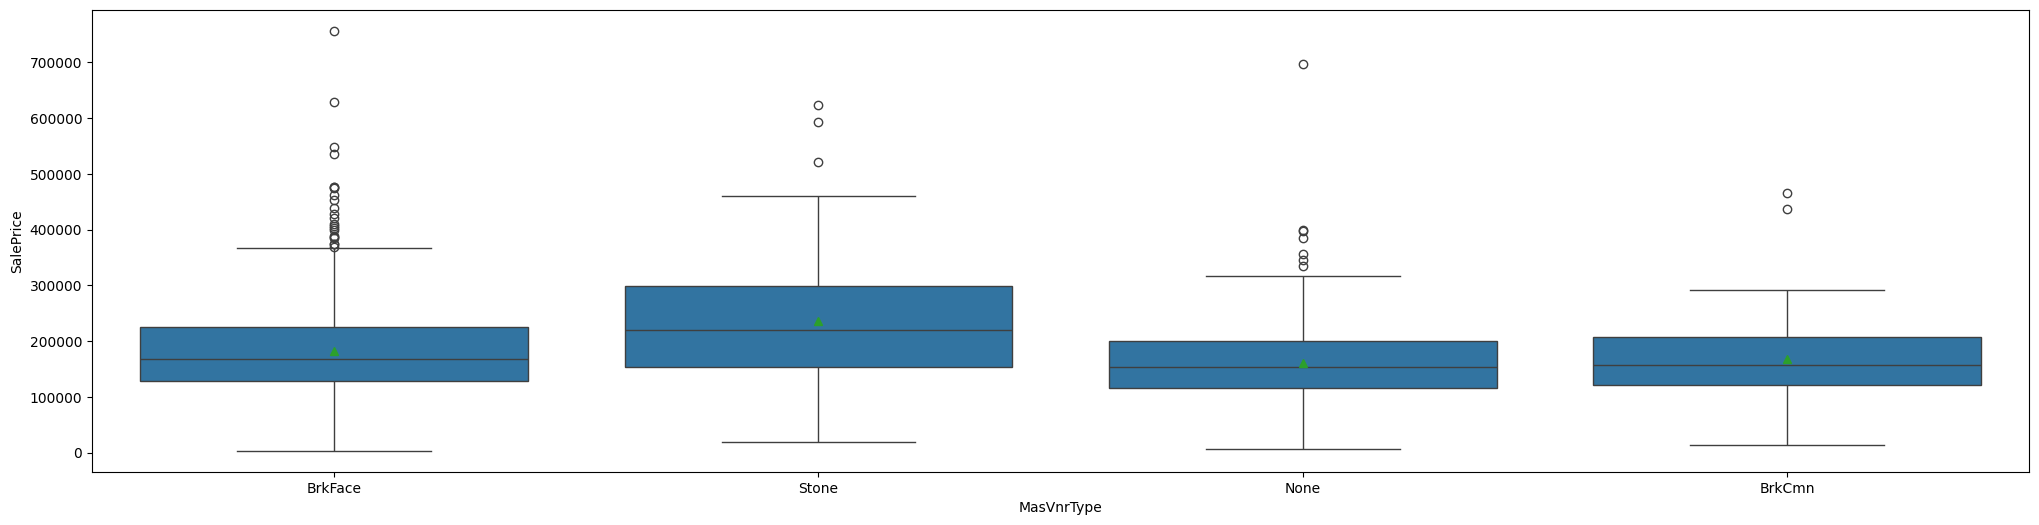

In [102]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "MasVnrType",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding since there are not many unique values here and the median of stone seems a little higher than BrkFace

## ExterCond

In [103]:
train_set['ExterCond'].value_counts(dropna=False)

ExterCond
TA    881
Gd    140
Fa     57
Ex     46
Po     44
Name: count, dtype: int64

<Axes: xlabel='ExterCond', ylabel='SalePrice'>

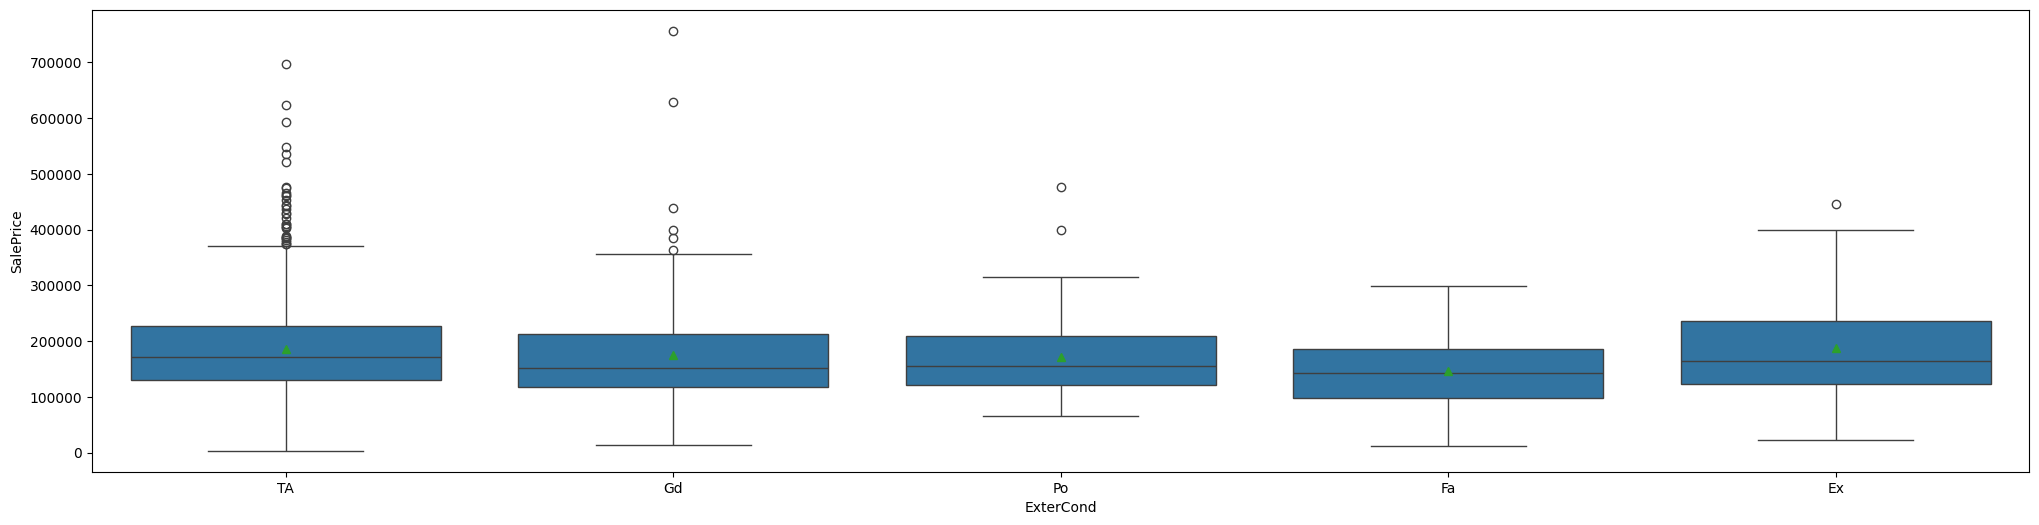

In [104]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "ExterCond",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We decided to cateogrize this feature numerically.

In [105]:
mapping = {
    'Po': 0,
    'Fa': 1,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}
# Binarize 'ExterCond' based on the condition
train_set['ExterCond'] = train_set['ExterCond'].map(mapping)
test_set['ExterCond'] = test_set['ExterCond'].map(mapping)

train_set['ExterCond'].value_counts(dropna=False)

ExterCond
3    881
4    140
1     57
5     46
0     44
Name: count, dtype: int64

## Foundation

In [106]:
train_set['Foundation'].value_counts(dropna=False)

Foundation
PConc     460
CBlock    430
BrkTil    127
Slab       64
Wood       46
Stone      41
Name: count, dtype: int64

<Axes: xlabel='Foundation', ylabel='SalePrice'>

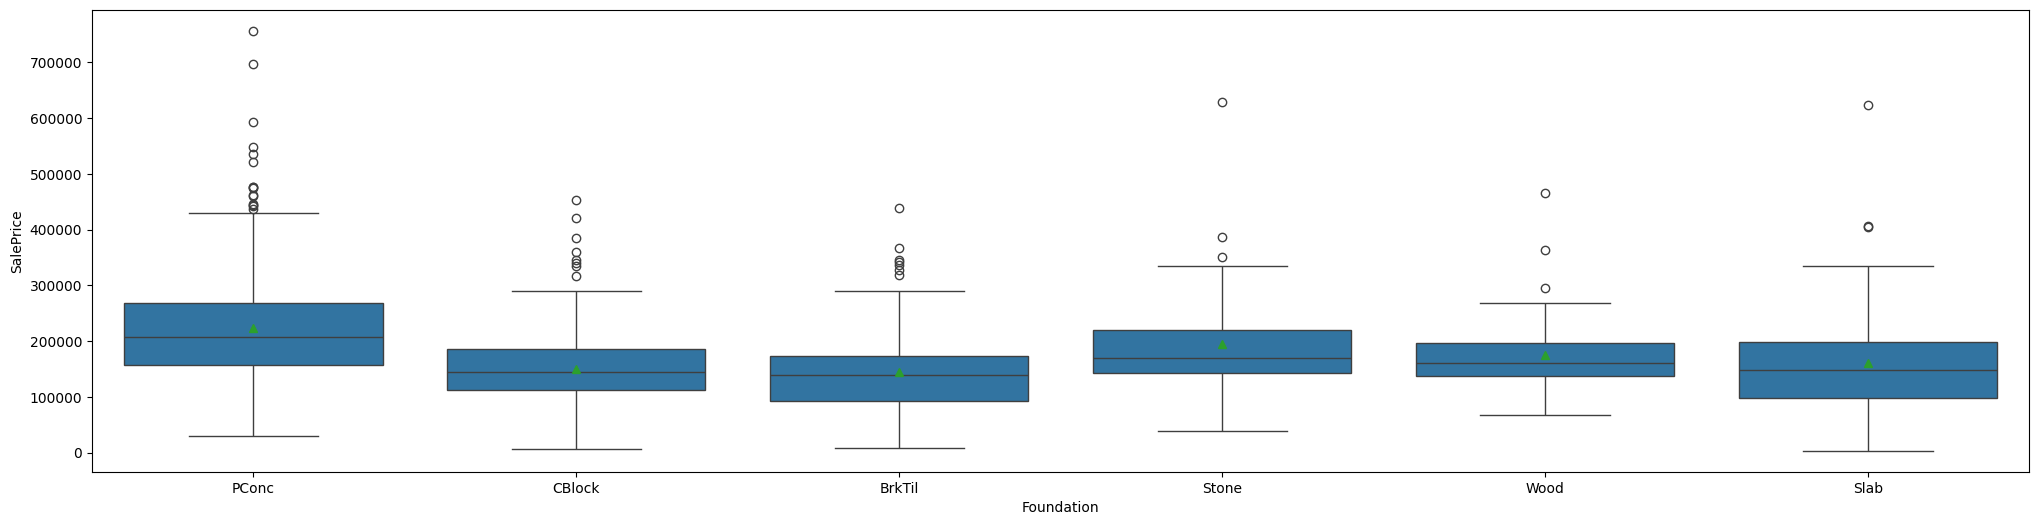

In [107]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Foundation",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding (later)

## BsmtCond

In [108]:
train_set['BsmtCond'].value_counts(dropna=False)

BsmtCond
TA    955
Gd     91
Fa     73
Po     49
Name: count, dtype: int64

<Axes: xlabel='BsmtCond', ylabel='SalePrice'>

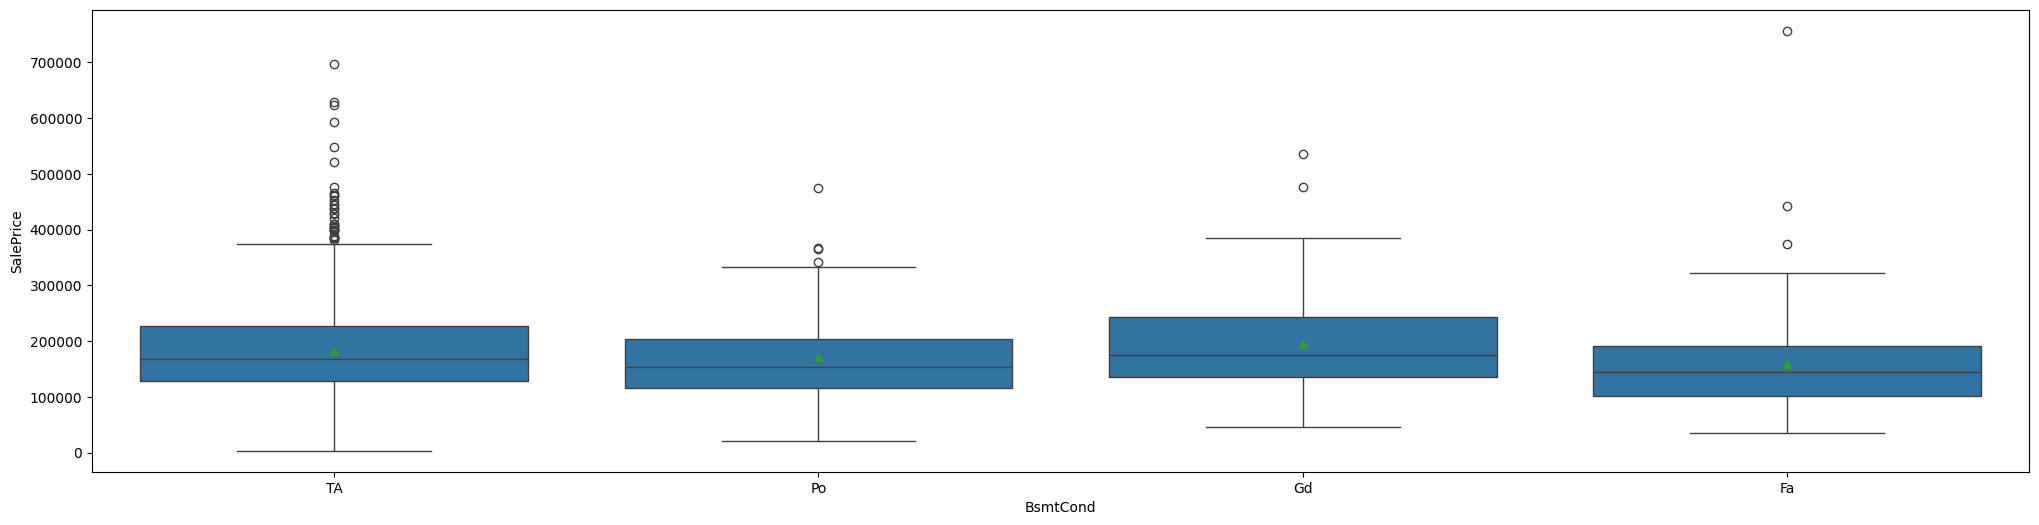

In [109]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "BsmtCond",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### Seems that the medians of Fair and Poor are lower compared to Good and Excellent, we will map it to a numerical feature while poor is 0 and excellent is 5, no NA values have been detected

In [110]:
mapping = {
    'Po': 0,
    'Fa': 1,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    'NA': 0
}
train_set['BsmtCond'] = train_set['BsmtCond'].map(mapping)
test_set['BsmtCond'] = test_set['BsmtCond'].map(mapping)

## BsmtExposure

In [111]:
train_set['BsmtExposure'].value_counts(dropna=False)

BsmtExposure
No    714
Av    190
Gd    146
Mn    118
Name: count, dtype: int64

<Axes: xlabel='BsmtExposure', ylabel='SalePrice'>

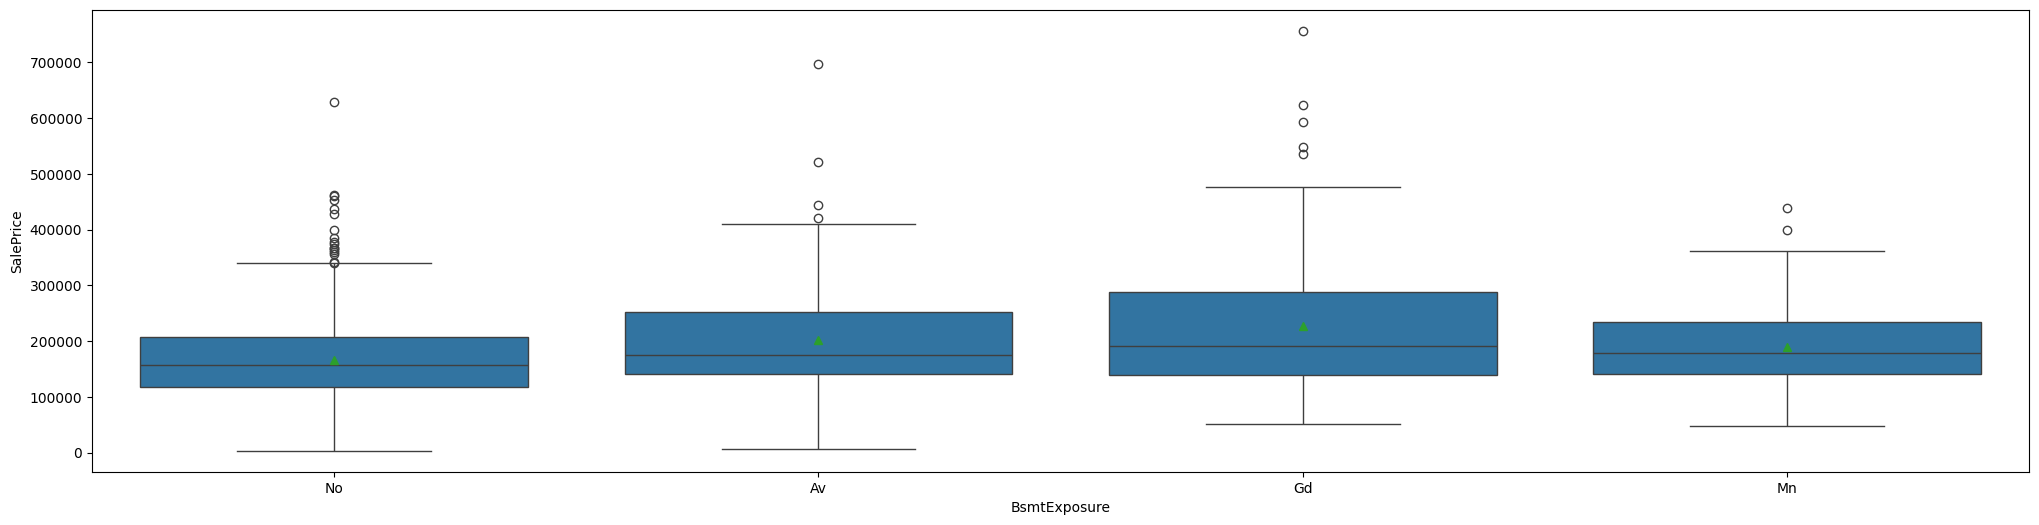

In [112]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "BsmtExposure",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### Here it seems we should map it to 2 categories - whether it's 'No'/ 'Mn'/'NA', or it's 'Av'/'Gd'. (The meaning for each category is whether the basement can be a seperated living space or not).

In [113]:
# Create a mapping dictionary
exposure_map = {'No': 0, 'Mn': 0, 'NA': 0, 'Av': 1, 'Gd': 1}

# Map the 'BsmtExposure' values to binary categories
train_set['BsmtExposure'] = train_set['BsmtExposure'].map(exposure_map)
test_set['BsmtExposure'] = test_set['BsmtExposure'].map(exposure_map)

# Display the transformed DataFrame
train_set['BsmtExposure'].value_counts(dropna=False)

BsmtExposure
0    832
1    336
Name: count, dtype: int64

## Heating

In [114]:
train_set['Heating'].value_counts(dropna=False)

Heating
GasA     931
GasW      63
Floor     50
Wall      43
OthW      41
Grav      40
Name: count, dtype: int64

<Axes: xlabel='Heating', ylabel='SalePrice'>

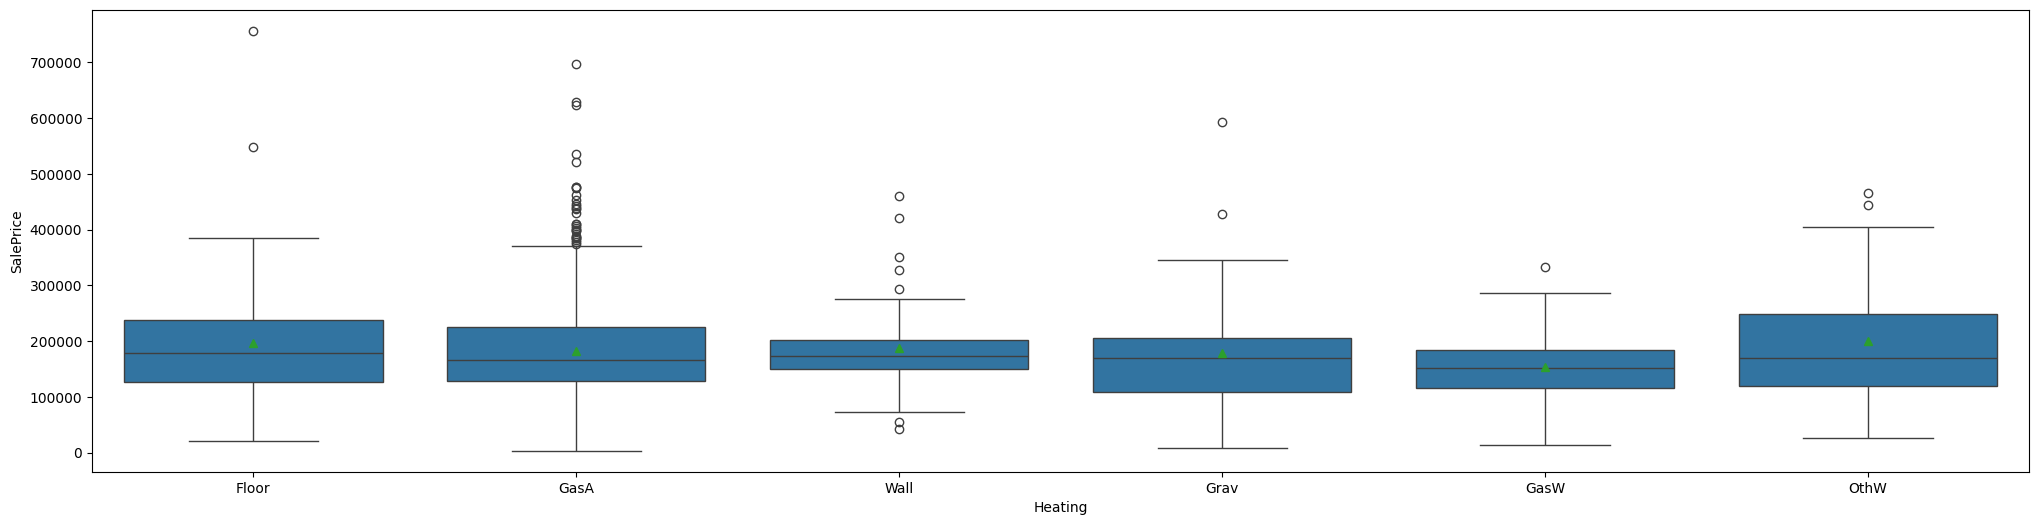

In [115]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Heating",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll do one hot encoding

## HeatingQC

In [116]:
train_set['HeatingQC'].value_counts(dropna=False)

HeatingQC
Ex    510
TA    323
Gd    197
Fa     90
Po     48
Name: count, dtype: int64

<Axes: xlabel='HeatingQC', ylabel='SalePrice'>

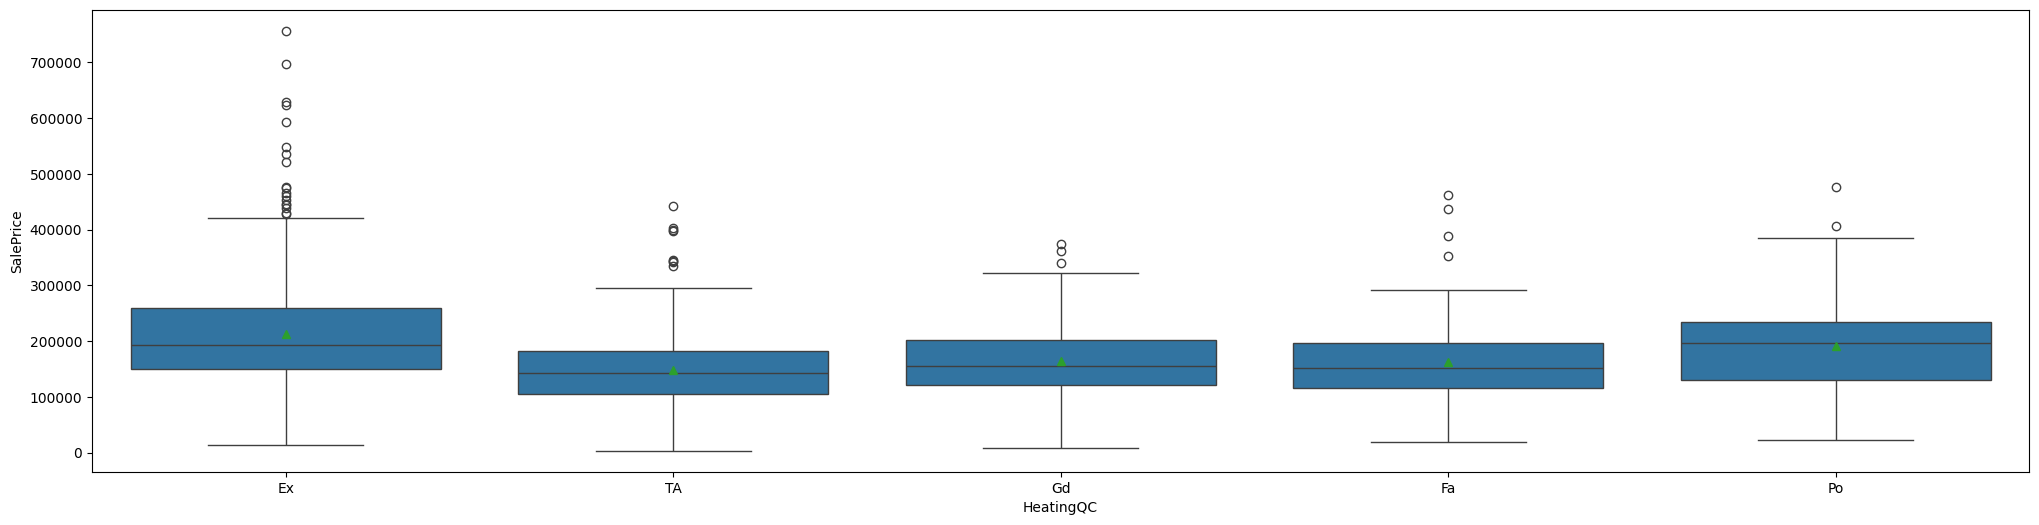

In [117]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "HeatingQC",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### Again - we decided to divide the feature to numerical categories.

In [118]:
mapping = {
    'Po': 0,
    'Fa': 1,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    'NA': 0
}
train_set['HeatingQC'] = train_set['HeatingQC'].map(mapping)
test_set['HeatingQC'] = test_set['HeatingQC'].map(mapping)

## CentralAir

### We'll binarize it - it is a Y/N feature

In [119]:
# Define a mapping dictionary
centralair_map = {'Y': 1, 'N': 0}

# Map the values of 'CentralAir' to numeric values using the defined mapping dictionary
train_set['CentralAir'] = train_set['CentralAir'].map(centralair_map)
test_set['CentralAir'] = test_set['CentralAir'].map(centralair_map)

# Display the transformed DataFrame
train_set['CentralAir'].value_counts(dropna=False)

CentralAir
1    1001
0     167
Name: count, dtype: int64

## Electrical

In [120]:
train_set['Electrical'].value_counts(dropna=False)

Electrical
SBrkr    951
FuseA     98
FuseF     52
FuseP     34
Mix       33
Name: count, dtype: int64

<Axes: xlabel='Electrical', ylabel='SalePrice'>

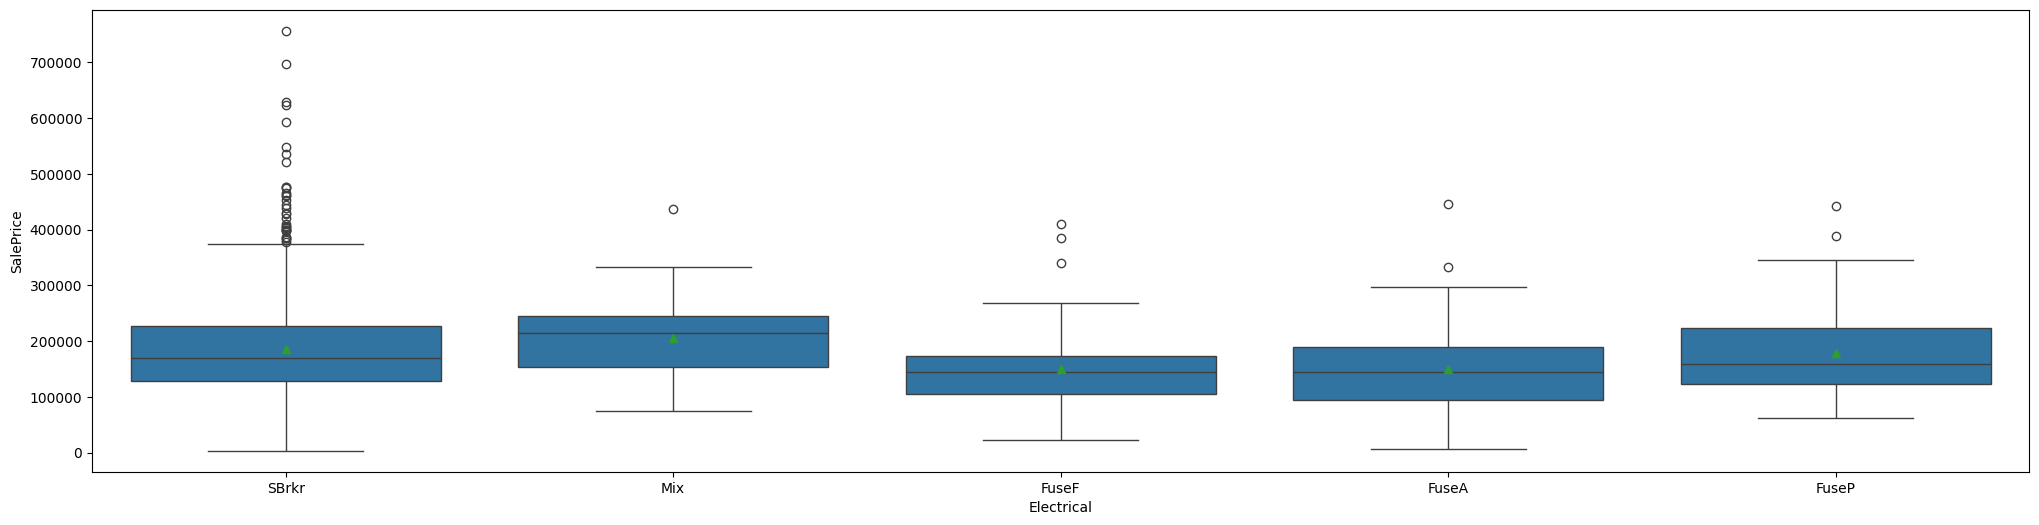

In [121]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Electrical",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### It seems the relevant approach here is binarization - SBrkr or not since more than 80% of the values are SBrkr

In [122]:
# Map 'Electrical' to binary values based on whether it's 'SBrkr'
train_set['Electrical'] = (train_set['Electrical'] == 'SBrkr').astype(int)
test_set['Electrical'] = (test_set['Electrical'] == 'SBrkr').astype(int)

## GarageType

In [123]:
train_set['GarageType'].value_counts(dropna=False)

GarageType
Attchd     588
Detchd     291
BuiltIn     99
Basment     58
NA          55
CarPort     44
2Types      33
Name: count, dtype: int64

<Axes: xlabel='GarageType', ylabel='SalePrice'>

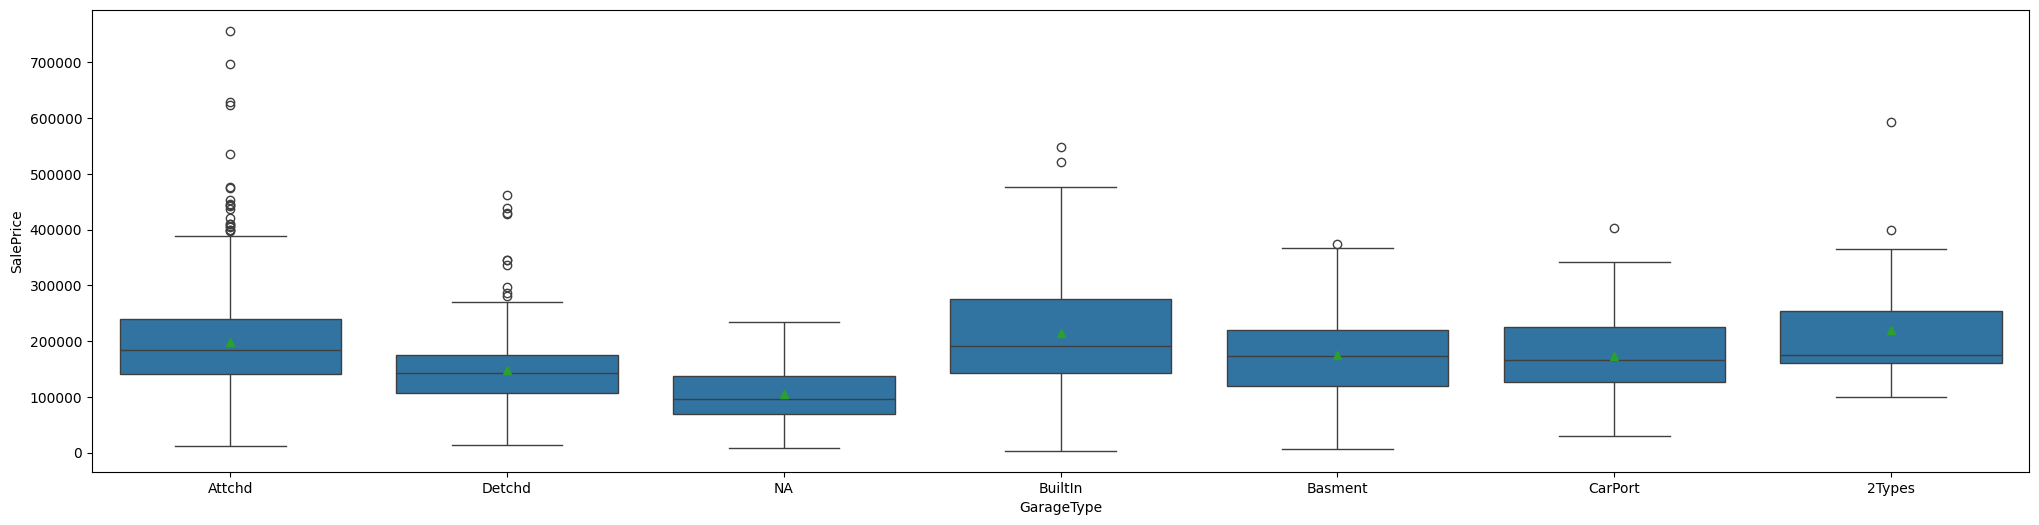

In [124]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "GarageType",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll use one hot encoding for this feature since there is not any hierarchy here

## Functional

In [125]:
train_set['Functional'].value_counts(dropna=False)

Functional
Typ     922
Min1     56
Maj1     50
Min2     47
Mod      35
Maj2     32
Sev      26
Name: count, dtype: int64

<Axes: xlabel='Functional', ylabel='SalePrice'>

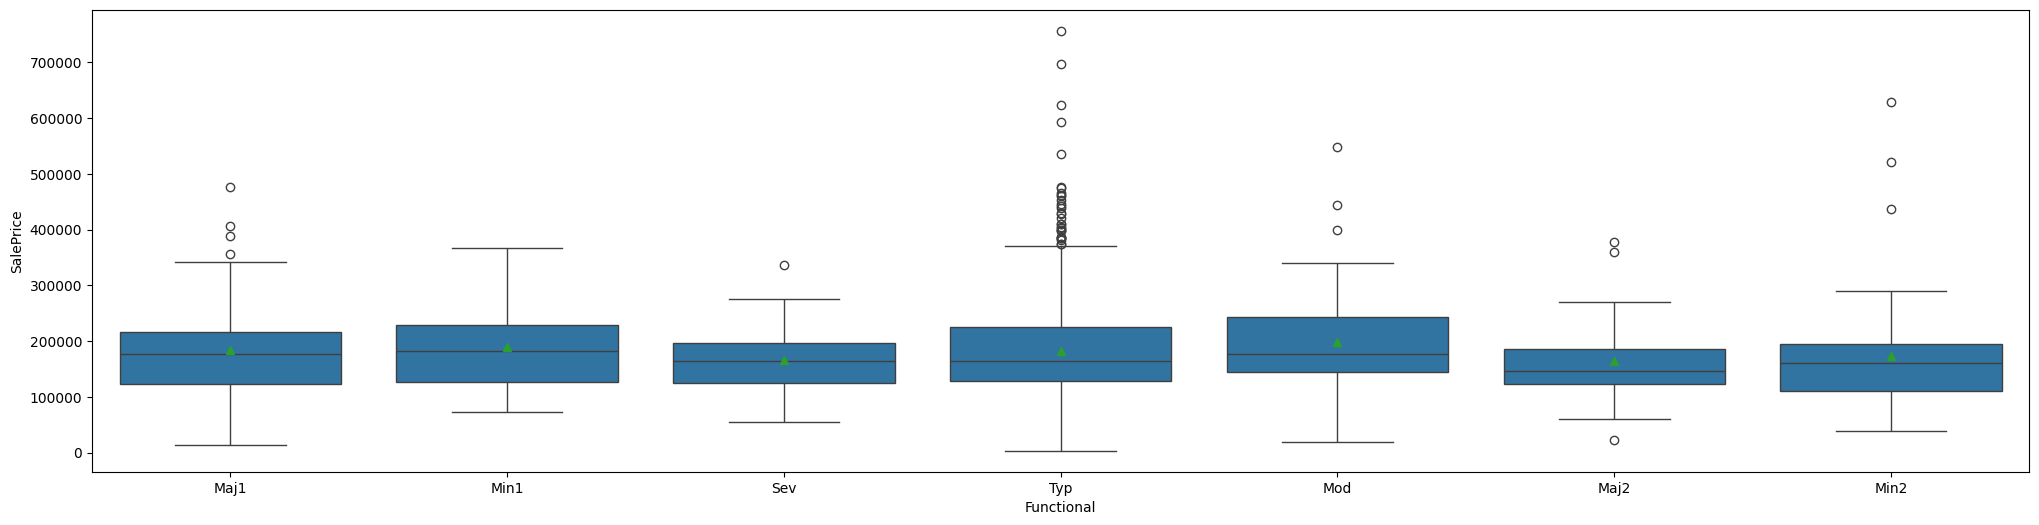

In [126]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "Functional",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We decided to map this feature to 5 categories - 0 if there are no damages (Typ), 1 if the damage is minor/moderate, and 2 if there is a major damage, 3 for severe damage and 4 for salvage damage.

In [127]:
# Define mapping for 'Functional' categories
functional_mapping = {
    'Typ': 0,
    'Min1': 1,
    'Min2': 1,
    'Mod': 1,
    'Maj1': 2,
    'Maj2': 2,
    'Sev': 3,
    'Sal': 4
}

# Map 'Functional' column to numerical values based on the mapping
train_set['Functional'] = train_set['Functional'].map(functional_mapping)
test_set['Functional'] = test_set['Functional'].map(functional_mapping)

## GarageFinish

In [128]:
train_set['GarageFinish'].value_counts(dropna=False)

GarageFinish
Unf    509
RFn    377
Fin    282
Name: count, dtype: int64

<Axes: xlabel='GarageFinish', ylabel='SalePrice'>

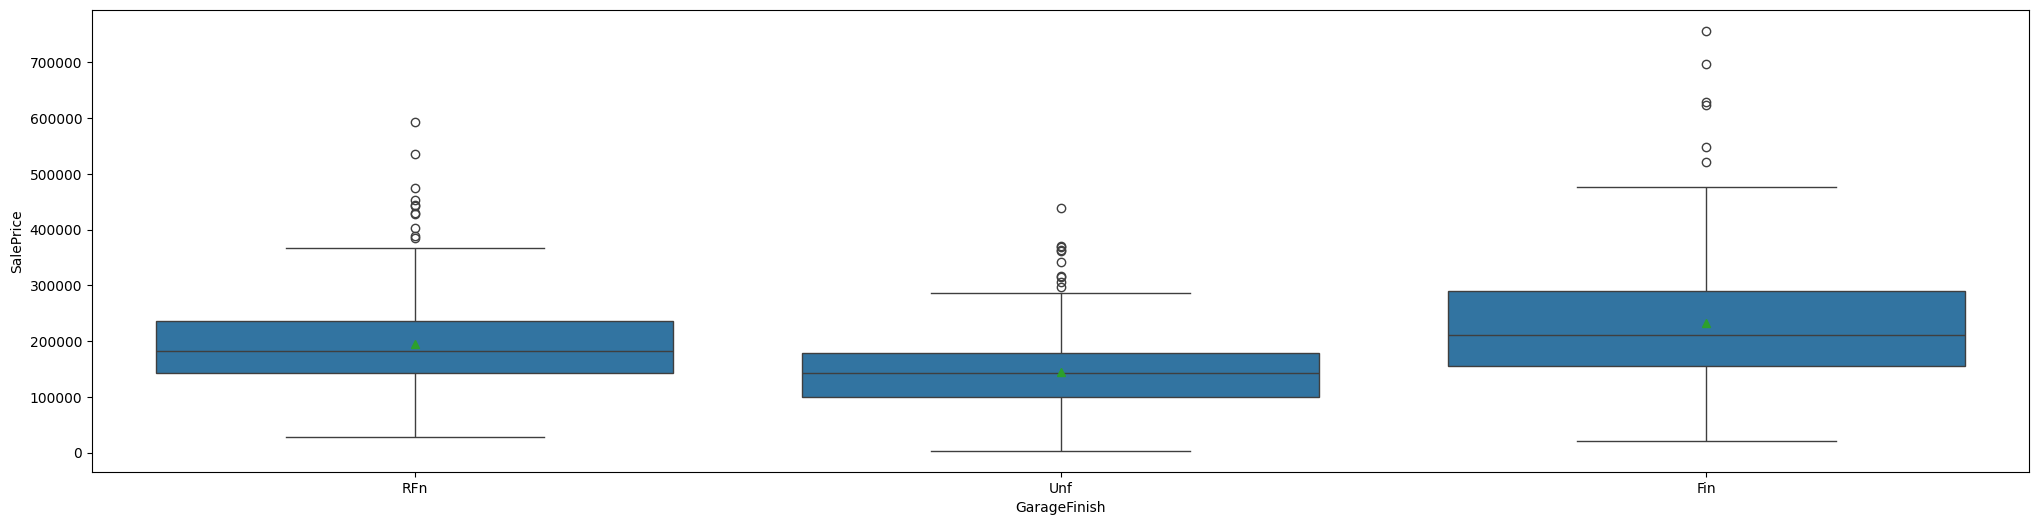

In [129]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "GarageFinish",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll map it - 0 for Unf or NA, 1 for RFn, 2 for Fin

In [130]:
# Define mapping for 'GarageFinish' categories
garage_finish_mapping = {
    'Fin': 2,
    'RFn': 1,
    'Unf': 0,
    'NA': 0  # Assuming 'NA' means no garage and should be mapped to 0
}

# Map 'GarageFinish' column to numerical values based on the mapping
train_set['GarageFinish'] = train_set['GarageFinish'].map(garage_finish_mapping)
test_set['GarageFinish'] = test_set['GarageFinish'].map(garage_finish_mapping)

## GarageQual

In [131]:
train_set['GarageQual'].value_counts(dropna=False)

GarageQual
TA    972
Fa     64
Po     46
Gd     46
Ex     40
Name: count, dtype: int64

<Axes: xlabel='GarageQual', ylabel='SalePrice'>

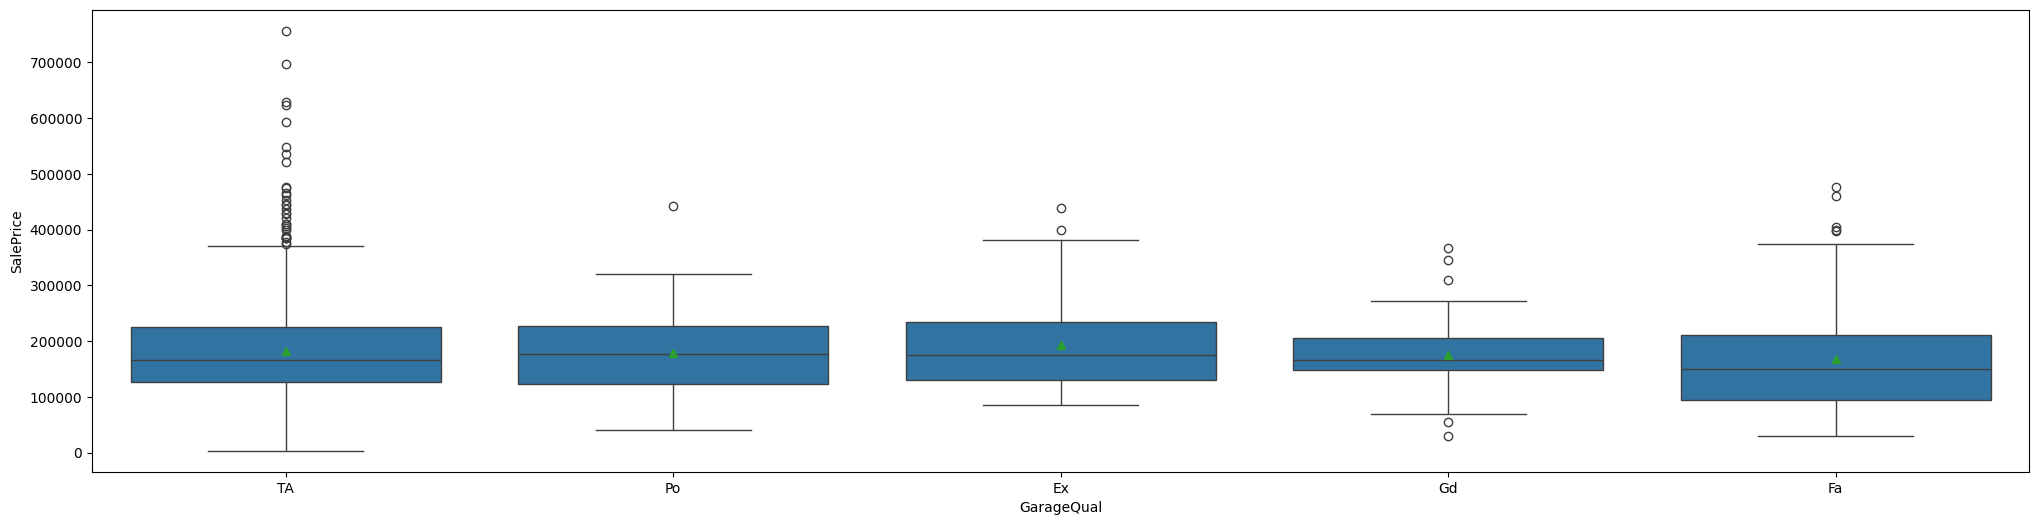

In [132]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "GarageQual",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### there isn't siginifanct difference betweeen the values, we'll rank it to 0-5 values since there is a hierarchy here

In [133]:
mapping = {
    'Po': 0,
    'Fa': 1,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    'NA': 0
}
train_set['GarageQual'] = train_set['GarageQual'].map(mapping)
test_set['GarageQual'] = test_set['GarageQual'].map(mapping)

## GarageCond

In [134]:
train_set['GarageCond'].value_counts(dropna=False)

GarageCond
TA    973
Fa     62
Ex     50
Gd     43
Po     40
Name: count, dtype: int64

<Axes: xlabel='GarageCond', ylabel='SalePrice'>

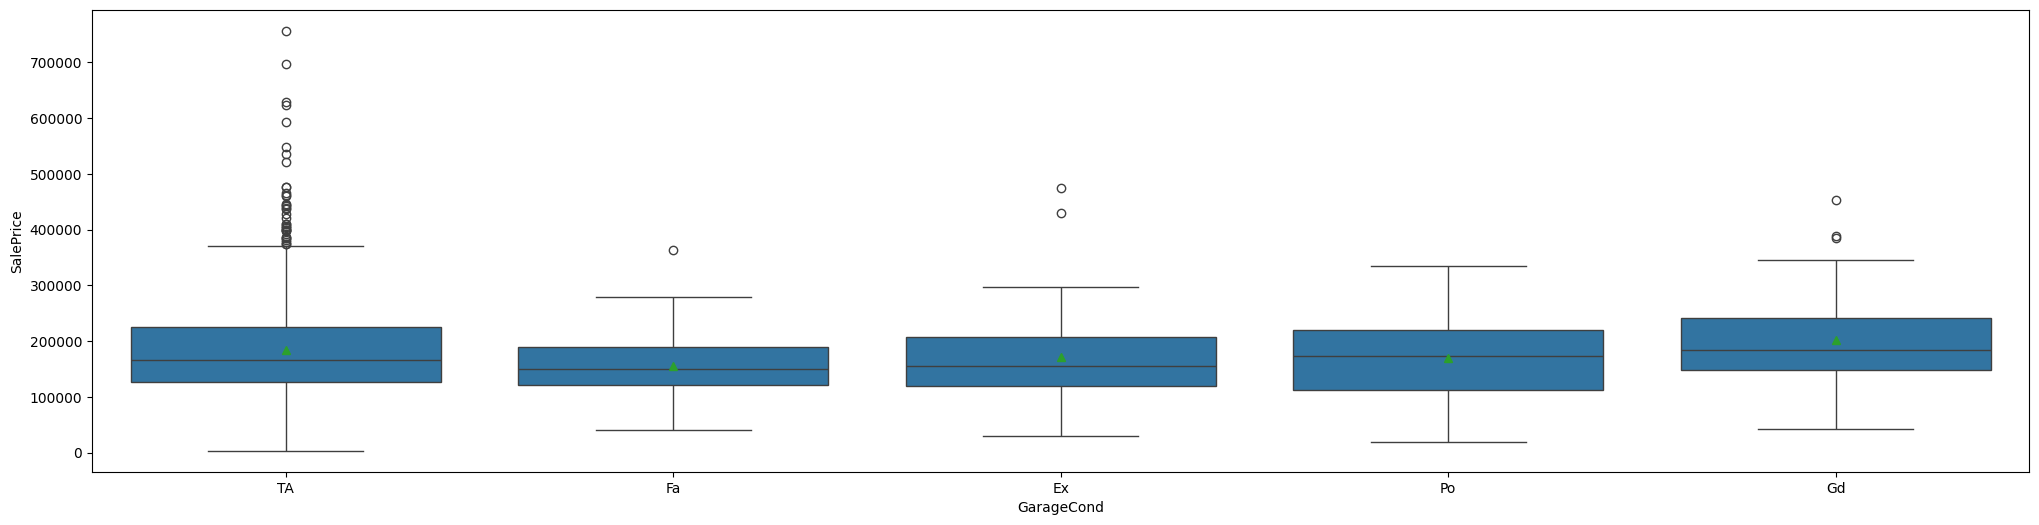

In [135]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "GarageCond",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll **remove this feature** since it's similar to the previous feature

## PavedDrive

In [136]:
train_set['PavedDrive'].value_counts(dropna=False)

PavedDrive
Y    950
N    135
P     83
Name: count, dtype: int64

<Axes: xlabel='PavedDrive', ylabel='SalePrice'>

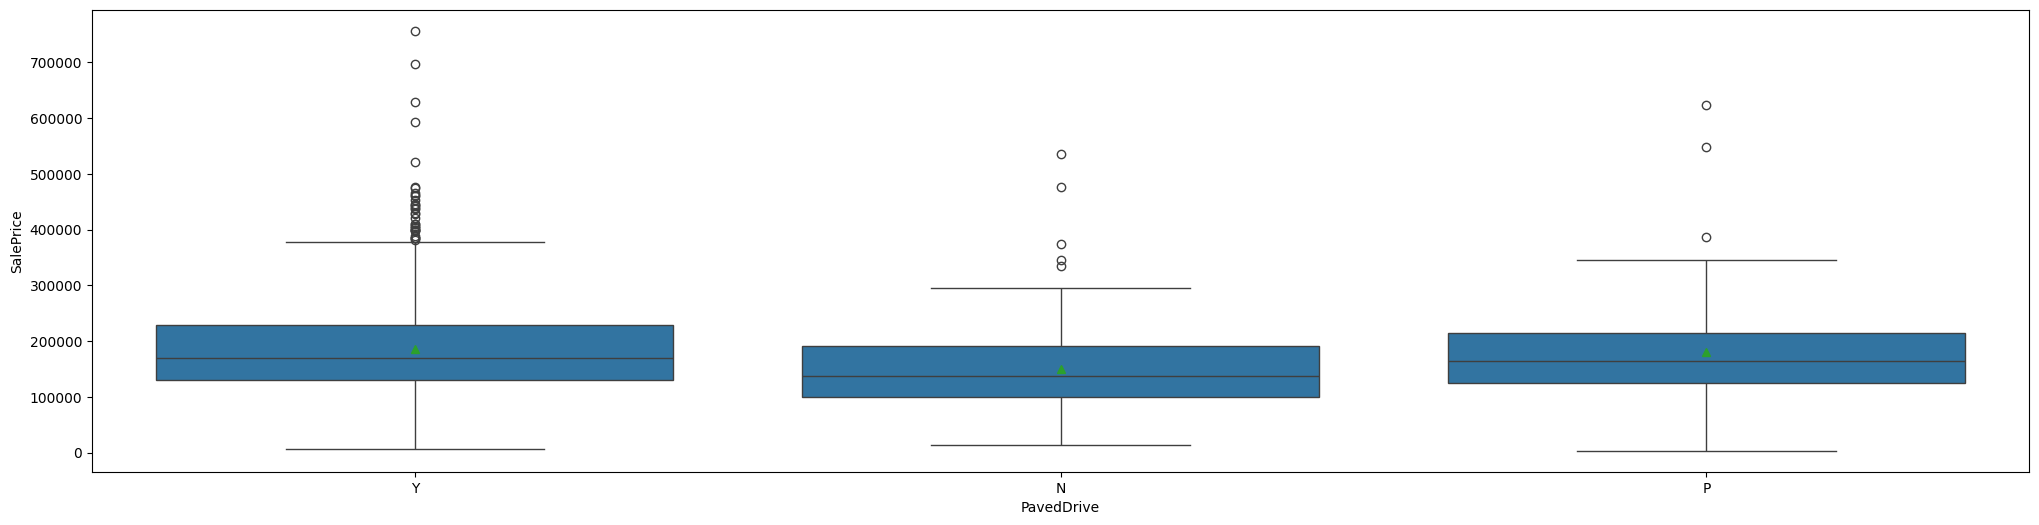

In [137]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "PavedDrive",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll use one hot encoding since there are not many values in this feature

## MiscFeature

In [138]:
train_set['MiscFeature'].value_counts(dropna=False)

MiscFeature
NA      501
Othr    487
Shed     75
Gar2     56
TenC     49
Name: count, dtype: int64

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

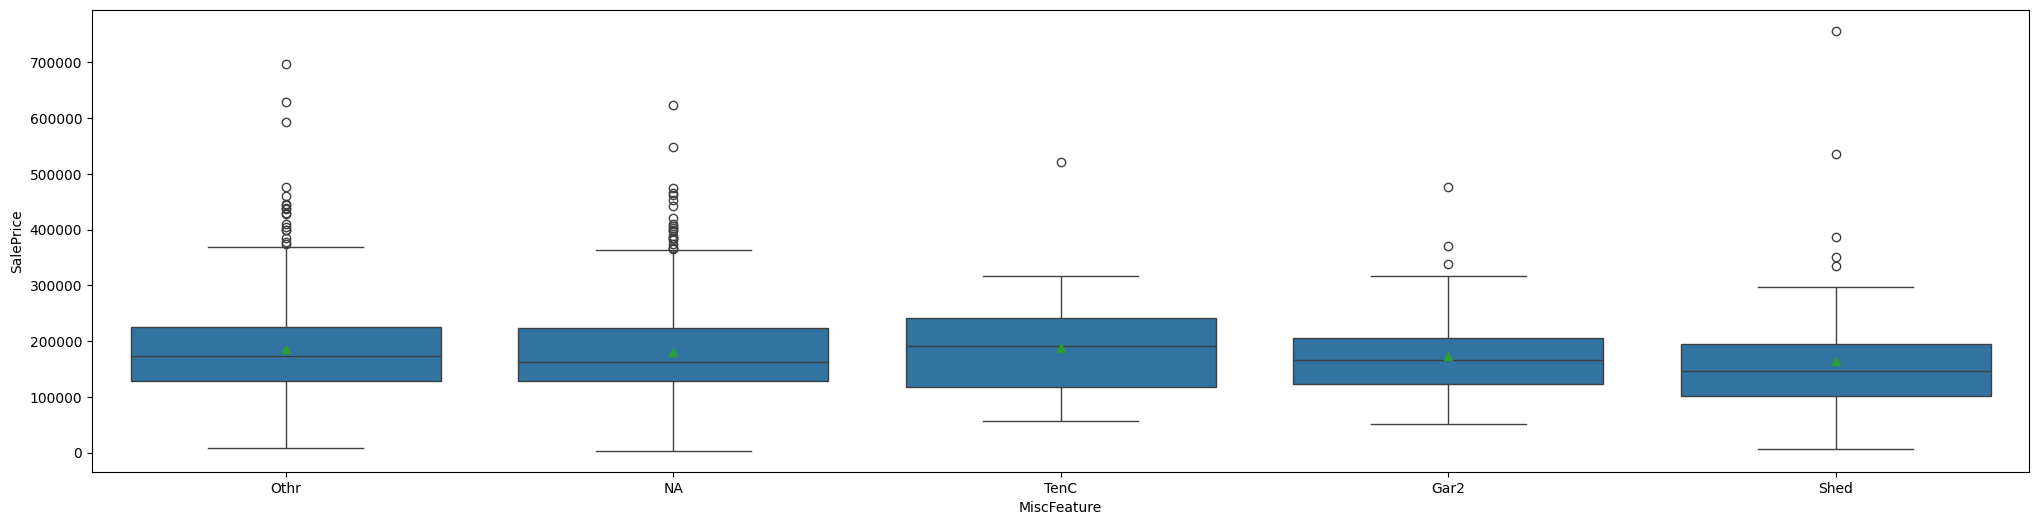

In [139]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "MiscFeature",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll use one hot encoding since there isn't any hierarchy in this feature

## SaleType

In [140]:
train_set['SaleType'].value_counts(dropna=False)

SaleType
WD       828
New      113
COD       66
ConLw     38
ConLD     30
Oth       28
ConLI     27
CWD       23
Con       15
Name: count, dtype: int64

<Axes: xlabel='SaleType', ylabel='SalePrice'>

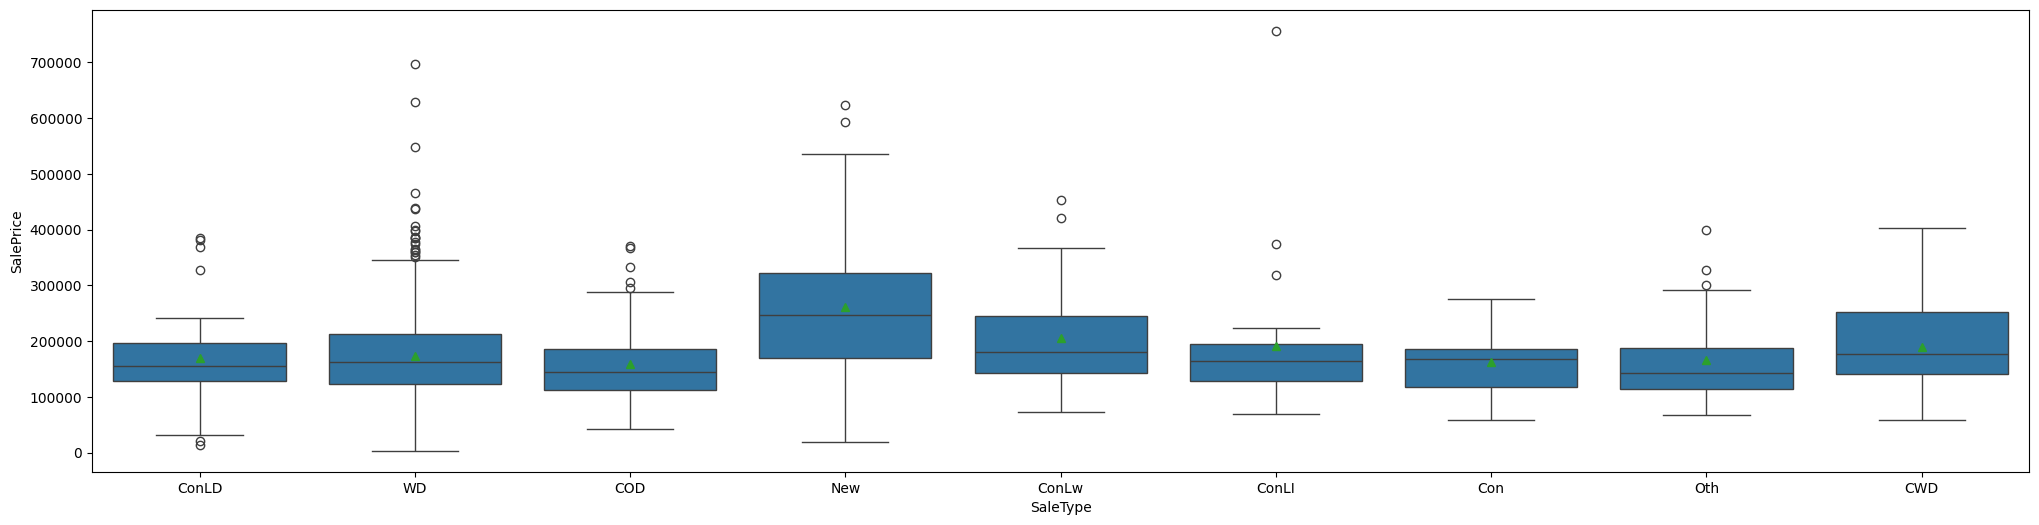

In [141]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "SaleType",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

### We'll reduce the number of categories and do one hot encoding since there isn't significant difference between warranty values, contract values etc.

In [142]:
# Define mapping dictionary based on the specified logic
sale_type_mapping = {
    'WD': 'WD',  # All variations of WD will have the same value
    'CWD': 'WD',
    'VWD': 'WD',
    'New': 'New',  # New has a different value
    'COD': 'COD',  # COD has a different value
    'Con': 'CON',  # All variations of Con will have the same value
    'ConLw': 'CON',
    'ConLI': 'CON',
    'ConLD': 'CON',
    'Oth': 'Other'
}

# Map 'SaleType' column to numerical values based on the mapping dictionary
train_set['SaleType'] = train_set['SaleType'].map(sale_type_mapping)
test_set['SaleType'] = test_set['SaleType'].map(sale_type_mapping)

# Display the transformed DataFrame
train_set['SaleType'].value_counts(dropna=False)

SaleType
WD       851
New      113
CON      110
COD       66
Other     28
Name: count, dtype: int64

## SaleCondition

In [143]:
train_set['SaleCondition'].value_counts(dropna=False)

SaleCondition
Normal     809
Abnorml    111
Partial    107
Family      55
Alloca      46
AdjLand     40
Name: count, dtype: int64

<Axes: xlabel='SaleCondition', ylabel='SalePrice'>

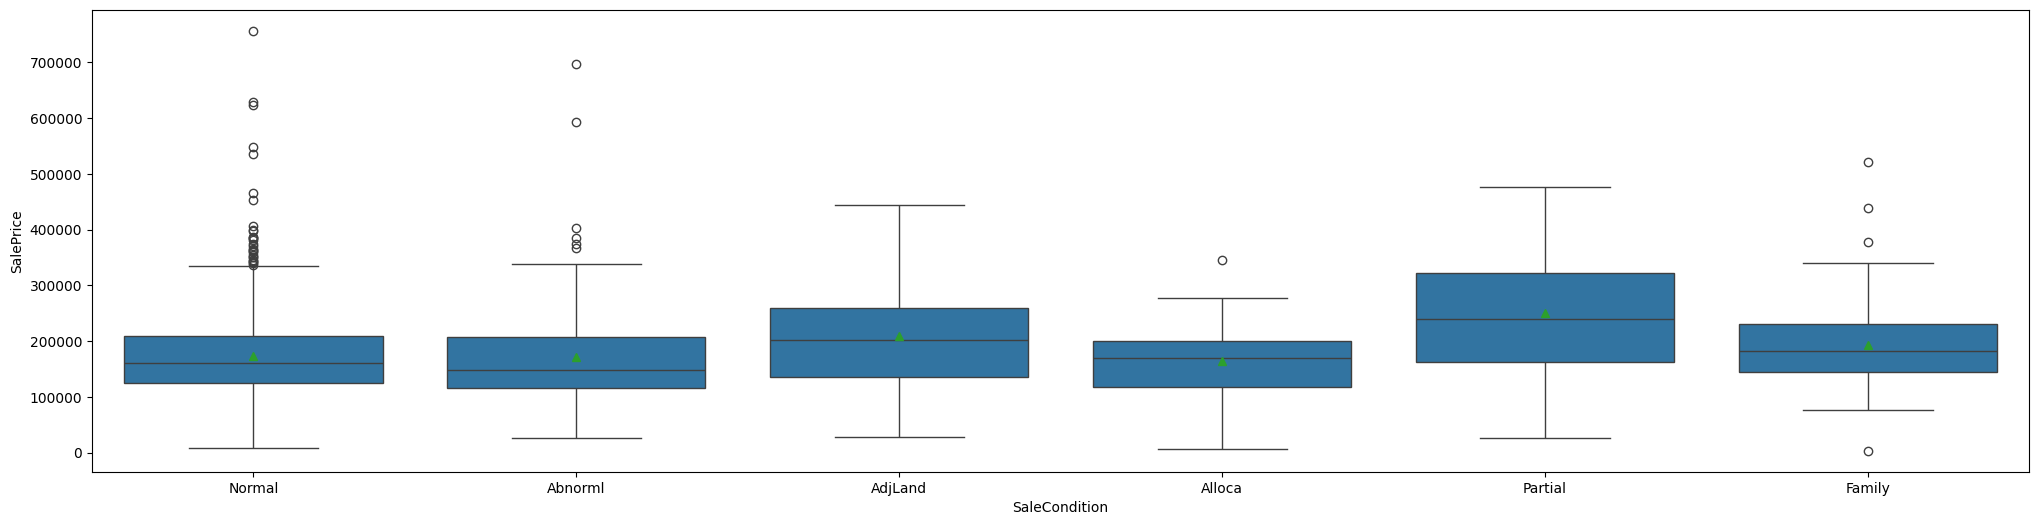

In [144]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(
    x = "SaleCondition",
    y = "SalePrice",
    showmeans=True,
    data=train_set,
    width=0.8,

)

#Part D2.1 - Final Features Removal Before Training

In [145]:
train_labels = train_set[['SalePrice']]
train_set = train_set.drop(columns = ['GarageCond', 'SalePrice'])
test_set = test_set.drop(columns = ['GarageCond'])

### As explained, GarageCond was very similar to another feature. SalePrice should be removed from the train set before the K-fold cross validation.

#Part D2.2 - One Hot Encoding

In [146]:
columns_one_hot= ['Neighborhood', 'LandSlope', 'LotConfig','BldgType', 'HouseStyle', 'MasVnrType','RoofStyle', 'Foundation', 'Heating', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleCondition', 'SaleType' ]
all_cols = train_set.columns
one_hot_train = pd.get_dummies(train_set, columns = columns_one_hot)
one_hot_test = pd.get_dummies(test_set, columns = columns_one_hot)


columns_needed = [col for col in all_cols if col not in columns_one_hot]
for col in one_hot_train.columns:
  one_hot_train[col] = one_hot_train[col].apply(lambda x: 1 if x==True else 0)
  try:
    one_hot_test[col] = one_hot_test[col].apply(lambda x: 1 if x==True else 0)
  except Exception:
    print ("The following column doesn't exist in the test set: ", col)
    one_hot_test[col] = 0


train_set = train_set.loc[:,columns_needed]
test_set = test_set.loc[:,columns_needed]
train_set = pd.concat([train_set, one_hot_train], axis = 1)
test_set = pd.concat([test_set, one_hot_test], axis = 1)

The following column doesn't exist in the test set:  GarageType_NA
The following column doesn't exist in the test set:  MiscFeature_NA


<ipython-input-146-22809f96dc2a>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_test[col] = 0
<ipython-input-146-22809f96dc2a>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_test[col] = 0


#Part D3 - Finding High Correlations Between The Final Version of the Features

In [147]:
corr_matrix = train_set.corr()
high_correlations = corr_matrix.stack()
high_correlations = high_correlations[(high_correlations.abs() > 0.7) & (high_correlations != 1)]

# Print the correlation pairs (excluding the diagonal where correlation is 1)
if not high_correlations.empty:
    print("High Correlations (above 0.7 or below -0.7):")
    print(high_correlations.to_frame(name='correlation').reset_index())
else:
    print("No high correlations found.")

high_correlations = pd.DataFrame(high_correlations).reset_index()
high_correlations = high_correlations.loc[high_correlations['level_0'] != high_correlations['level_1']]
high_correlations

High Correlations (above 0.7 or below -0.7):
               level_0             level_1  correlation
0            YearBuilt         GarageYrBlt     0.703953
1         BsmtFullBath        BsmtFullBath     0.900659
2         BsmtHalfBath        BsmtHalfBath     0.971218
3             FullBath            FullBath    -0.906131
4             HalfBath            HalfBath     0.924001
5         KitchenAbvGr        KitchenAbvGr    -0.984023
6          GarageYrBlt           YearBuilt     0.703953
7            is_luxury    MiscFeature_TenC     0.776933
8      LivingRoomRatio       BasementRatio     0.875926
9        BasementRatio     LivingRoomRatio     0.875926
10         OverallQual         OverallCond     0.706804
11         OverallCond         OverallQual     0.706804
12        BsmtFullBath        BsmtFullBath     0.900659
13        BsmtHalfBath        BsmtHalfBath     0.971218
14            FullBath            FullBath    -0.906131
15            HalfBath            HalfBath     0.924001
16 

level_0             level_1         0
0            YearBuilt         GarageYrBlt  0.703953
6          GarageYrBlt           YearBuilt  0.703953
7            is_luxury    MiscFeature_TenC  0.776933
8      LivingRoomRatio       BasementRatio  0.875926
9        BasementRatio     LivingRoomRatio  0.875926
10         OverallQual         OverallCond  0.706804
11         OverallCond         OverallQual  0.706804
17           is_luxury    MiscFeature_TenC  0.776933
18       LandSlope_Gtl       LandSlope_Mod -0.725052
19       LandSlope_Mod       LandSlope_Gtl -0.725052
20  MasVnrType_BrkFace     MasVnrType_None -0.710175
21     MasVnrType_None  MasVnrType_BrkFace -0.710175
22        PavedDrive_N        PavedDrive_Y -0.754658
23        PavedDrive_Y        PavedDrive_N -0.754658
24      MiscFeature_NA    MiscFeature_Othr -0.732904
25    MiscFeature_Othr      MiscFeature_NA -0.732904
26    MiscFeature_TenC           is_luxury  0.776933
27    MiscFeature_TenC           is_luxury  0.776933

##We can see that there is high correlation between:
-Year Built and Garage Year Built, we will remove the garage year built feature because it's too specific and there are assets without garage.
-Overall quality and overall condition  - we will remove overall quality (arbitrary).

The rest are "artificial" features that we added, so it's reasonable to have high correlation between them. We won't remove them.

In [148]:
train_set = train_set.drop(columns = ['GarageYrBlt', 'OverallQual'])
test_set = test_set.drop(columns = ['GarageYrBlt', 'OverallQual'])

columns_needed = [col for col in train_set.columns]
train_set = train_set.loc[:,columns_needed]
test_set = test_set.loc[:,columns_needed]

#**Part E - Normalization, PCA**

##Scaling

We chose To use Robust Scaler because its ability to handle with outliers. We think that in our dataset, **there is a large importance for extremum values** - because they can point on a luxury asset / very poor asset, and **thus affect the price.**

In [149]:
scaler = RobustScaler()
scaled_train_set = scaler.fit_transform(train_set)
scaled_test_set = scaler.transform(test_set)

In [150]:
headers = train_set.columns
len(headers)

290

##PCA

**We have 290 features, it might cause overfitting so we sohuld reduce the dimensions**

In [151]:
def pca_func(train_set,test_set,tot_var):
    global headers
    pca = PCA(tot_var)
    pca.fit(train_set)
    transformed_train_set = pd.DataFrame(pca.transform(train_set))
    transformed_test_set = pd.DataFrame(pca.transform(test_set))
    display ('Before PCA: There were '+ str(pca.n_features_) +' features in the dataframe,'
           ' and after the PCA procedure we have ' +str(transformed_train_set.shape[1])+' features.')

    explained_variance = pca.explained_variance_ratio_
    components = pca.components_

    display('Explained Variance Ratio:')
    display(pd.DataFrame(explained_variance, columns=['Explained Variance']))

    display('Components:')
    display(pd.DataFrame(components, columns=headers))

    return transformed_train_set,transformed_test_set

train_after_pca, test_after_pca = pca_func(scaled_train_set,scaled_test_set,0.95)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


'Before PCA: There were 290 features in the dataframe, and after the PCA procedure we have 20 features.'

'Explained Variance Ratio:'

Explained Variance
0             0.680389
1             0.045842
2             0.040047
3             0.033947
4             0.031368
5             0.027425
6             0.024951
7             0.014466
8             0.011920
9             0.006187
10            0.005453
11            0.004502
12            0.003950
13            0.003834
14            0.003290
15            0.003060
16            0.002993
17            0.002920
18            0.002701
19            0.002516

'Components:'

MSSubClass    MSSubClass  MSZoning  MSZoning  LotFrontage   LotFrontage  \
0     0.001700  1.110223e-16  0.000295  0.000824    -0.001829  0.000000e+00   
1    -0.004884  1.942890e-16 -0.001372  0.000647    -0.000918  5.551115e-17   
2     0.006515  8.326673e-17  0.000621 -0.001894     0.049634  1.110223e-16   
3     0.005223 -1.942890e-16  0.010539  0.009922    -0.012016  0.000000e+00   
4    -0.004657 -1.110223e-16 -0.004273 -0.000450    -0.007673 -1.110223e-16   
5    -0.004440  4.857226e-17 -0.004921 -0.002763     0.025631 -2.220446e-16   
6    -0.010683  2.775558e-16 -0.014740 -0.008051     0.014098  1.665335e-16   
7     0.012972  1.387779e-16  0.022944  0.034696    -0.069142 -6.938894e-17   
8    -0.024064 -5.551115e-17 -0.038597 -0.031510     0.178643  1.110223e-16   
9    -0.165618 -6.661338e-16 -0.072007 -0.021922     0.186979  1.665335e-16   
10   -0.148172  1.110223e-16 -0.072351 -0.031545     0.087726 -5.551115e-17   
11    0.089146 -2.775558e-16  0.018576  0.000286    -0.022351 -3.122502e-16   
12    0.133871 -5.273559e-16  0.063245  0.043680    -0.350306 -9.714451e-17   
13    0.088247 -1.526557e-16  0.024788 -0.002840    -0.270945  5.559789e-16   
14    0.026069 -5.204170e-17  0.028484  0.032942    -0.141413 -1.118897e-16   
15   -0.068001 -1.110223e-16  0.077747  0.024012     0.013787  2.428613e-17   
16    0.004472  1.144917e-16 -0.101703 -0.032817    -0.051272  4.436555e-16   
17    0.029705  3.920475e-16  0.104790  0.063305    -0.087240 -3.642919e-17   
18    0.088161  4.440892e-16 -0.030447  0.013031    -0.198378 -1.526557e-16   
19    0.079593  3.469447e-16  0.011509  0.020279    -0.127287 -3.885781e-16   

     LotArea       LotArea    Street    Street  ...  SaleCondition_AdjLand  \
0  -0.009520  0.000000e+00  0.000243  0.000243  ...               0.000344   
1   0.009134  2.775558e-17  0.000440  0.000440  ...               0.000118   
2   0.035054 -0.000000e+00  0.001496  0.001496  ...              -0.000155   
3  -0.010975 -2.498002e-16 -0.002117 -0.002117  ...               0.000942   
4   0.015344  0.000000e+00 -0.002121 -0.002121  ...              -0.000908   
5  -0.002681  1.387779e-16  0.001983  0.001983  ...               0.001988   
6   0.026770 -1.110223e-16  0.000869  0.000869  ...              -0.000042   
7  -0.096035  3.330669e-16  0.005340  0.005340  ...              -0.000041   
8   0.163425  0.000000e+00 -0.000190 -0.000190  ...               0.000849   
9   0.474809  2.844947e-16 -0.005461 -0.005461  ...               0.000013   
10  0.003707  5.551115e-17 -0.011025 -0.011025  ...              -0.000105   
11  0.301409  2.498002e-16 -0.015725 -0.015725  ...               0.002575   
12  0.218077  4.440892e-16 -0.004544 -0.004544  ...              -0.003059   
13  0.231465 -1.110223e-16 -0.000877 -0.000877  ...               0.005032   
14  0.058102 -5.898060e-17 -0.003884 -0.003884  ...               0.009084   
15  0.036383 -1.110223e-16  0.009501  0.009501  ...              -0.003861   
16 -0.002226  5.117434e-17  0.005535  0.005535  ...              -0.001010   
17  0.008842 -4.510281e-17  0.012604  0.012604  ...               0.007492   
18 -0.079999  1.457168e-16 -0.000276 -0.000276  ...               0.002944   
19 -0.038608  7.632783e-17  0.003058  0.003058  ...              -0.000032   

    SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0              -0.000193             -0.000224              0.000338   
1              -0.000157             -0.000277              0.000331   
2               0.002179              0.001398             -0.007164   
3               0.000188              0.001093             -0.002347   
4              -0.000058             -0.000086              0.004371   
5               0.003318             -0.002470             -0.006193   
6               0.000262              0.003823             -0.005738   
7              -0.001297             -0.000482              0.016863   
8              -0.001600              0.002101           

**Important conclusion - The PCA minimized our enormous ammount of features to 20 components that explain 95% of the variance!**

#**Part F - Training**

####We used grid search for selecting the best hyper-parameters for each model

##Grid Search Function

In [152]:
#define a gridsearch function for us to use down the road
def GridSearch(model,initialParams):
    global train_after_pca
    global train_labels
    kfold = sklearn.model_selection.KFold(n_splits = 10, random_state = 42, shuffle=True)
    GridSearch_instance = GridSearchCV(model, initialParams, cv = kfold, scoring='neg_mean_absolute_error')
    GridSearch_instance.fit(X = train_after_pca,y = np.array(train_labels).ravel())

    #return the best parameters found by Gridsearch
    return GridSearch_instance.best_params_

##4 Models

###CatBoost Regressor


**2 runs - one with the train set before one hot encoding because Catboost does it better, and another run with the dataset after PCA**

In [153]:
#Here we trained the catboost model on the data before the one-hot encoding and PCA procedures, since this model handles categorical features better.
catboost_model = cb.CatBoostRegressor(loss_function='MAE')
params = {'iterations': [20, 30, 50],
        'learning_rate': [0.001, 0.01, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

train_set_for_cb, val_set_for_cb, train_labels_for_cb, val_labels_for_cb= train_test_split(scaled_train_set,train_labels,  test_size = 0.2)
train_catboost = cb.Pool(train_set_for_cb, train_labels_for_cb)
val_catboost = cb.Pool(val_set_for_cb, val_labels_for_cb)
catboost_model.grid_search(params, train_catboost)
pred = catboost_model.predict(val_catboost)
mae_catboost = mae(pred, val_labels_for_cb)
mae_catboost

Streaming output truncated to the last 5000 lines.
1:	learn: 151405.9839868	test: 149020.2847490	best: 149020.2847490 (1)	total: 7.8ms	remaining: 109ms
2:	learn: 138139.4800113	test: 135797.0938705	best: 135797.0938705 (2)	total: 10.1ms	remaining: 91ms
3:	learn: 126060.5329636	test: 123401.8178998	best: 123401.8178998 (3)	total: 12.1ms	remaining: 78.4ms
4:	learn: 115904.1913341	test: 113285.7534284	best: 113285.7534284 (4)	total: 14.1ms	remaining: 70.4ms
5:	learn: 107187.5981033	test: 104898.4574160	best: 104898.4574160 (5)	total: 16ms	remaining: 64.1ms
6:	learn: 99585.0323602	test: 97723.5886542	best: 97723.5886542 (6)	total: 17.9ms	remaining: 58.9ms
7:	learn: 93062.5051029	test: 91881.9830215	best: 91881.9830215 (7)	total: 19.8ms	remaining: 54.4ms
8:	learn: 87682.2734503	test: 87206.9230388	best: 87206.9230388 (8)	total: 22.1ms	remaining: 51.5ms
9:	learn: 82824.2293705	test: 82801.9325420	best: 82801.9325420 (9)	total: 24.2ms	remaining: 48.4ms
10:	learn: 77923.4158644	test: 78427.581

46392.11143741396

In [154]:
print("Validation MAE:", mae_catboost)

Validation MAE: 46392.11143741396


In [155]:
#Here we trained the model on the data after the one-hot encoding the PCA procedures
catboost_model = cb.CatBoostRegressor(loss_function='MAE')
params = {'iterations': [20, 30, 50],
        'learning_rate': [0.001, 0.01, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

train_set_for_cb, val_set_for_cb, train_labels_for_cb, val_labels_for_cb= train_test_split(train_after_pca,train_labels,  test_size = 0.2)
train_catboost = cb.Pool(train_set_for_cb, train_labels_for_cb)
val_catboost = cb.Pool(val_set_for_cb, val_labels_for_cb)
catboost_model.grid_search(params, train_catboost)
pred = catboost_model.predict(val_catboost)
mae_catboost = mae(pred, val_labels_for_cb)
mae_catboost

Streaming output truncated to the last 5000 lines.
1:	learn: 152377.3103538	test: 144528.1728021	best: 144528.1728021 (1)	total: 1.98ms	remaining: 27.7ms
2:	learn: 139246.4446015	test: 131912.0423158	best: 131912.0423158 (2)	total: 3.02ms	remaining: 27.1ms
3:	learn: 127417.2918320	test: 120386.0385018	best: 120386.0385018 (3)	total: 4.08ms	remaining: 26.5ms
4:	learn: 117274.5874259	test: 110573.3651760	best: 110573.3651760 (4)	total: 5.13ms	remaining: 25.7ms
5:	learn: 108426.5396029	test: 102134.9808742	best: 102134.9808742 (5)	total: 6.3ms	remaining: 25.2ms
6:	learn: 100638.6973336	test: 94425.2099285	best: 94425.2099285 (6)	total: 7.36ms	remaining: 24.2ms
7:	learn: 94257.4749124	test: 88146.0562297	best: 88146.0562297 (7)	total: 8.41ms	remaining: 23.1ms
8:	learn: 88793.7983507	test: 83116.6885823	best: 83116.6885823 (8)	total: 9.51ms	remaining: 22.2ms
9:	learn: 84117.0991362	test: 78836.4232802	best: 78836.4232802 (9)	total: 10.6ms	remaining: 21.2ms
10:	learn: 79539.7233493	test: 747

48311.88473966211

###Random Forest Regressor

In [156]:
random_forest_params = {'n_estimators':[10, 15, 20, 25],
                                      'max_depth':[5, 10, 15, 25, 30, 50, 80, 100],
                                      'min_samples_split':[1, 3, 5, 10, 15, 20],
                                      'min_samples_leaf':[1, 3, 5, 7, 10],
                                      'max_features':['None', 'sqrt', 'log2'],
                                      'random_state':[42]}
random_forest_best_params = GridSearch(RandomForestRegressor(), random_forest_params)
random_forest_best_params

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12800 fits failed out of a total of 28800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklea

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 25,
 'random_state': 42}

###Third Model - Elastic network

In [157]:
base_elastic_model = ElasticNet()
param_grid = {'max_iter': [100, 1000, 10000],
              'alpha':[0.1,1,10,100],
             'l1_ratio':[0.1,0.3, 0.5, 0.75,0.99,1],
              'fit_intercept': [True, False],
              'precompute': [True, False],
              'positive': [True, False],
              'warm_start': [True, False],
              'random_state':[42],
              'copy_X':[True],
              'selection':['cyclic', 'random']}
elastic_model_best_params = GridSearch(base_elastic_model, param_grid)
elastic_model_best_params

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 100,
 'positive': False,
 'precompute': True,
 'random_state': 42,
 'selection': 'random',
 'warm_start': True}

In [158]:
# Define the ElasticNet model with specified parameters
elastic_model = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=100, fit_intercept=True,
                           precompute=True, positive=False, random_state=42,
                           selection='random', warm_start=True, copy_X=True)

# Split the dataset into training and validation sets
train_set_for_en, val_set_for_en, train_labels_for_en, val_labels_for_en = train_test_split(train_after_pca, train_labels, test_size=0.2, random_state=42)

# Train the ElasticNet model on the training data
elastic_model.fit(train_set_for_en, train_labels_for_en)

# Make predictions on the validation set
pred = elastic_model.predict(val_set_for_en)

# Calculate Mean Absolute Error (MAE) on the validation set
mae_elastic = mae(pred, val_labels_for_en)
mae_elastic

48399.84689725115

##Fourth Model - XG Boost

**We tried to run XGboost as well but it was worse compared to ElasticNet for us**

In [159]:
# # Define the parameter grid for GridSearch
# params_grid = {
#   'max_depth': [3, 5, 7],
#   'learning_rate': [0.01, 0.1],
#   'n_estimators': [5, 10, 100, 200],
#   'subsample': [0.7, 1],
#   'colsample_bytree': [0.6, 1],
#   'min_child_weight': [1, 3, 5],
#   'gamma': [0, 0.3, 1]
# }

# xgb_best_params = GridSearch(xgb.XGBRegressor(objective='reg:absoluteerror'), params_grid)
# xgb_best_params

##KFold For training

In [160]:
def KfoldPlot(train_df, df_labels, regressors, regressor_names, k):
    models_mae = {}
    # Splitting our data by applying the KFold , and iterating on each fold
    KF = KFold(n_splits=k, shuffle=True, random_state=42)
    mean_mae_validation = []
    mean_mae_train = []
    for train_index, validation_index in KF.split(train_df):
        # Using the fold's indices to split the data and its outcome labels into a train dataset and a validation dataset
        train_data, validation_set = train_df.iloc[list(train_index),:], train_df.iloc[list(validation_index),:]
        train_labels = df_labels.iloc[list(train_index), :]
        labels_validation = df_labels.iloc[validation_index, :]

        # Fitting the regressors on the train dataset
        for regressor, regressor_name in zip(regressors, regressor_names):

          regressor.fit(train_data, train_labels)

          # Predicting the labels on the validation dataset
          predictions_validation = regressor.predict(validation_set)
          predictions_train = regressor.predict(train_data)

          # Calculating the MAE score on the validation dataset
          mae_validation = mae(labels_validation, predictions_validation)
          mean_mae_validation.append(mae_validation)

          # Calculating the MAE score on the train dataset
          mae_train = mae(train_labels, predictions_train)
          mean_mae_train.append(mae_train)
          try:
            models_mae[f"{regressor_name}_train"].append(mae_train)
            models_mae[f"{regressor_name}_validation"].append(mae_validation)
          except:
            models_mae[f"{regressor_name}_train"] = []
            models_mae[f"{regressor_name}_validation"] = []
            models_mae[f"{regressor_name}_train"].append(mae_train)
            models_mae[f"{regressor_name}_validation"].append(mae_validation)
    #find the best model
    for key in models_mae.keys():
      models_mae[key] = sum(models_mae[key]) / len(models_mae[key])
    validations_mae = [key for key in models_mae.keys() if 'validation' in key]
    best_model = min(validations_mae, key = models_mae.get)[:-11]
    print(f"Best model: {best_model}")
    print (f"Train MAE: ", models_mae[f"{best_model}_train"])
    print (f"Validation MAE: ", models_mae[f"{best_model}_validation"])
    return regressor

regressor_names = ["Random Forest", 'Elastic Net']
regressors = [RandomForestRegressor(**random_forest_best_params),ElasticNet(**elastic_model_best_params)]

best_regressor = KfoldPlot(train_after_pca, train_labels, regressors, regressor_names,10)

<ipython-input-160-19586fd1b509>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(train_data, train_labels)
<ipython-input-160-19586fd1b509>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(train_data, train_labels)
<ipython-input-160-19586fd1b509>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(train_data, train_labels)
<ipython-input-160-19586fd1b509>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(train_data, train_labels)
<ipython-input-160-19586fd1b509>:16: DataConversionWarning: A co

Best model: Elastic Net
Train MAE:  44396.34038644526
Validation MAE:  45531.68670801155


**We see that ElasticNet is the best compared to Catboost and to RandomForest. Catboost was overfitted. **

#**Part G - XAI (SHAP over the best model)**

Our analysis concluded that elastic has provided us with the best results. Here is the SHAP analysis of it.

##SHAP for Elastic

###SHAP values and Global interpretability

**The following code plots the Shap values for each feature and calculates the relative contribution of each feature to the model prediction**

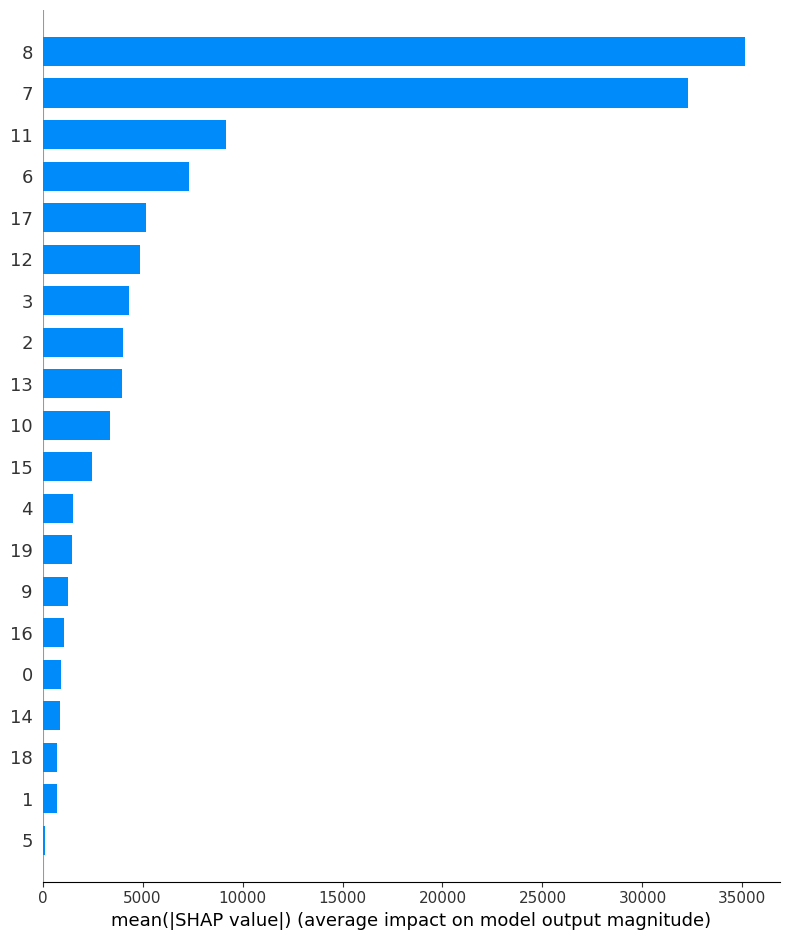

In [161]:
# Initialize the SHAP explainer with the trained ElasticNet model
explainer = shap.Explainer(elastic_model, val_set_for_en)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(val_set_for_en)

# Plot the summary plot for global interpretability
shap.summary_plot(shap_values, val_set_for_en, plot_type="bar")


###Local interpretability (3 randomized instances)

In [162]:
# Choose a specific instance for local interpretability (e.g., the first instance)
instance_index = 0

# Plot the SHAP values for the chosen instance (local interpretability)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_index, :], val_set_for_en.iloc[instance_index, :])

In [163]:
# Choose a specific instance for local interpretability (e.g., the 120 instance)
instance_index = 119

# Plot the SHAP values for the chosen instance (local interpretability)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_index, :], val_set_for_en.iloc[instance_index, :])

In [164]:
# Choose a specific instance for local interpretability (e.g., the 204 instance)
instance_index = 203

# Plot the SHAP values for the chosen instance (local interpretability)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_index, :], val_set_for_en.iloc[instance_index, :])

###PCA analysis - the main contributing components

We are running PCA again, but now we would like to focus on components 7,8,11 and 17, which are seems to be the most effective on the gloabl and local interpetability, and analyze the results.

In [165]:
def pca_func(train_set, test_set, tot_var):
    global headers
    pca = PCA(tot_var)
    pca.fit(train_set)

    transformed_train_set = pd.DataFrame(pca.transform(train_set))
    transformed_test_set = pd.DataFrame(pca.transform(test_set))

    display(f'Before PCA: There were {train_set.shape[1]} features in the dataframe.')
    display(f'After the PCA procedure, we have {transformed_train_set.shape[1]} features.')

    explained_variance = pca.explained_variance_ratio_
    components = pca.components_

    display('Explained Variance Ratio:')
    display(pd.DataFrame(explained_variance, columns=['Explained Variance']))

    display('Components:')
    components_df = pd.DataFrame(components, columns=headers)
    display(components_df)

    # Analyze specified components
    components_to_analyze = [5, 6, 7, 10, 16]  # Note: these are zero-indexed (components 6, 7, 8, 11 and 17)
    for component_idx in components_to_analyze:
        component_weights = components_df.iloc[component_idx]
        highest_weight_features = component_weights.abs().nlargest(3)  # Get top 3 features by absolute weight
        # Remove duplicates
        highest_weight_features = highest_weight_features[~highest_weight_features.index.duplicated()]
        print(f"Component {component_idx+1} - Top Features:")  # component_idx+1 for 1-based index display
        print(highest_weight_features)
        print()  # Blank line for readability

    return transformed_train_set, transformed_test_set

###Conclusions

**Global Interpetability** - It seems that componeמts 7-8 have the most significant impact on the model's predicition compared to others. From the PCA analysis we ran, it seems that the original features that affect the most on components 7,8 are the porches existence (enclosed, screen), and also the general living area and the masonary veneer area.

**Local Interpetability** - It seems that Component 7 and 8 that we analyzed before have the most significant impact on the sample chosen here, together with component 6 (which is also related to porches according to our PCA components analysis). On some occasions, it seems that components 11,17 affect the price - mostly to the negative direction, and by their analysis, we can see why - both of them are made mostly from the overall condition, basement condition and the garage quality of the asset (so it makes sense that the price will be lower if the condition is poor in these important aspects).

#**Part H - Inference (Test Set)**

In [166]:
test_results = best_regressor.predict(test_after_pca)
np.savetxt("output_4.txt", test_results, delimiter=",")

#**Section 2 - Clustering**

## Import and scale the data

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
!pip install umap-learn
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler, RobustScaler


In [168]:
#Reading the files
df_cluster= pd.read_csv('/content/clustering_data.csv')
df_cluster=df_cluster.drop(columns = ['Unnamed: 0'])
df_cluster.head()

feature 1  feature 2  feature 3  feature 4  feature 5  feature 6  \
0  -1.784220   9.139177   2.517077  -6.691300   3.332583  -6.189314   
1   4.513056  -6.242134  -9.764999   8.975386   0.213133  -5.610271   
2   1.076570  -6.806062 -11.354346  11.589776   1.223487  -4.481565   
3  -0.203146  -6.098289  10.389102  -3.527880  -6.376361   3.444334   
4  -4.488164   9.539276   0.414895  -3.298754   4.835677  -6.927819   

   feature 7  feature 8  feature 9  feature 10  
0  -8.294717  -5.527558  -9.150377   -3.437419  
1   6.194787  -0.247325  -1.000023   -9.091131  
2   5.119435  -0.036395  -2.308850   -5.820222  
3  -0.331659  -3.784060  -6.922082   -3.463537  
4  -9.123490  -3.135282 -10.179017   -3.273429

In [169]:
#Checking null values
df_cluster.isna().any()

feature 1     False
feature 2     False
feature 3     False
feature 4     False
feature 5     False
feature 6     False
feature 7     False
feature 8     False
feature 9     False
feature 10    False
dtype: bool

In [170]:
#Checking the number of rows and columns
df_cluster.shape

(2500, 10)

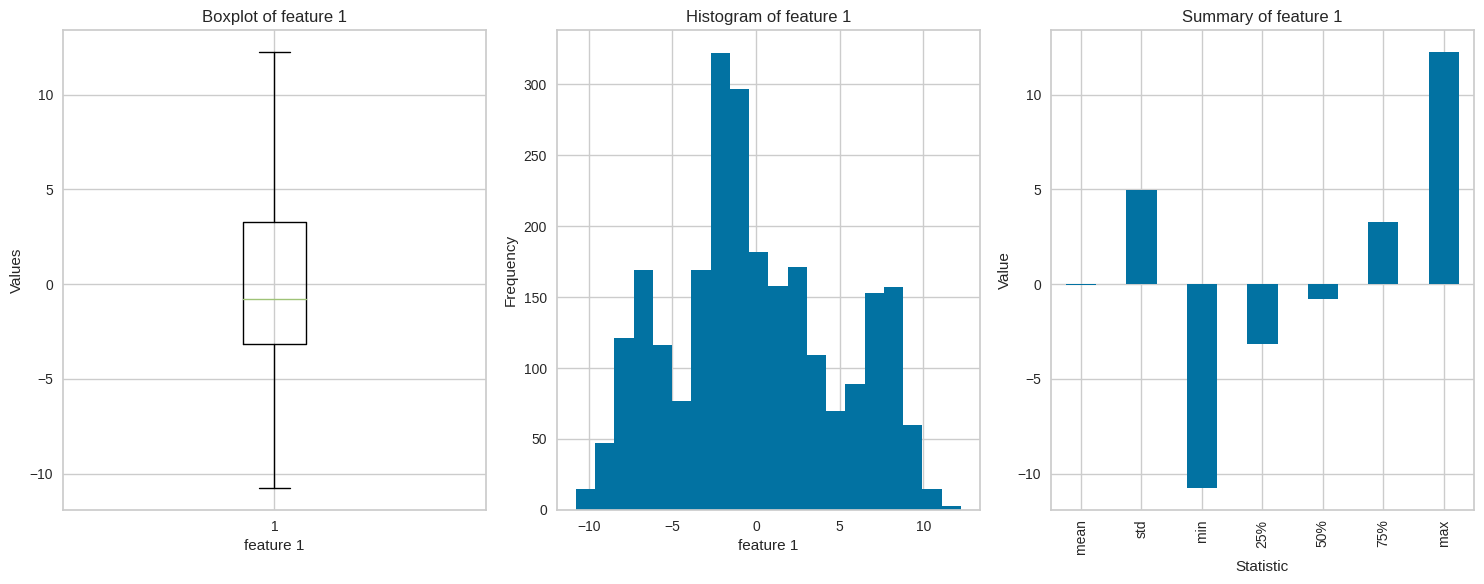

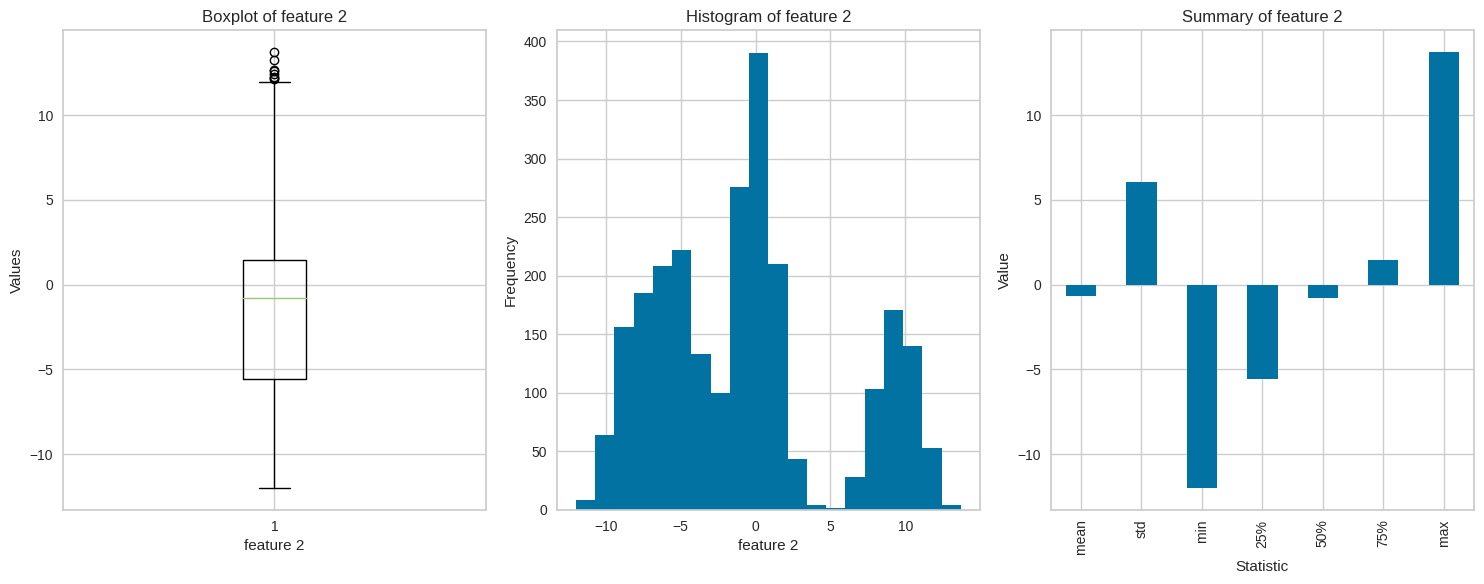

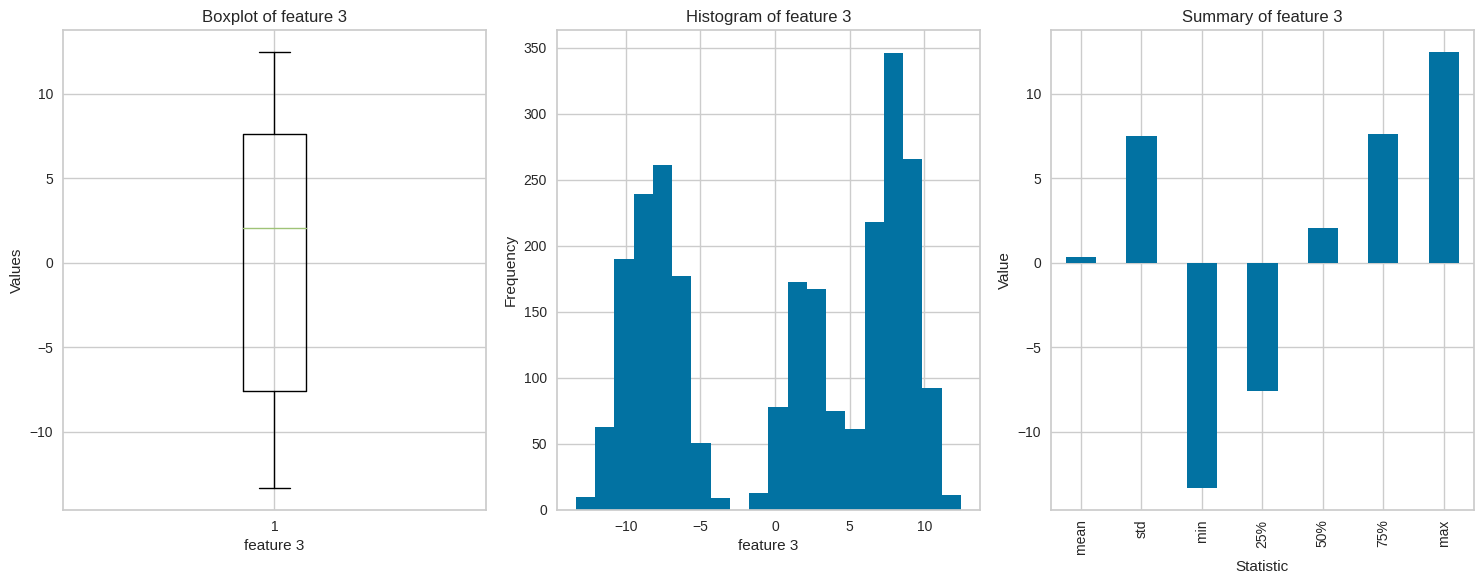

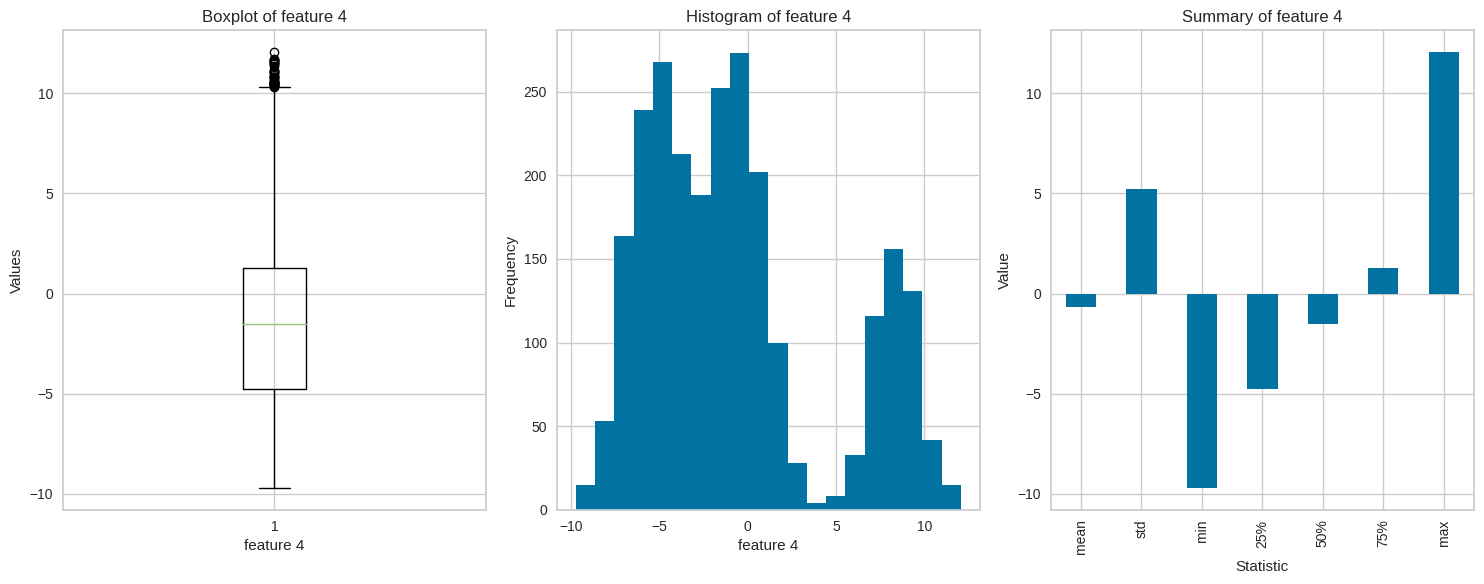

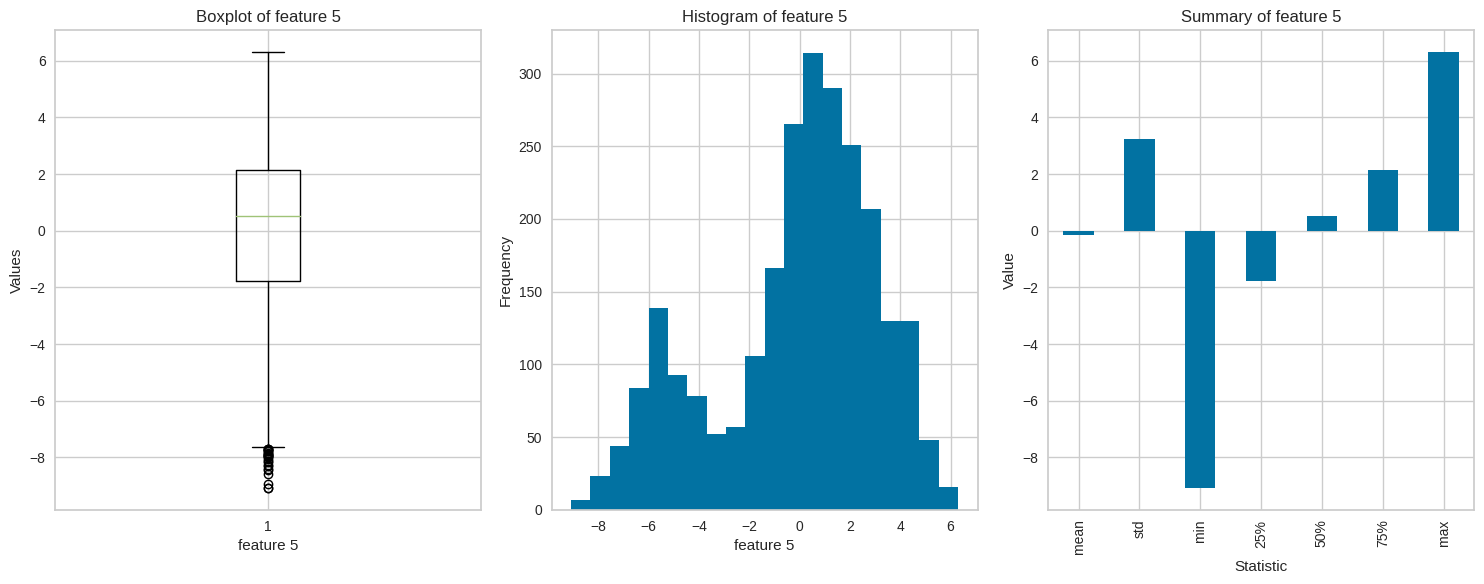

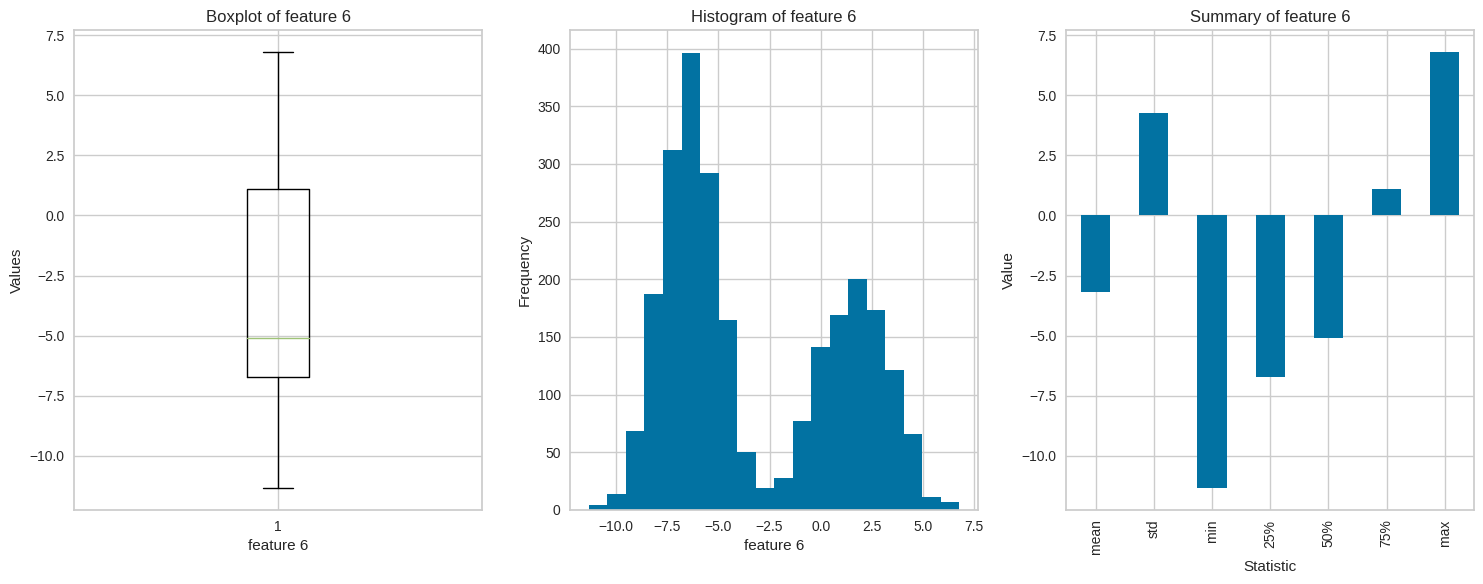

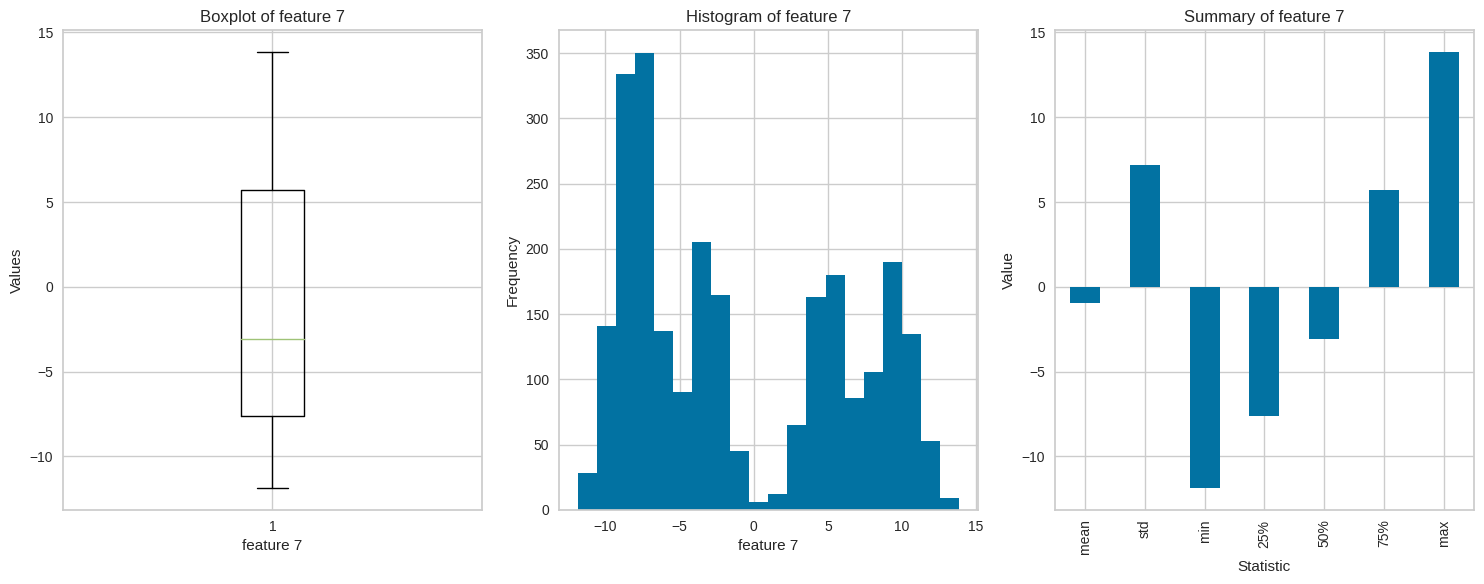

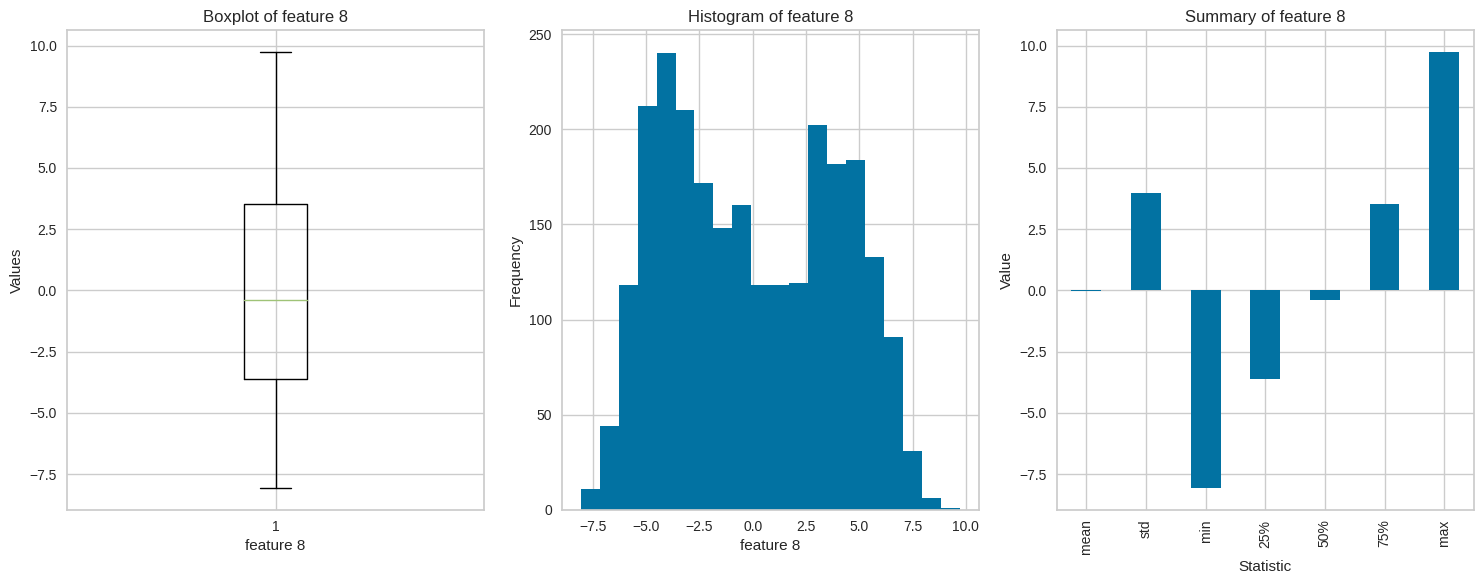

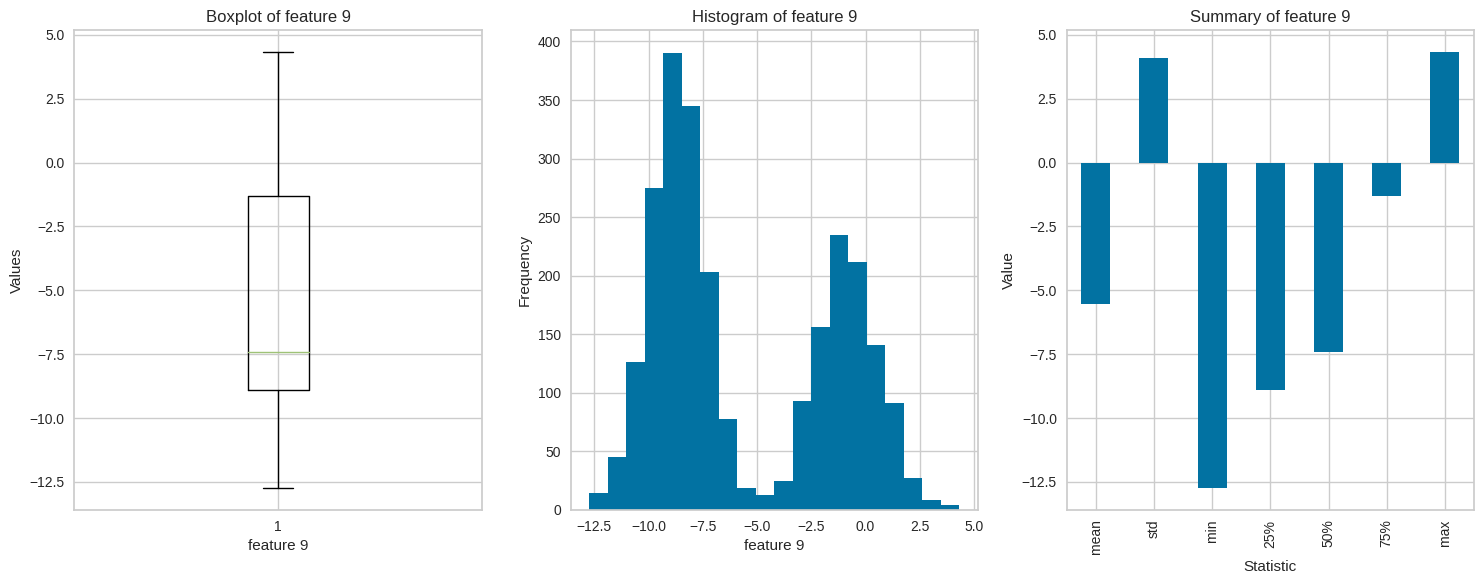

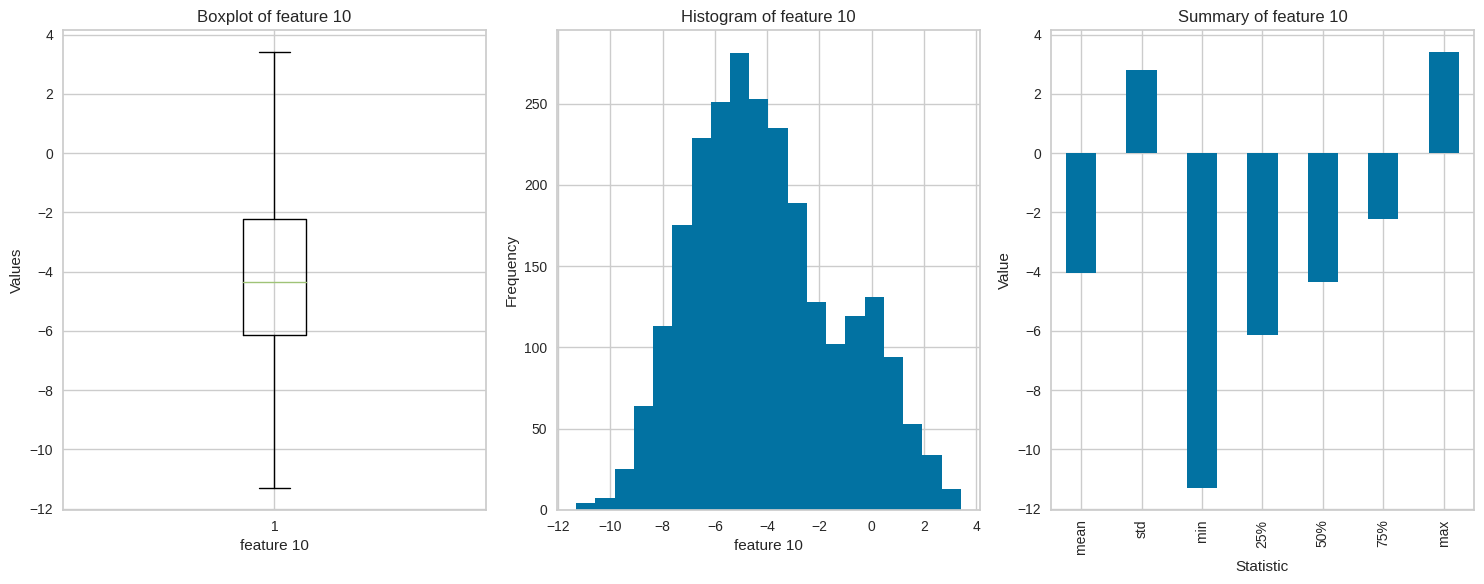

In [171]:
#Data Exploration
clustering_columns = df_cluster.columns
for col in clustering_columns:
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))

  axes[0].boxplot(df_cluster[col])
  axes[0].set_title(f'Boxplot of {col}')
  axes[0].set_xlabel(col)
  axes[0].set_ylabel('Values')

  df_cluster[col].hist(bins=20, ax=axes[1])
  axes[1].set_title(f'Histogram of {col}')
  axes[1].set_xlabel(col)
  axes[1].set_ylabel('Frequency')

  summary = df_cluster[col].describe(percentiles=[0.25, 0.75])[1:]
  summary.plot(kind='bar', ax=axes[2])
  axes[2].set_title(f'Summary of {col}')
  axes[2].set_xlabel('Statistic')
  axes[2].set_ylabel('Value')

  plt.tight_layout()
  plt.show()

In [172]:
#Scaling
#We checked RobustScaler as well but the results for Standard Scaler are better
scaled_data = StandardScaler().fit_transform(df_cluster)
# scaled_data = RobustScaler().fit_transform(df_cluster)

## Validity scores definition (silhouette, davies-bouldin)

In [173]:
def validate_score(df,labels):
  a=silhouette_score(df, labels)
  b=davies_bouldin_score(df, labels)
  display('silhouette_score:'+str(a),' davies bouldin_score: '+str(b))
  return a,b

In [174]:
reducer = umap.UMAP()
#using umap for dimensional reduction
embedding = reducer.fit_transform(scaled_data)

## K-Means

In [175]:
#using the default parameters(k=8)
kmeans = KMeans(random_state=42).fit(scaled_data)
k_means_preds=kmeans.predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [176]:
Counter(k_means_preds)

Counter({2: 237, 0: 500, 3: 253, 5: 263, 4: 500, 6: 208, 1: 292, 7: 247})

In [177]:
k_means_val=validate_score(scaled_data,k_means_preds)
k_means_val

'silhouette_score:0.35520834518433936'

' davies bouldin_score: 1.8003817589774753'

(0.35520834518433936, 1.8003817589774753)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

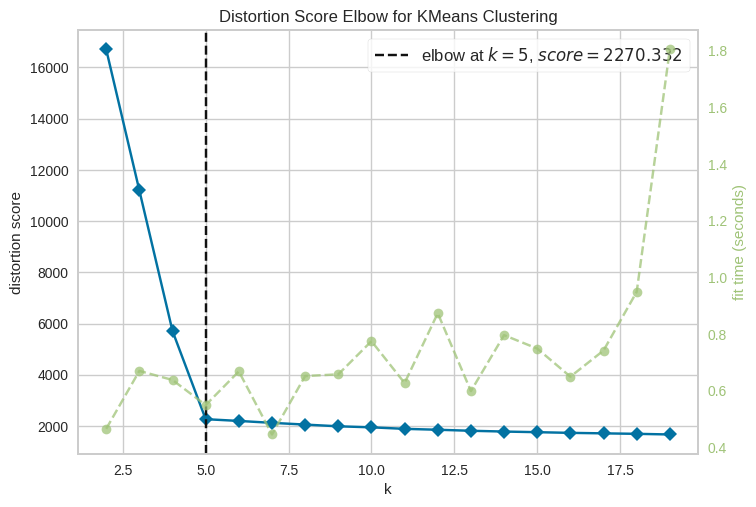

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [178]:
#The following code Tunes the hyperparameters
visualization = KElbowVisualizer(kmeans, k=(2,20))
visualization.fit(scaled_data)
visualization.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

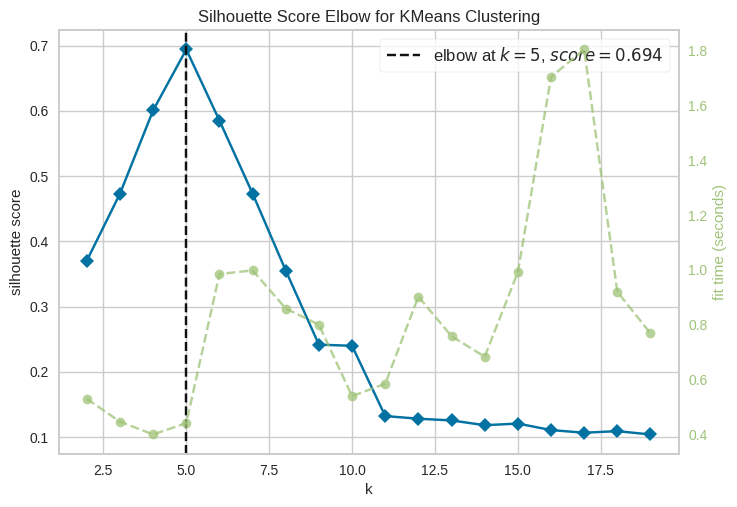

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [179]:
# K will be chosen according to silhouette score and where the elbow starts
visualization = KElbowVisualizer(kmeans, k=(2,20),metric='silhouette')
visualization.fit(scaled_data)
visualization.show()

For both metrics, the best value is 5

In [180]:
kmeans = KMeans(n_clusters=5,random_state=42).fit(scaled_data)
kmean_groups=kmeans.predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [181]:
kmeans_validation=validate_score(scaled_data,kmean_groups)

'silhouette_score:0.6941079726950088'

' davies bouldin_score: 0.4478877715662678'

## DBSCAN

In [182]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [183]:
#We will start with the default parameters (0.5=eps and 5=min points)
DBSCAN_clf = DBSCAN().fit(scaled_data)
basic_dbscan_groups = DBSCAN_clf.labels_

In [184]:
Counter(basic_dbscan_groups)

Counter({4: 46,
         -1: 2111,
         1: 48,
         0: 48,
         2: 42,
         3: 42,
         16: 5,
         12: 19,
         10: 6,
         21: 5,
         6: 22,
         5: 4,
         7: 15,
         8: 14,
         9: 16,
         24: 5,
         14: 5,
         22: 5,
         11: 5,
         23: 5,
         18: 5,
         15: 4,
         13: 10,
         19: 4,
         17: 5,
         20: 4})

In [185]:
basic_dbscan_validation = validate_score(scaled_data,basic_dbscan_groups)

'silhouette_score:-0.6322169408871218'

' davies bouldin_score: 1.6577785343625422'

It seems we'll need to use fine-tuning in order to improve the metrics values

### Using NearestNeighbors to find the optimal eps value

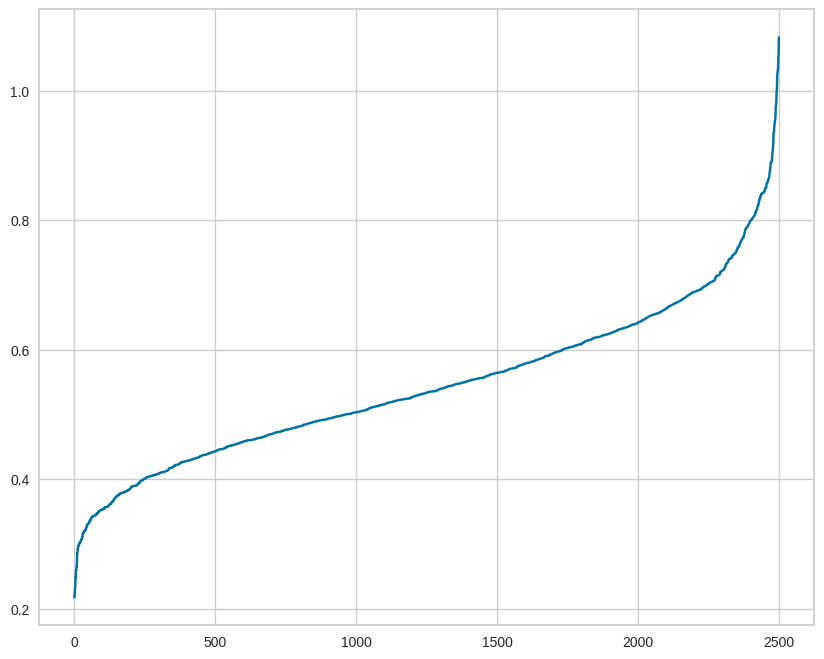

In [186]:
nearest_neighbors = NearestNeighbors(n_neighbors=20).fit(scaled_data)
distances, indices = nearest_neighbors.kneighbors(scaled_data)

#Plotting to visualize the values
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

We'll loop through combinations of MinPts and ε values slightly above and below the values in the plot above, to find the best fit

In [187]:
min_samples = range(15,25,2)
eps = np.arange(0.6,0.85, 0.01)
output = []
for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(scaled_data).labels_
        score = silhouette_score(scaled_data, labels)
        output.append((ms, ep, score))

In [188]:
#get the best parameters values:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print("Best silhouette_score: "+str(score))
print("min_samples: "+str(min_samples))
print("Eps: "+str(eps))

Best silhouette_score: 0.6435302070879139
min_samples: 15
Eps: 0.8400000000000002


### Run DBSCAN with the best parameters found

In [189]:
DBSCAN_clf = DBSCAN(min_samples=15, eps =  0.84).fit(scaled_data)
dbscan_groups=DBSCAN_clf.labels_

In [190]:
Counter(dbscan_groups)

Counter({0: 484, 1: 483, 2: 491, 3: 476, 4: 472, -1: 94})

In [191]:
dbscan_validation=validate_score(df_cluster,dbscan_groups)

'silhouette_score:0.6617310708605504'

' davies bouldin_score: 1.3024197755351825'

## **Compare KMeans VS DBSCAN**

In [192]:
compare_df = pd.DataFrame(columns=['silhouette_score',' davies_bouldin_score'])
compare_df.loc['k means',:] = kmeans_validation
compare_df.loc['dbscan',:] = dbscan_validation

<Axes: >

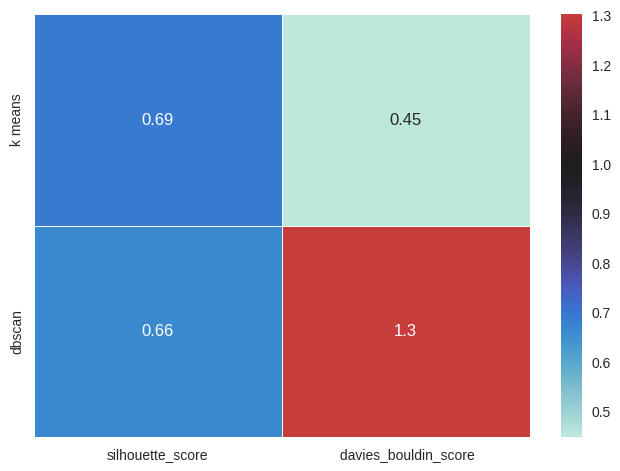

In [193]:
sns.heatmap(compare_df.astype(float), linewidths=0.5, annot=True,center=1)

DBSCAN clustered 5 groups with different sizes, and **1 anomaly group of 94 rows** (that actually don't belond to any group).
The K-means clustered 5 groups with the same size.
As we can see in the matrix, in the silhoette score, the models achieved almost the same result with a small adventage for the DBSCAN in both metrics - which may point **it is the better model for this case**.
Also, the DBSCAN might be better since it can **also point-out anomalies** - which the K-Means can't do, inherenitley.

## **Visualization**

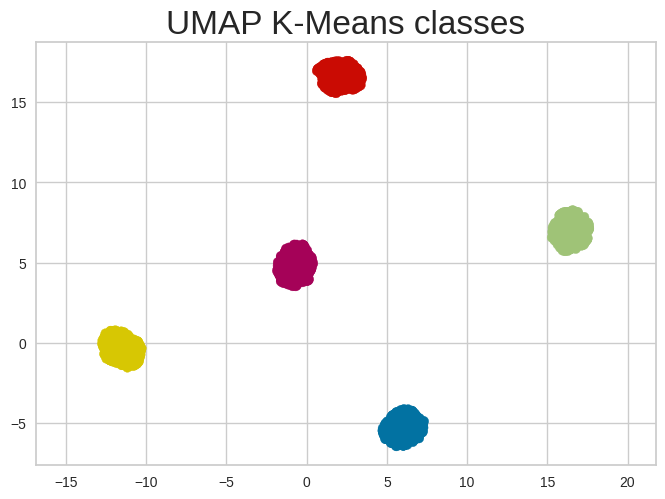

In [194]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in kmean_groups])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP K-Means classes', fontsize=24);

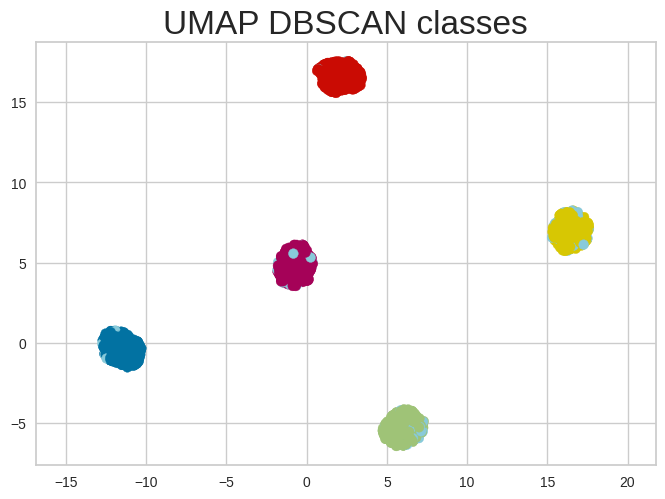

In [195]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in dbscan_groups])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP DBSCAN classes', fontsize=24);